# Бейзлайн для распознавания автомобильных номеров. 

MADE with love :)

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
!ls

gdrive	sample_data


In [3]:
# for colab
! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1E9e4LmjUJxdSgfzfLJgXKOJqtUP6-xYs' -O data.zip
! unzip -qq data.zip

will be placed in the single file you specified.

--2020-06-19 15:18:25--  https://docs.google.com/uc?export=download&id=1E9e4LmjUJxdSgfzfLJgXKOJqtUP6-xYs
Resolving docs.google.com (docs.google.com)... 74.125.124.113, 74.125.124.102, 74.125.124.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.124.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data.zip’

data.zip                [ <=>                ]   3.17K  --.-KB/s    in 0s      

2020-06-19 15:18:25 (26.9 MB/s) - ‘data.zip’ saved [3248]

Loading robots.txt; please ignore errors.
--2020-06-19 15:18:25--  https://docs.google.com/robots.txt
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘data.zip’

data.zip                [ <=>                ]     567  --.-KB/s    in 0s      

2020-06-19 15:18:25 (53.6 MB/s) - ‘data.zip’ saved [567]

--2020-06-19 15:18:25--  h

In [4]:
!ls

data  data.zip	gdrive	sample_data


In [5]:
!du -hs /content/data

6.2G	/content/data


In [6]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [38]:
torch.__version__, torch.cuda.is_available()

('1.5.0+cu101', True)

### Сейчас будет много вспомогательных функций, которые можно промотать

Чтобы было наглядно и не приходилось лезть в модули, чтобы посмотреть, какая функция что делает, оставил для наглядности пока что все в ноутбуке. Можно аккуратно перенести в модули :)

In [8]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None, my_transforms=None, mask_thresh=0.2):  # mask_thresh=0.05
    img = Image.open(file)
    if my_transforms is None:
        my_transforms = transforms.ToTensor()
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
      
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
#             _,contours,_ = cv2.findContours((mask > mask_thresh).astype(np.uint8), 1, 1)
            contours,_ = cv2.findContours((mask > mask_thresh).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)


def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return pick

In [9]:
result_path = '/content/gdrive/My Drive/MADE/CV/car_plates/results/baseline_1'

if not os.path.exists(result_path):
    os.makedirs(result_path)

In [10]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.9
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = os.path.join(result_path, 'detector.pt')
OCR_MODEL_PATH = os.path.join(result_path, 'ocr.pt')

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 1. Находим номера

### a) Модель для детекции

В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Поэтому, возьмем maskrcnn. Будем обучать несколько последних солев. Этого с запасом хватает.

In [11]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

### b) Датасет для детекции

In [12]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

### c) Обучаем модель для детекции

In [13]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


Валидироваться на чем-то нет смысла, ибо лосс перестает падать еще до того момента, как пройдет 1-я эпоха. Т.е. лосс на трейне вполне валидный, ибо модель видит данные в первый раз.

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 0/11534 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
  0%|          | 20/11534 [00:25<3:38:59,  1.14s/it]

Loss: 0.9708482


  0%|          | 40/11534 [00:48<3:49:06,  1.20s/it]

Loss: 0.6344153


  1%|          | 60/11534 [01:12<3:42:10,  1.16s/it]

Loss: 0.5167278


  1%|          | 80/11534 [01:36<3:40:16,  1.15s/it]

Loss: 0.3892858


  1%|          | 100/11534 [01:59<3:40:20,  1.16s/it]

Loss: 0.4389670


  1%|          | 120/11534 [02:22<3:36:18,  1.14s/it]

Loss: 0.3295338


  1%|          | 140/11534 [02:45<3:35:44,  1.14s/it]

Loss: 0.3840800


  1%|▏         | 160/11534 [03:07<3:32:49,  1.12s/it]

Loss: 0.2921018


  2%|▏         | 180/11534 [03:30<3:49:51,  1.21s/it]

Loss: 0.3160744


  2%|▏         | 200/11534 [03:53<3:34:54,  1.14s/it]

Loss: 0.2705798


  2%|▏         | 220/11534 [04:16<3:42:11,  1.18s/it]

Loss: 0.2417052


  2%|▏         | 240/11534 [04:40<3:36:08,  1.15s/it]

Loss: 0.2598487


  2%|▏         | 260/11534 [05:03<3:36:50,  1.15s/it]

Loss: 0.2671164


  2%|▏         | 280/11534 [05:26<3:26:02,  1.10s/it]

Loss: 0.2345494


  3%|▎         | 300/11534 [05:49<3:28:32,  1.11s/it]

Loss: 0.2285678


  3%|▎         | 320/11534 [06:11<3:29:50,  1.12s/it]

Loss: 0.2431570


  3%|▎         | 340/11534 [06:35<3:38:43,  1.17s/it]

Loss: 0.3476443


  3%|▎         | 360/11534 [06:58<3:37:05,  1.17s/it]

Loss: 0.2780085


  3%|▎         | 380/11534 [07:21<3:33:04,  1.15s/it]

Loss: 0.3101127


  3%|▎         | 400/11534 [07:44<3:31:38,  1.14s/it]

Loss: 0.3491714


  4%|▎         | 420/11534 [08:07<3:31:25,  1.14s/it]

Loss: 0.2582259


  4%|▍         | 440/11534 [08:30<3:30:37,  1.14s/it]

Loss: 0.2616431


  4%|▍         | 460/11534 [08:54<3:41:46,  1.20s/it]

Loss: 0.2320765


  4%|▍         | 480/11534 [09:17<3:31:26,  1.15s/it]

Loss: 0.3023943


  4%|▍         | 500/11534 [09:39<3:25:13,  1.12s/it]

Loss: 0.2579455


  5%|▍         | 520/11534 [10:03<3:28:22,  1.14s/it]

Loss: 0.2274214


  5%|▍         | 540/11534 [10:26<3:30:51,  1.15s/it]

Loss: 0.2319016


  5%|▍         | 560/11534 [10:48<3:24:10,  1.12s/it]

Loss: 0.3779885


  5%|▌         | 580/11534 [11:11<3:31:54,  1.16s/it]

Loss: 0.3495807


  5%|▌         | 600/11534 [11:34<3:31:02,  1.16s/it]

Loss: 0.3201790


  5%|▌         | 620/11534 [11:57<3:27:01,  1.14s/it]

Loss: 0.2657744


  6%|▌         | 640/11534 [12:20<3:22:42,  1.12s/it]

Loss: 0.2549565


  6%|▌         | 660/11534 [12:43<3:35:48,  1.19s/it]

Loss: 0.2552932


  6%|▌         | 680/11534 [13:06<3:18:18,  1.10s/it]

Loss: 0.2305697


  6%|▌         | 700/11534 [13:29<3:23:56,  1.13s/it]

Loss: 0.3723064


  6%|▌         | 720/11534 [13:52<3:31:17,  1.17s/it]

Loss: 0.3162060


  6%|▋         | 740/11534 [14:15<3:24:29,  1.14s/it]

Loss: 0.2473777


  7%|▋         | 760/11534 [14:38<3:27:46,  1.16s/it]

Loss: 0.2824709


  7%|▋         | 780/11534 [15:00<3:17:19,  1.10s/it]

Loss: 0.2556478


  7%|▋         | 800/11534 [15:24<3:35:37,  1.21s/it]

Loss: 0.2525117


  7%|▋         | 820/11534 [15:47<3:27:13,  1.16s/it]

Loss: 0.2563178


  7%|▋         | 840/11534 [16:10<3:14:28,  1.09s/it]

Loss: 0.2508449


  7%|▋         | 860/11534 [16:32<3:17:18,  1.11s/it]

Loss: 0.2435098


  8%|▊         | 880/11534 [16:56<3:20:39,  1.13s/it]

Loss: 0.2386935


  8%|▊         | 900/11534 [17:19<3:15:36,  1.10s/it]

Loss: 0.2013357


  8%|▊         | 920/11534 [17:41<3:15:11,  1.10s/it]

Loss: 0.2307956


  8%|▊         | 940/11534 [18:04<3:25:46,  1.17s/it]

Loss: 0.2346325


  8%|▊         | 960/11534 [18:27<3:25:28,  1.17s/it]

Loss: 0.2303826


  8%|▊         | 980/11534 [18:51<3:15:05,  1.11s/it]

Loss: 0.2283066


  9%|▊         | 1000/11534 [19:14<3:34:17,  1.22s/it]

Loss: 0.1915442


  9%|▉         | 1020/11534 [19:38<3:26:30,  1.18s/it]

Loss: 0.2256319


  9%|▉         | 1040/11534 [20:02<3:22:21,  1.16s/it]

Loss: 0.2211936


  9%|▉         | 1060/11534 [20:25<3:11:40,  1.10s/it]

Loss: 0.2145100


  9%|▉         | 1080/11534 [20:48<3:14:13,  1.11s/it]

Loss: 0.2311427


 10%|▉         | 1100/11534 [21:11<3:17:39,  1.14s/it]

Loss: 0.2049771


 10%|▉         | 1120/11534 [21:35<3:32:07,  1.22s/it]

Loss: 0.2122823


 10%|▉         | 1140/11534 [21:59<3:15:05,  1.13s/it]

Loss: 0.1911610


 10%|█         | 1160/11534 [22:21<3:17:30,  1.14s/it]

Loss: 0.2026205


 10%|█         | 1180/11534 [22:45<3:24:19,  1.18s/it]

Loss: 0.2323645


 10%|█         | 1200/11534 [23:09<3:27:58,  1.21s/it]

Loss: 0.2051909


 11%|█         | 1220/11534 [23:32<3:25:58,  1.20s/it]

Loss: 0.2113129


 11%|█         | 1240/11534 [23:55<3:11:44,  1.12s/it]

Loss: 0.2034662


 11%|█         | 1260/11534 [24:19<3:20:37,  1.17s/it]

Loss: 0.1708215


 11%|█         | 1280/11534 [24:42<3:23:47,  1.19s/it]

Loss: 0.2354623


 11%|█▏        | 1300/11534 [25:05<3:19:18,  1.17s/it]

Loss: 0.2049276


 11%|█▏        | 1320/11534 [25:29<3:23:35,  1.20s/it]

Loss: 0.2383372


 12%|█▏        | 1340/11534 [25:52<3:21:56,  1.19s/it]

Loss: 0.2413535


 12%|█▏        | 1360/11534 [26:16<3:25:15,  1.21s/it]

Loss: 0.2275775


 12%|█▏        | 1380/11534 [26:39<3:19:55,  1.18s/it]

Loss: 0.2108740


 12%|█▏        | 1400/11534 [27:02<3:13:51,  1.15s/it]

Loss: 0.2185674


 12%|█▏        | 1420/11534 [27:25<3:15:17,  1.16s/it]

Loss: 0.2174969


 12%|█▏        | 1440/11534 [27:49<3:28:43,  1.24s/it]

Loss: 0.2254991


 13%|█▎        | 1460/11534 [28:12<3:20:11,  1.19s/it]

Loss: 0.2424979


 13%|█▎        | 1480/11534 [28:36<3:16:41,  1.17s/it]

Loss: 0.2300670


 13%|█▎        | 1500/11534 [28:59<3:11:23,  1.14s/it]

Loss: 0.2067442


 13%|█▎        | 1520/11534 [29:22<3:21:06,  1.20s/it]

Loss: 0.1608832


 13%|█▎        | 1540/11534 [29:45<3:18:37,  1.19s/it]

Loss: 0.2108364


 14%|█▎        | 1560/11534 [30:09<3:16:09,  1.18s/it]

Loss: 0.2746588


 14%|█▎        | 1580/11534 [30:33<3:11:04,  1.15s/it]

Loss: 0.1921278


 14%|█▍        | 1600/11534 [30:56<3:16:04,  1.18s/it]

Loss: 0.2700060


 14%|█▍        | 1620/11534 [31:19<3:10:13,  1.15s/it]

Loss: 0.2891573


 14%|█▍        | 1640/11534 [31:42<3:15:30,  1.19s/it]

Loss: 0.2235969


 14%|█▍        | 1660/11534 [32:06<3:11:01,  1.16s/it]

Loss: 0.2714380


 15%|█▍        | 1680/11534 [32:29<3:16:15,  1.19s/it]

Loss: 0.2319030


 15%|█▍        | 1700/11534 [32:53<3:24:00,  1.24s/it]

Loss: 0.2717335


 15%|█▍        | 1720/11534 [33:17<3:17:10,  1.21s/it]

Loss: 0.2304818


 15%|█▌        | 1740/11534 [33:40<3:09:31,  1.16s/it]

Loss: 0.2341278


 15%|█▌        | 1760/11534 [34:04<3:09:17,  1.16s/it]

Loss: 0.2522845


 15%|█▌        | 1780/11534 [34:27<3:08:18,  1.16s/it]

Loss: 0.2369596


 16%|█▌        | 1800/11534 [34:50<3:04:49,  1.14s/it]

Loss: 0.1824442


 16%|█▌        | 1820/11534 [35:14<3:18:26,  1.23s/it]

Loss: 0.2045110


 16%|█▌        | 1840/11534 [35:37<3:19:39,  1.24s/it]

Loss: 0.1949921


 16%|█▌        | 1860/11534 [36:01<3:12:06,  1.19s/it]

Loss: 0.2038651


 16%|█▋        | 1880/11534 [36:25<3:13:44,  1.20s/it]

Loss: 0.1806310


 16%|█▋        | 1900/11534 [36:48<3:01:07,  1.13s/it]

Loss: 0.1755234


 17%|█▋        | 1920/11534 [37:11<3:21:24,  1.26s/it]

Loss: 0.2485347


 17%|█▋        | 1940/11534 [37:35<3:04:28,  1.15s/it]

Loss: 0.2066643
Epoch    97: reducing learning rate of group 0 to 1.5000e-04.


 17%|█▋        | 1960/11534 [37:57<3:02:34,  1.14s/it]

Loss: 0.2909673


 17%|█▋        | 1980/11534 [38:21<3:05:18,  1.16s/it]

Loss: 0.2479774


 17%|█▋        | 2000/11534 [38:44<2:59:21,  1.13s/it]

Loss: 0.2138850


 18%|█▊        | 2020/11534 [39:07<3:00:48,  1.14s/it]

Loss: 0.1978342


 18%|█▊        | 2040/11534 [39:30<3:00:14,  1.14s/it]

Loss: 0.1630464


 18%|█▊        | 2060/11534 [39:54<3:03:28,  1.16s/it]

Loss: 0.1911682


 18%|█▊        | 2080/11534 [40:18<3:10:52,  1.21s/it]

Loss: 0.2258408


 18%|█▊        | 2100/11534 [40:41<3:04:01,  1.17s/it]

Loss: 0.2339058


 18%|█▊        | 2120/11534 [41:04<2:57:54,  1.13s/it]

Loss: 0.1856336


 19%|█▊        | 2140/11534 [41:28<3:01:24,  1.16s/it]

Loss: 0.2199921


 19%|█▊        | 2160/11534 [41:52<3:09:04,  1.21s/it]

Loss: 0.1589046


 19%|█▉        | 2180/11534 [42:15<3:02:56,  1.17s/it]

Loss: 0.1993022


 19%|█▉        | 2200/11534 [42:39<3:10:19,  1.22s/it]

Loss: 0.1923303


 19%|█▉        | 2220/11534 [43:02<3:04:17,  1.19s/it]

Loss: 0.1886748


 19%|█▉        | 2240/11534 [43:26<3:13:53,  1.25s/it]

Loss: 0.1765464


 20%|█▉        | 2260/11534 [43:49<2:50:02,  1.10s/it]

Loss: 0.1859760


 20%|█▉        | 2280/11534 [44:12<3:01:55,  1.18s/it]

Loss: 0.1925571


 20%|█▉        | 2300/11534 [44:36<3:03:22,  1.19s/it]

Loss: 0.2066139


 20%|██        | 2320/11534 [44:59<2:51:17,  1.12s/it]

Loss: 0.1884677


 20%|██        | 2340/11534 [45:22<2:56:12,  1.15s/it]

Loss: 0.1951362


 20%|██        | 2360/11534 [45:46<2:56:54,  1.16s/it]

Loss: 0.1943399


 21%|██        | 2380/11534 [46:10<3:02:07,  1.19s/it]

Loss: 0.1727286


 21%|██        | 2400/11534 [46:33<2:57:52,  1.17s/it]

Loss: 0.2018014


 21%|██        | 2420/11534 [46:57<3:02:35,  1.20s/it]

Loss: 0.1669640


 21%|██        | 2440/11534 [47:21<2:56:39,  1.17s/it]

Loss: 0.1764369


 21%|██▏       | 2460/11534 [47:44<2:58:32,  1.18s/it]

Loss: 0.1590828


 22%|██▏       | 2480/11534 [48:07<2:57:14,  1.17s/it]

Loss: 0.1775604


 22%|██▏       | 2500/11534 [48:31<3:00:39,  1.20s/it]

Loss: 0.1446978


 22%|██▏       | 2520/11534 [48:54<2:53:40,  1.16s/it]

Loss: 0.1837419


 22%|██▏       | 2540/11534 [49:17<2:58:22,  1.19s/it]

Loss: 0.1829749


 22%|██▏       | 2560/11534 [49:41<3:02:00,  1.22s/it]

Loss: 0.1741262


 22%|██▏       | 2580/11534 [50:05<2:49:45,  1.14s/it]

Loss: 0.1821133


 23%|██▎       | 2600/11534 [50:29<2:55:49,  1.18s/it]

Loss: 0.2031043


 23%|██▎       | 2620/11534 [50:52<2:48:36,  1.13s/it]

Loss: 0.1746096


 23%|██▎       | 2640/11534 [51:15<2:51:05,  1.15s/it]

Loss: 0.1867210


 23%|██▎       | 2660/11534 [51:38<2:54:10,  1.18s/it]

Loss: 0.1856418


 23%|██▎       | 2680/11534 [52:02<2:46:41,  1.13s/it]

Loss: 0.2159987


 23%|██▎       | 2700/11534 [52:25<2:49:57,  1.15s/it]

Loss: 0.2290866


 24%|██▎       | 2720/11534 [52:49<2:49:30,  1.15s/it]

Loss: 0.2029556


 24%|██▍       | 2740/11534 [53:13<2:44:43,  1.12s/it]

Loss: 0.2067178


 24%|██▍       | 2760/11534 [53:37<2:57:15,  1.21s/it]

Loss: 0.1989213


 24%|██▍       | 2780/11534 [54:00<2:45:08,  1.13s/it]

Loss: 0.1996870


 24%|██▍       | 2800/11534 [54:24<2:49:02,  1.16s/it]

Loss: 0.1710992


 24%|██▍       | 2820/11534 [54:47<2:44:44,  1.13s/it]

Loss: 0.1798368


 25%|██▍       | 2840/11534 [55:10<2:51:09,  1.18s/it]

Loss: 0.1708474


 25%|██▍       | 2860/11534 [55:33<2:47:04,  1.16s/it]

Loss: 0.1956023


 25%|██▍       | 2880/11534 [55:57<2:55:43,  1.22s/it]

Loss: 0.1849806


 25%|██▌       | 2900/11534 [56:21<2:45:58,  1.15s/it]

Loss: 0.1953998


 25%|██▌       | 2920/11534 [56:44<2:50:29,  1.19s/it]

Loss: 0.1619956
Epoch   146: reducing learning rate of group 0 to 7.5000e-05.


 25%|██▌       | 2940/11534 [57:09<2:44:23,  1.15s/it]

Loss: 0.1799960


 26%|██▌       | 2960/11534 [57:33<2:44:51,  1.15s/it]

Loss: 0.1565105


 26%|██▌       | 2980/11534 [57:56<2:41:49,  1.14s/it]

Loss: 0.1535812


 26%|██▌       | 3000/11534 [58:20<2:50:42,  1.20s/it]

Loss: 0.1490859


 26%|██▌       | 3020/11534 [58:43<2:48:05,  1.18s/it]

Loss: 0.1804401


 26%|██▋       | 3040/11534 [59:08<2:59:47,  1.27s/it]

Loss: 0.1730632


 27%|██▋       | 3060/11534 [59:31<2:35:58,  1.10s/it]

Loss: 0.1606136


 27%|██▋       | 3080/11534 [59:54<2:46:20,  1.18s/it]

Loss: 0.1594919


 27%|██▋       | 3100/11534 [1:00:17<2:40:33,  1.14s/it]

Loss: 0.1644288


 27%|██▋       | 3120/11534 [1:00:42<2:53:26,  1.24s/it]

Loss: 0.1665451


 27%|██▋       | 3140/11534 [1:01:06<2:45:15,  1.18s/it]

Loss: 0.1450520


 27%|██▋       | 3160/11534 [1:01:29<2:44:40,  1.18s/it]

Loss: 0.1810837


 28%|██▊       | 3180/11534 [1:01:53<2:41:43,  1.16s/it]

Loss: 0.1771534


 28%|██▊       | 3200/11534 [1:02:16<2:40:10,  1.15s/it]

Loss: 0.1400762


 28%|██▊       | 3220/11534 [1:02:40<2:42:38,  1.17s/it]

Loss: 0.1438648


 28%|██▊       | 3240/11534 [1:03:04<2:41:58,  1.17s/it]

Loss: 0.1543467


 28%|██▊       | 3260/11534 [1:03:28<2:42:38,  1.18s/it]

Loss: 0.1593722


 28%|██▊       | 3280/11534 [1:03:51<2:38:14,  1.15s/it]

Loss: 0.1511911


 29%|██▊       | 3300/11534 [1:04:14<2:44:59,  1.20s/it]

Loss: 0.1677442


 29%|██▉       | 3320/11534 [1:04:39<2:49:43,  1.24s/it]

Loss: 0.1855845


 29%|██▉       | 3340/11534 [1:05:03<2:43:51,  1.20s/it]

Loss: 0.1670267


 29%|██▉       | 3360/11534 [1:05:26<2:39:51,  1.17s/it]

Loss: 0.1620930


 29%|██▉       | 3380/11534 [1:05:49<2:40:19,  1.18s/it]

Loss: 0.1642063


 29%|██▉       | 3400/11534 [1:06:12<2:32:43,  1.13s/it]

Loss: 0.1631152


 30%|██▉       | 3420/11534 [1:06:35<2:34:50,  1.14s/it]

Loss: 0.1512667


 30%|██▉       | 3440/11534 [1:06:59<2:33:48,  1.14s/it]

Loss: 0.1708634


 30%|██▉       | 3460/11534 [1:07:22<2:33:52,  1.14s/it]

Loss: 0.1604063


 30%|███       | 3480/11534 [1:07:46<2:40:52,  1.20s/it]

Loss: 0.1655075


 30%|███       | 3500/11534 [1:08:09<2:31:35,  1.13s/it]

Loss: 0.1761964


 31%|███       | 3520/11534 [1:08:31<2:29:47,  1.12s/it]

Loss: 0.1774829


 31%|███       | 3540/11534 [1:08:55<2:34:03,  1.16s/it]

Loss: 0.1509570


 31%|███       | 3560/11534 [1:09:18<2:32:28,  1.15s/it]

Loss: 0.1807900


 31%|███       | 3580/11534 [1:09:42<2:37:16,  1.19s/it]

Loss: 0.1507077


 31%|███       | 3600/11534 [1:10:06<2:38:39,  1.20s/it]

Loss: 0.1662930


 31%|███▏      | 3620/11534 [1:10:30<2:28:32,  1.13s/it]

Loss: 0.1599135
Epoch   181: reducing learning rate of group 0 to 3.7500e-05.


 32%|███▏      | 3640/11534 [1:10:53<2:38:03,  1.20s/it]

Loss: 0.1670247


 32%|███▏      | 3660/11534 [1:11:17<2:28:05,  1.13s/it]

Loss: 0.1738588


 32%|███▏      | 3680/11534 [1:11:40<2:31:08,  1.15s/it]

Loss: 0.1773835


 32%|███▏      | 3700/11534 [1:12:03<2:34:11,  1.18s/it]

Loss: 0.1669331


 32%|███▏      | 3720/11534 [1:12:27<2:28:49,  1.14s/it]

Loss: 0.1631230


 32%|███▏      | 3740/11534 [1:12:51<2:38:24,  1.22s/it]

Loss: 0.1608710


 33%|███▎      | 3760/11534 [1:13:15<2:28:32,  1.15s/it]

Loss: 0.1581608


 33%|███▎      | 3780/11534 [1:13:38<2:36:41,  1.21s/it]

Loss: 0.1684382


 33%|███▎      | 3800/11534 [1:14:02<2:33:31,  1.19s/it]

Loss: 0.1767536


 33%|███▎      | 3820/11534 [1:14:26<2:36:46,  1.22s/it]

Loss: 0.1450597


 33%|███▎      | 3840/11534 [1:14:48<2:24:52,  1.13s/it]

Loss: 0.1474073


 33%|███▎      | 3860/11534 [1:15:12<2:30:48,  1.18s/it]

Loss: 0.1520786


 34%|███▎      | 3880/11534 [1:15:35<2:21:57,  1.11s/it]

Loss: 0.1689334


 34%|███▍      | 3900/11534 [1:15:59<2:28:39,  1.17s/it]

Loss: 0.1637058


 34%|███▍      | 3920/11534 [1:16:22<2:32:45,  1.20s/it]

Loss: 0.1589600


 34%|███▍      | 3940/11534 [1:16:45<2:22:24,  1.13s/it]

Loss: 0.1820437


 34%|███▍      | 3960/11534 [1:17:08<2:29:34,  1.18s/it]

Loss: 0.1930077


 35%|███▍      | 3980/11534 [1:17:32<2:22:03,  1.13s/it]

Loss: 0.1794869


 35%|███▍      | 4000/11534 [1:17:56<2:26:55,  1.17s/it]

Loss: 0.1699969


 35%|███▍      | 4020/11534 [1:18:19<2:29:11,  1.19s/it]

Loss: 0.1674210


 35%|███▌      | 4040/11534 [1:18:43<2:21:44,  1.13s/it]

Loss: 0.1784264
Epoch   202: reducing learning rate of group 0 to 1.8750e-05.


 35%|███▌      | 4060/11534 [1:19:06<2:30:15,  1.21s/it]

Loss: 0.1674269


 35%|███▌      | 4080/11534 [1:19:30<2:32:34,  1.23s/it]

Loss: 0.1771742


 36%|███▌      | 4100/11534 [1:19:53<2:20:05,  1.13s/it]

Loss: 0.1386101


 36%|███▌      | 4120/11534 [1:20:16<2:20:44,  1.14s/it]

Loss: 0.1508247


 36%|███▌      | 4140/11534 [1:20:40<2:31:01,  1.23s/it]

Loss: 0.1650904


 36%|███▌      | 4160/11534 [1:21:04<2:27:36,  1.20s/it]

Loss: 0.1856690


 36%|███▌      | 4180/11534 [1:21:27<2:28:37,  1.21s/it]

Loss: 0.1403961


 36%|███▋      | 4200/11534 [1:21:50<2:33:52,  1.26s/it]

Loss: 0.1473747


 37%|███▋      | 4220/11534 [1:22:14<2:21:10,  1.16s/it]

Loss: 0.1589056


 37%|███▋      | 4240/11534 [1:22:38<2:24:02,  1.18s/it]

Loss: 0.1370355


 37%|███▋      | 4260/11534 [1:23:01<2:22:49,  1.18s/it]

Loss: 0.1374200


 37%|███▋      | 4280/11534 [1:23:25<2:28:25,  1.23s/it]

Loss: 0.1940750


 37%|███▋      | 4300/11534 [1:23:49<2:20:51,  1.17s/it]

Loss: 0.1679461


 37%|███▋      | 4320/11534 [1:24:12<2:20:18,  1.17s/it]

Loss: 0.1826370


 38%|███▊      | 4340/11534 [1:24:36<2:25:40,  1.22s/it]

Loss: 0.1658372


 38%|███▊      | 4360/11534 [1:25:01<2:25:12,  1.21s/it]

Loss: 0.1534642


 38%|███▊      | 4380/11534 [1:25:24<2:11:19,  1.10s/it]

Loss: 0.1745092


 38%|███▊      | 4400/11534 [1:25:47<2:22:56,  1.20s/it]

Loss: 0.1627654


 38%|███▊      | 4420/11534 [1:26:11<2:11:34,  1.11s/it]

Loss: 0.1708870


 38%|███▊      | 4440/11534 [1:26:35<2:22:45,  1.21s/it]

Loss: 0.1746646


 39%|███▊      | 4460/11534 [1:26:59<2:24:15,  1.22s/it]

Loss: 0.1395407


 39%|███▉      | 4480/11534 [1:27:23<2:22:36,  1.21s/it]

Loss: 0.1646653


 39%|███▉      | 4500/11534 [1:27:46<2:18:09,  1.18s/it]

Loss: 0.1650426


 39%|███▉      | 4520/11534 [1:28:09<2:13:00,  1.14s/it]

Loss: 0.1622013


 39%|███▉      | 4540/11534 [1:28:33<2:16:19,  1.17s/it]

Loss: 0.1759648


 40%|███▉      | 4560/11534 [1:28:56<2:21:40,  1.22s/it]

Loss: 0.1820345


 40%|███▉      | 4580/11534 [1:29:20<2:12:53,  1.15s/it]

Loss: 0.1804624


 40%|███▉      | 4600/11534 [1:29:43<2:11:22,  1.14s/it]

Loss: 0.1506269


 40%|████      | 4620/11534 [1:30:07<2:12:52,  1.15s/it]

Loss: 0.1521764


 40%|████      | 4640/11534 [1:30:31<2:20:53,  1.23s/it]

Loss: 0.1773837


 40%|████      | 4660/11534 [1:30:54<2:12:35,  1.16s/it]

Loss: 0.1569089
Epoch   233: reducing learning rate of group 0 to 9.3750e-06.


 41%|████      | 4680/11534 [1:31:18<2:09:55,  1.14s/it]

Loss: 0.1431936


 41%|████      | 4700/11534 [1:31:41<2:12:08,  1.16s/it]

Loss: 0.1489344


 41%|████      | 4720/11534 [1:32:04<2:12:35,  1.17s/it]

Loss: 0.1660796


 41%|████      | 4740/11534 [1:32:28<2:18:01,  1.22s/it]

Loss: 0.1815372


 41%|████▏     | 4760/11534 [1:32:51<2:13:20,  1.18s/it]

Loss: 0.1547366


 41%|████▏     | 4780/11534 [1:33:14<2:11:55,  1.17s/it]

Loss: 0.1685700


 42%|████▏     | 4800/11534 [1:33:38<2:11:56,  1.18s/it]

Loss: 0.1618337


 42%|████▏     | 4820/11534 [1:34:01<2:09:10,  1.15s/it]

Loss: 0.1716562


 42%|████▏     | 4840/11534 [1:34:25<2:10:00,  1.17s/it]

Loss: 0.1453108


 42%|████▏     | 4860/11534 [1:34:48<2:11:24,  1.18s/it]

Loss: 0.1600352


 42%|████▏     | 4880/11534 [1:35:11<2:05:18,  1.13s/it]

Loss: 0.1547350


 42%|████▏     | 4900/11534 [1:35:36<2:07:07,  1.15s/it]

Loss: 0.1496987


 43%|████▎     | 4920/11534 [1:35:59<2:09:48,  1.18s/it]

Loss: 0.1477323


 43%|████▎     | 4940/11534 [1:36:22<2:09:00,  1.17s/it]

Loss: 0.1665529


 43%|████▎     | 4960/11534 [1:36:46<2:11:19,  1.20s/it]

Loss: 0.1971088


 43%|████▎     | 4980/11534 [1:37:09<2:10:59,  1.20s/it]

Loss: 0.1953952


 43%|████▎     | 5000/11534 [1:37:32<2:04:40,  1.14s/it]

Loss: 0.1803813


 44%|████▎     | 5020/11534 [1:37:55<2:03:38,  1.14s/it]

Loss: 0.1589861


 44%|████▎     | 5040/11534 [1:38:20<2:08:25,  1.19s/it]

Loss: 0.1509311


 44%|████▍     | 5060/11534 [1:38:44<2:06:01,  1.17s/it]

Loss: 0.1541523


 44%|████▍     | 5080/11534 [1:39:08<2:06:01,  1.17s/it]

Loss: 0.1504430
Epoch   254: reducing learning rate of group 0 to 4.6875e-06.


 44%|████▍     | 5100/11534 [1:39:32<2:10:59,  1.22s/it]

Loss: 0.1421074


 44%|████▍     | 5120/11534 [1:39:57<2:16:36,  1.28s/it]

Loss: 0.1441484


 45%|████▍     | 5140/11534 [1:40:20<2:01:18,  1.14s/it]

Loss: 0.1836790


 45%|████▍     | 5160/11534 [1:40:43<2:06:38,  1.19s/it]

Loss: 0.1940048


 45%|████▍     | 5180/11534 [1:41:07<2:05:46,  1.19s/it]

Loss: 0.1588187


 45%|████▌     | 5200/11534 [1:41:31<2:01:16,  1.15s/it]

Loss: 0.1527592


 45%|████▌     | 5220/11534 [1:41:55<2:05:12,  1.19s/it]

Loss: 0.1559558


 45%|████▌     | 5240/11534 [1:42:19<2:11:30,  1.25s/it]

Loss: 0.1884063


 46%|████▌     | 5260/11534 [1:42:42<2:02:38,  1.17s/it]

Loss: 0.1670323


 46%|████▌     | 5280/11534 [1:43:06<2:02:38,  1.18s/it]

Loss: 0.1733661


 46%|████▌     | 5300/11534 [1:43:30<2:00:13,  1.16s/it]

Loss: 0.1726044


 46%|████▌     | 5320/11534 [1:43:53<1:58:09,  1.14s/it]

Loss: 0.2180486


 46%|████▋     | 5340/11534 [1:44:16<1:56:29,  1.13s/it]

Loss: 0.1450948


 46%|████▋     | 5360/11534 [1:44:40<2:00:09,  1.17s/it]

Loss: 0.1740780


 47%|████▋     | 5380/11534 [1:45:03<2:01:09,  1.18s/it]

Loss: 0.1572564


 47%|████▋     | 5400/11534 [1:45:26<1:58:18,  1.16s/it]

Loss: 0.1431526


 47%|████▋     | 5420/11534 [1:45:50<2:01:54,  1.20s/it]

Loss: 0.1613051


 47%|████▋     | 5440/11534 [1:46:13<1:56:15,  1.14s/it]

Loss: 0.1606663


 47%|████▋     | 5460/11534 [1:46:37<1:57:05,  1.16s/it]

Loss: 0.1745238


 48%|████▊     | 5480/11534 [1:47:01<1:57:04,  1.16s/it]

Loss: 0.1704527


 48%|████▊     | 5500/11534 [1:47:24<1:58:45,  1.18s/it]

Loss: 0.1599084
Epoch   275: reducing learning rate of group 0 to 2.3437e-06.


 48%|████▊     | 5520/11534 [1:47:47<1:55:49,  1.16s/it]

Loss: 0.1603357


 48%|████▊     | 5540/11534 [1:48:10<1:54:47,  1.15s/it]

Loss: 0.1577343


 48%|████▊     | 5560/11534 [1:48:33<1:54:01,  1.15s/it]

Loss: 0.1522749


 48%|████▊     | 5580/11534 [1:48:58<1:59:52,  1.21s/it]

Loss: 0.1781675


 49%|████▊     | 5600/11534 [1:49:22<1:59:40,  1.21s/it]

Loss: 0.1692442


 49%|████▊     | 5620/11534 [1:49:46<2:00:01,  1.22s/it]

Loss: 0.1641837


 49%|████▉     | 5640/11534 [1:50:09<1:53:05,  1.15s/it]

Loss: 0.1669666


 49%|████▉     | 5660/11534 [1:50:34<1:54:58,  1.17s/it]

Loss: 0.1946710


 49%|████▉     | 5680/11534 [1:50:58<1:56:35,  1.19s/it]

Loss: 0.1592452


 49%|████▉     | 5700/11534 [1:51:21<1:55:36,  1.19s/it]

Loss: 0.1388034


 50%|████▉     | 5720/11534 [1:51:45<1:49:39,  1.13s/it]

Loss: 0.1458310


 50%|████▉     | 5740/11534 [1:52:08<1:48:42,  1.13s/it]

Loss: 0.1502958


 50%|████▉     | 5760/11534 [1:52:31<1:50:54,  1.15s/it]

Loss: 0.1535928


 50%|█████     | 5780/11534 [1:52:55<1:58:46,  1.24s/it]

Loss: 0.1847503


 50%|█████     | 5800/11534 [1:53:19<1:51:18,  1.16s/it]

Loss: 0.1436060


 50%|█████     | 5820/11534 [1:53:43<1:55:07,  1.21s/it]

Loss: 0.1507039


 51%|█████     | 5840/11534 [1:54:06<1:55:12,  1.21s/it]

Loss: 0.1570054


 51%|█████     | 5860/11534 [1:54:30<1:54:09,  1.21s/it]

Loss: 0.1482398


 51%|█████     | 5880/11534 [1:54:54<1:54:32,  1.22s/it]

Loss: 0.1608906


 51%|█████     | 5900/11534 [1:55:18<1:55:42,  1.23s/it]

Loss: 0.1341936


 51%|█████▏    | 5920/11534 [1:55:42<1:49:39,  1.17s/it]

Loss: 0.1850225


 51%|█████▏    | 5940/11534 [1:56:05<1:45:10,  1.13s/it]

Loss: 0.1628681


 52%|█████▏    | 5960/11534 [1:56:29<1:51:55,  1.20s/it]

Loss: 0.1594751


 52%|█████▏    | 5980/11534 [1:56:53<1:47:54,  1.17s/it]

Loss: 0.1588971


 52%|█████▏    | 6000/11534 [1:57:16<1:49:06,  1.18s/it]

Loss: 0.1396605


 52%|█████▏    | 6020/11534 [1:57:39<1:44:45,  1.14s/it]

Loss: 0.1409295


 52%|█████▏    | 6040/11534 [1:58:03<1:52:33,  1.23s/it]

Loss: 0.1668677


 53%|█████▎    | 6060/11534 [1:58:26<1:50:56,  1.22s/it]

Loss: 0.1594794


 53%|█████▎    | 6080/11534 [1:58:50<1:45:30,  1.16s/it]

Loss: 0.1572642


 53%|█████▎    | 6100/11534 [1:59:15<1:55:36,  1.28s/it]

Loss: 0.1347056


 53%|█████▎    | 6120/11534 [1:59:39<1:50:54,  1.23s/it]

Loss: 0.1667535


 53%|█████▎    | 6140/11534 [2:00:02<1:43:33,  1.15s/it]

Loss: 0.1618047


 53%|█████▎    | 6160/11534 [2:00:26<1:45:18,  1.18s/it]

Loss: 0.1648104


 54%|█████▎    | 6180/11534 [2:00:50<1:50:07,  1.23s/it]

Loss: 0.1473981


 54%|█████▍    | 6200/11534 [2:01:13<1:45:49,  1.19s/it]

Loss: 0.1644264


 54%|█████▍    | 6220/11534 [2:01:37<1:39:22,  1.12s/it]

Loss: 0.1708190


 54%|█████▍    | 6240/11534 [2:02:00<1:46:24,  1.21s/it]

Loss: 0.1533166


 54%|█████▍    | 6260/11534 [2:02:23<1:41:53,  1.16s/it]

Loss: 0.1441942


 54%|█████▍    | 6280/11534 [2:02:47<1:42:13,  1.17s/it]

Loss: 0.1475513


 55%|█████▍    | 6300/11534 [2:03:10<1:36:50,  1.11s/it]

Loss: 0.1668900


 55%|█████▍    | 6320/11534 [2:03:33<1:38:02,  1.13s/it]

Loss: 0.1476409
Epoch   316: reducing learning rate of group 0 to 1.1719e-06.


 55%|█████▍    | 6340/11534 [2:03:56<1:44:59,  1.21s/it]

Loss: 0.1723125


 55%|█████▌    | 6360/11534 [2:04:20<1:38:49,  1.15s/it]

Loss: 0.1614525


 55%|█████▌    | 6380/11534 [2:04:43<1:44:29,  1.22s/it]

Loss: 0.1444353


 55%|█████▌    | 6400/11534 [2:05:07<1:43:34,  1.21s/it]

Loss: 0.1629464


 56%|█████▌    | 6420/11534 [2:05:31<1:46:19,  1.25s/it]

Loss: 0.1514089


 56%|█████▌    | 6440/11534 [2:05:54<1:38:59,  1.17s/it]

Loss: 0.1472823


 56%|█████▌    | 6460/11534 [2:06:18<1:44:51,  1.24s/it]

Loss: 0.1708442


 56%|█████▌    | 6480/11534 [2:06:42<1:44:28,  1.24s/it]

Loss: 0.1438878


 56%|█████▋    | 6500/11534 [2:07:05<1:39:14,  1.18s/it]

Loss: 0.1506904


 57%|█████▋    | 6520/11534 [2:07:29<1:39:18,  1.19s/it]

Loss: 0.1531887


 57%|█████▋    | 6540/11534 [2:07:52<1:37:13,  1.17s/it]

Loss: 0.1529750


 57%|█████▋    | 6560/11534 [2:08:16<1:35:37,  1.15s/it]

Loss: 0.1263153


 57%|█████▋    | 6580/11534 [2:08:40<1:38:19,  1.19s/it]

Loss: 0.1558371


 57%|█████▋    | 6600/11534 [2:09:03<1:34:30,  1.15s/it]

Loss: 0.1513488


 57%|█████▋    | 6620/11534 [2:09:26<1:40:07,  1.22s/it]

Loss: 0.1490892


 58%|█████▊    | 6640/11534 [2:09:50<1:38:40,  1.21s/it]

Loss: 0.1411136


 58%|█████▊    | 6660/11534 [2:10:13<1:37:40,  1.20s/it]

Loss: 0.1634414


 58%|█████▊    | 6680/11534 [2:10:36<1:35:24,  1.18s/it]

Loss: 0.1632819


 58%|█████▊    | 6700/11534 [2:11:01<1:36:52,  1.20s/it]

Loss: 0.1667105


 58%|█████▊    | 6720/11534 [2:11:24<1:32:00,  1.15s/it]

Loss: 0.1431818


 58%|█████▊    | 6740/11534 [2:11:48<1:34:06,  1.18s/it]

Loss: 0.1629368


 59%|█████▊    | 6760/11534 [2:12:11<1:32:22,  1.16s/it]

Loss: 0.1666747


 59%|█████▉    | 6780/11534 [2:12:36<1:36:32,  1.22s/it]

Loss: 0.1672332


 59%|█████▉    | 6800/11534 [2:12:59<1:32:37,  1.17s/it]

Loss: 0.1448076


 59%|█████▉    | 6820/11534 [2:13:23<1:41:07,  1.29s/it]

Loss: 0.1575433


 59%|█████▉    | 6840/11534 [2:13:47<1:31:23,  1.17s/it]

Loss: 0.1498962


 59%|█████▉    | 6860/11534 [2:14:11<1:31:10,  1.17s/it]

Loss: 0.1644750


 60%|█████▉    | 6880/11534 [2:14:35<1:29:55,  1.16s/it]

Loss: 0.1482021


 60%|█████▉    | 6900/11534 [2:14:58<1:27:58,  1.14s/it]

Loss: 0.1593427


 60%|█████▉    | 6920/11534 [2:15:21<1:29:34,  1.16s/it]

Loss: 0.1693598


 60%|██████    | 6940/11534 [2:15:44<1:29:28,  1.17s/it]

Loss: 0.1514171


 60%|██████    | 6960/11534 [2:16:08<1:25:51,  1.13s/it]

Loss: 0.1474711


 61%|██████    | 6980/11534 [2:16:31<1:29:49,  1.18s/it]

Loss: 0.1742788
Epoch   349: reducing learning rate of group 0 to 5.8594e-07.


 61%|██████    | 7000/11534 [2:16:54<1:25:29,  1.13s/it]

Loss: 0.1715143


 61%|██████    | 7020/11534 [2:17:18<1:32:36,  1.23s/it]

Loss: 0.1447910


 61%|██████    | 7040/11534 [2:17:42<1:28:13,  1.18s/it]

Loss: 0.1538909


 61%|██████    | 7060/11534 [2:18:05<1:28:18,  1.18s/it]

Loss: 0.1516847


 61%|██████▏   | 7080/11534 [2:18:29<1:31:10,  1.23s/it]

Loss: 0.1593559


 62%|██████▏   | 7100/11534 [2:18:54<1:26:21,  1.17s/it]

Loss: 0.1742431


 62%|██████▏   | 7120/11534 [2:19:18<1:28:48,  1.21s/it]

Loss: 0.1421456


 62%|██████▏   | 7140/11534 [2:19:42<1:33:05,  1.27s/it]

Loss: 0.1547976


 62%|██████▏   | 7160/11534 [2:20:05<1:22:53,  1.14s/it]

Loss: 0.2477739


 62%|██████▏   | 7180/11534 [2:20:27<1:20:08,  1.10s/it]

Loss: 0.1487569


 62%|██████▏   | 7200/11534 [2:20:51<1:25:07,  1.18s/it]

Loss: 0.1445411


 63%|██████▎   | 7220/11534 [2:21:14<1:23:07,  1.16s/it]

Loss: 0.1531574


 63%|██████▎   | 7240/11534 [2:21:37<1:27:56,  1.23s/it]

Loss: 0.1490711


 63%|██████▎   | 7260/11534 [2:22:01<1:20:22,  1.13s/it]

Loss: 0.1489916


 63%|██████▎   | 7280/11534 [2:22:24<1:19:18,  1.12s/it]

Loss: 0.1355859


 63%|██████▎   | 7300/11534 [2:22:47<1:22:16,  1.17s/it]

Loss: 0.1683061


 63%|██████▎   | 7320/11534 [2:23:11<1:23:17,  1.19s/it]

Loss: 0.1741345


 64%|██████▎   | 7340/11534 [2:23:34<1:19:07,  1.13s/it]

Loss: 0.1419341


 64%|██████▍   | 7360/11534 [2:23:57<1:19:01,  1.14s/it]

Loss: 0.1505798


 64%|██████▍   | 7380/11534 [2:24:21<1:20:57,  1.17s/it]

Loss: 0.1636025


 64%|██████▍   | 7400/11534 [2:24:44<1:20:34,  1.17s/it]

Loss: 0.1526832
Epoch   370: reducing learning rate of group 0 to 2.9297e-07.


 64%|██████▍   | 7420/11534 [2:25:08<1:20:04,  1.17s/it]

Loss: 0.1563329


 65%|██████▍   | 7440/11534 [2:25:33<1:19:39,  1.17s/it]

Loss: 0.1854968


 65%|██████▍   | 7460/11534 [2:25:56<1:18:50,  1.16s/it]

Loss: 0.1598273


 65%|██████▍   | 7480/11534 [2:26:20<1:23:57,  1.24s/it]

Loss: 0.1491215


 65%|██████▌   | 7500/11534 [2:26:44<1:17:21,  1.15s/it]

Loss: 0.1510139


 65%|██████▌   | 7520/11534 [2:27:07<1:20:44,  1.21s/it]

Loss: 0.1393443


 65%|██████▌   | 7540/11534 [2:27:31<1:21:11,  1.22s/it]

Loss: 0.1720816


 66%|██████▌   | 7560/11534 [2:27:55<1:18:09,  1.18s/it]

Loss: 0.1604367


 66%|██████▌   | 7580/11534 [2:28:18<1:15:37,  1.15s/it]

Loss: 0.1550668


 66%|██████▌   | 7600/11534 [2:28:42<1:19:05,  1.21s/it]

Loss: 0.1998817


 66%|██████▌   | 7620/11534 [2:29:05<1:14:09,  1.14s/it]

Loss: 0.1392383


 66%|██████▌   | 7640/11534 [2:29:28<1:20:20,  1.24s/it]

Loss: 0.1585369


 66%|██████▋   | 7660/11534 [2:29:52<1:15:30,  1.17s/it]

Loss: 0.1579745


 67%|██████▋   | 7680/11534 [2:30:15<1:14:12,  1.16s/it]

Loss: 0.1847312


 67%|██████▋   | 7700/11534 [2:30:39<1:15:45,  1.19s/it]

Loss: 0.1593477


 67%|██████▋   | 7720/11534 [2:31:02<1:14:28,  1.17s/it]

Loss: 0.1429845


 67%|██████▋   | 7740/11534 [2:31:26<1:13:22,  1.16s/it]

Loss: 0.1640784


 67%|██████▋   | 7760/11534 [2:31:50<1:15:31,  1.20s/it]

Loss: 0.1534204


 67%|██████▋   | 7780/11534 [2:32:12<1:09:11,  1.11s/it]

Loss: 0.1619211


 68%|██████▊   | 7800/11534 [2:32:36<1:11:56,  1.16s/it]

Loss: 0.1507891


 68%|██████▊   | 7820/11534 [2:33:00<1:10:46,  1.14s/it]

Loss: 0.1614545
Epoch   391: reducing learning rate of group 0 to 1.4648e-07.


 68%|██████▊   | 7840/11534 [2:33:23<1:11:26,  1.16s/it]

Loss: 0.1547786


 68%|██████▊   | 7860/11534 [2:33:46<1:11:22,  1.17s/it]

Loss: 0.1475110


 68%|██████▊   | 7880/11534 [2:34:10<1:12:31,  1.19s/it]

Loss: 0.1509439


 68%|██████▊   | 7900/11534 [2:34:34<1:08:30,  1.13s/it]

Loss: 0.1554037


 69%|██████▊   | 7920/11534 [2:34:57<1:10:43,  1.17s/it]

Loss: 0.1510426


 69%|██████▉   | 7940/11534 [2:35:21<1:13:13,  1.22s/it]

Loss: 0.1643152


 69%|██████▉   | 7960/11534 [2:35:45<1:12:41,  1.22s/it]

Loss: 0.1576775


 69%|██████▉   | 7980/11534 [2:36:09<1:10:08,  1.18s/it]

Loss: 0.1496476


 69%|██████▉   | 8000/11534 [2:36:32<1:10:29,  1.20s/it]

Loss: 0.1385604


 70%|██████▉   | 8020/11534 [2:36:56<1:05:39,  1.12s/it]

Loss: 0.1572853


 70%|██████▉   | 8040/11534 [2:37:18<1:08:35,  1.18s/it]

Loss: 0.1516547


 70%|██████▉   | 8060/11534 [2:37:41<1:04:15,  1.11s/it]

Loss: 0.1662383


 70%|███████   | 8080/11534 [2:38:05<1:06:46,  1.16s/it]

Loss: 0.1608251


 70%|███████   | 8100/11534 [2:38:29<1:07:37,  1.18s/it]

Loss: 0.1646409


 70%|███████   | 8120/11534 [2:38:52<1:05:46,  1.16s/it]

Loss: 0.1555417


 71%|███████   | 8140/11534 [2:39:15<1:05:59,  1.17s/it]

Loss: 0.1853200


 71%|███████   | 8160/11534 [2:39:39<1:08:52,  1.22s/it]

Loss: 0.1743567


 71%|███████   | 8180/11534 [2:40:02<1:05:41,  1.18s/it]

Loss: 0.1873836


 71%|███████   | 8200/11534 [2:40:26<1:06:47,  1.20s/it]

Loss: 0.1559145


 71%|███████▏  | 8220/11534 [2:40:48<1:00:59,  1.10s/it]

Loss: 0.1771388


 71%|███████▏  | 8240/11534 [2:41:13<1:03:36,  1.16s/it]

Loss: 0.1546214
Epoch   412: reducing learning rate of group 0 to 7.3242e-08.


 72%|███████▏  | 8260/11534 [2:41:36<1:03:31,  1.16s/it]

Loss: 0.1596006


 72%|███████▏  | 8280/11534 [2:41:59<1:03:37,  1.17s/it]

Loss: 0.1734442


 72%|███████▏  | 8300/11534 [2:42:22<1:01:41,  1.14s/it]

Loss: 0.1670017


 72%|███████▏  | 8320/11534 [2:42:46<1:05:14,  1.22s/it]

Loss: 0.1755531


 72%|███████▏  | 8340/11534 [2:43:09<1:00:46,  1.14s/it]

Loss: 0.1664506


 72%|███████▏  | 8360/11534 [2:43:33<1:02:17,  1.18s/it]

Loss: 0.1466557


 73%|███████▎  | 8380/11534 [2:43:55<57:59,  1.10s/it]

Loss: 0.1605232


 73%|███████▎  | 8400/11534 [2:44:19<1:05:36,  1.26s/it]

Loss: 0.1483414


 73%|███████▎  | 8420/11534 [2:44:42<1:00:30,  1.17s/it]

Loss: 0.1516588


 73%|███████▎  | 8440/11534 [2:45:06<58:33,  1.14s/it]

Loss: 0.1354879


 73%|███████▎  | 8460/11534 [2:45:29<1:00:41,  1.18s/it]

Loss: 0.1533683


 74%|███████▎  | 8480/11534 [2:45:52<59:29,  1.17s/it]

Loss: 0.1612765


 74%|███████▎  | 8500/11534 [2:46:15<58:55,  1.17s/it]

Loss: 0.1712019


 74%|███████▍  | 8520/11534 [2:46:39<1:01:06,  1.22s/it]

Loss: 0.1624026


 74%|███████▍  | 8540/11534 [2:47:02<57:48,  1.16s/it]

Loss: 0.1479351


 74%|███████▍  | 8560/11534 [2:47:26<59:01,  1.19s/it]  

Loss: 0.1484407


 74%|███████▍  | 8580/11534 [2:47:49<55:30,  1.13s/it]

Loss: 0.1562060


 75%|███████▍  | 8600/11534 [2:48:11<53:59,  1.10s/it]

Loss: 0.1830132


 75%|███████▍  | 8620/11534 [2:48:35<54:46,  1.13s/it]

Loss: 0.1437646


 75%|███████▍  | 8640/11534 [2:48:58<55:23,  1.15s/it]

Loss: 0.1588444


 75%|███████▌  | 8660/11534 [2:49:22<56:47,  1.19s/it]

Loss: 0.1448283
Epoch   433: reducing learning rate of group 0 to 3.6621e-08.


 75%|███████▌  | 8680/11534 [2:49:46<57:13,  1.20s/it]

Loss: 0.2286587


 75%|███████▌  | 8700/11534 [2:50:09<56:41,  1.20s/it]

Loss: 0.1504086


 76%|███████▌  | 8720/11534 [2:50:32<52:46,  1.13s/it]

Loss: 0.1406246


 76%|███████▌  | 8740/11534 [2:50:56<56:22,  1.21s/it]

Loss: 0.1726410


 76%|███████▌  | 8760/11534 [2:51:18<51:19,  1.11s/it]

Loss: 0.1469714


 76%|███████▌  | 8780/11534 [2:51:42<54:09,  1.18s/it]

Loss: 0.1361717


 76%|███████▋  | 8800/11534 [2:52:06<54:50,  1.20s/it]

Loss: 0.1575551


 76%|███████▋  | 8820/11534 [2:52:30<54:19,  1.20s/it]

Loss: 0.1626927


 77%|███████▋  | 8840/11534 [2:52:54<55:31,  1.24s/it]

Loss: 0.1637736


 77%|███████▋  | 8860/11534 [2:53:17<50:07,  1.12s/it]

Loss: 0.1589420


 77%|███████▋  | 8880/11534 [2:53:40<51:05,  1.15s/it]

Loss: 0.1487479


 77%|███████▋  | 8900/11534 [2:54:02<49:08,  1.12s/it]

Loss: 0.1584783


 77%|███████▋  | 8920/11534 [2:54:25<48:21,  1.11s/it]

Loss: 0.1436161


 78%|███████▊  | 8940/11534 [2:54:48<49:59,  1.16s/it]

Loss: 0.1517675


 78%|███████▊  | 8960/11534 [2:55:11<46:53,  1.09s/it]

Loss: 0.1443796


 78%|███████▊  | 8980/11534 [2:55:35<50:43,  1.19s/it]

Loss: 0.1570850


 78%|███████▊  | 9000/11534 [2:55:58<48:12,  1.14s/it]

Loss: 0.1628809


 78%|███████▊  | 9020/11534 [2:56:21<47:08,  1.13s/it]

Loss: 0.1570878


 78%|███████▊  | 9040/11534 [2:56:44<50:10,  1.21s/it]

Loss: 0.1553221


 79%|███████▊  | 9060/11534 [2:57:08<48:56,  1.19s/it]

Loss: 0.1687284


 79%|███████▊  | 9080/11534 [2:57:31<46:31,  1.14s/it]

Loss: 0.1567096
Epoch   454: reducing learning rate of group 0 to 1.8311e-08.


 79%|███████▉  | 9100/11534 [2:57:55<48:27,  1.19s/it]

Loss: 0.1630038


 79%|███████▉  | 9120/11534 [2:58:18<45:49,  1.14s/it]

Loss: 0.1420859


 79%|███████▉  | 9140/11534 [2:58:42<44:47,  1.12s/it]

Loss: 0.1481684


 79%|███████▉  | 9160/11534 [2:59:05<46:03,  1.16s/it]

Loss: 0.1672269


 80%|███████▉  | 9180/11534 [2:59:28<45:36,  1.16s/it]

Loss: 0.1463143


 80%|███████▉  | 9200/11534 [2:59:51<45:31,  1.17s/it]

Loss: 0.1489327


 80%|███████▉  | 9220/11534 [3:00:15<46:08,  1.20s/it]

Loss: 0.1466886


 80%|████████  | 9240/11534 [3:00:38<43:38,  1.14s/it]

Loss: 0.1712791


 80%|████████  | 9260/11534 [3:01:01<42:36,  1.12s/it]

Loss: 0.1634249


 80%|████████  | 9280/11534 [3:01:24<42:17,  1.13s/it]

Loss: 0.1744051


 81%|████████  | 9300/11534 [3:01:47<44:16,  1.19s/it]

Loss: 0.1749340


 81%|████████  | 9320/11534 [3:02:10<41:27,  1.12s/it]

Loss: 0.1733691


 81%|████████  | 9340/11534 [3:02:34<43:22,  1.19s/it]

Loss: 0.1790569


 81%|████████  | 9360/11534 [3:02:58<42:57,  1.19s/it]

Loss: 0.1757848


 81%|████████▏ | 9380/11534 [3:03:21<40:13,  1.12s/it]

Loss: 0.1673618


 81%|████████▏ | 9400/11534 [3:03:45<41:53,  1.18s/it]

Loss: 0.1379768


 82%|████████▏ | 9420/11534 [3:04:08<40:19,  1.14s/it]

Loss: 0.1824845


 82%|████████▏ | 9440/11534 [3:04:32<40:41,  1.17s/it]

Loss: 0.1461415


 82%|████████▏ | 9460/11534 [3:04:56<39:41,  1.15s/it]

Loss: 0.1718139


 82%|████████▏ | 9480/11534 [3:05:19<39:19,  1.15s/it]

Loss: 0.1628353


 82%|████████▏ | 9500/11534 [3:05:42<37:37,  1.11s/it]

Loss: 0.1615026


 83%|████████▎ | 9520/11534 [3:06:05<39:11,  1.17s/it]

Loss: 0.1606630


 83%|████████▎ | 9540/11534 [3:06:28<39:09,  1.18s/it]

Loss: 0.1581927


 83%|████████▎ | 9560/11534 [3:06:51<37:26,  1.14s/it]

Loss: 0.1620443


 83%|████████▎ | 9580/11534 [3:07:15<38:08,  1.17s/it]

Loss: 0.1624574


 83%|████████▎ | 9600/11534 [3:07:38<36:17,  1.13s/it]

Loss: 0.1815696


 83%|████████▎ | 9620/11534 [3:08:02<36:15,  1.14s/it]

Loss: 0.1486822


 84%|████████▎ | 9640/11534 [3:08:24<35:12,  1.12s/it]

Loss: 0.1827532


 84%|████████▍ | 9660/11534 [3:08:48<37:38,  1.20s/it]

Loss: 0.1805996


 84%|████████▍ | 9680/11534 [3:09:11<35:48,  1.16s/it]

Loss: 0.1595611


 84%|████████▍ | 9700/11534 [3:09:35<35:42,  1.17s/it]

Loss: 0.1827899


 84%|████████▍ | 9720/11534 [3:09:59<37:36,  1.24s/it]

Loss: 0.1703249


 84%|████████▍ | 9740/11534 [3:10:22<35:21,  1.18s/it]

Loss: 0.1513305


 85%|████████▍ | 9760/11534 [3:10:46<35:40,  1.21s/it]

Loss: 0.1704155


 85%|████████▍ | 9780/11534 [3:11:10<32:52,  1.12s/it]

Loss: 0.1442690


 85%|████████▍ | 9800/11534 [3:11:33<32:42,  1.13s/it]

Loss: 0.1382936


 85%|████████▌ | 9820/11534 [3:11:57<33:36,  1.18s/it]

Loss: 0.1596897


 85%|████████▌ | 9840/11534 [3:12:21<32:22,  1.15s/it]

Loss: 0.1493854


 85%|████████▌ | 9860/11534 [3:12:43<33:01,  1.18s/it]

Loss: 0.1718468


 86%|████████▌ | 9880/11534 [3:13:07<32:03,  1.16s/it]

Loss: 0.1568118


 86%|████████▌ | 9900/11534 [3:13:31<31:29,  1.16s/it]

Loss: 0.1455344


 86%|████████▌ | 9920/11534 [3:13:54<31:29,  1.17s/it]

Loss: 0.1708492


 86%|████████▌ | 9940/11534 [3:14:17<30:34,  1.15s/it]

Loss: 0.1446653


 86%|████████▋ | 9960/11534 [3:14:41<30:36,  1.17s/it]

Loss: 0.1720285


 87%|████████▋ | 9980/11534 [3:15:04<30:34,  1.18s/it]

Loss: 0.1671831


 87%|████████▋ | 10000/11534 [3:15:28<30:43,  1.20s/it]

Loss: 0.1612595


 87%|████████▋ | 10020/11534 [3:15:52<28:26,  1.13s/it]

Loss: 0.1614212


 87%|████████▋ | 10040/11534 [3:16:15<28:41,  1.15s/it]

Loss: 0.1552438


 87%|████████▋ | 10060/11534 [3:16:38<26:52,  1.09s/it]

Loss: 0.1703313


 87%|████████▋ | 10080/11534 [3:17:01<27:55,  1.15s/it]

Loss: 0.1501834


 88%|████████▊ | 10100/11534 [3:17:25<29:49,  1.25s/it]

Loss: 0.1557099


 88%|████████▊ | 10120/11534 [3:17:48<27:44,  1.18s/it]

Loss: 0.1317259


 88%|████████▊ | 10140/11534 [3:18:11<27:17,  1.17s/it]

Loss: 0.1614005


 88%|████████▊ | 10160/11534 [3:18:35<28:12,  1.23s/it]

Loss: 0.1686042


 88%|████████▊ | 10180/11534 [3:18:59<26:02,  1.15s/it]

Loss: 0.1571646


 88%|████████▊ | 10200/11534 [3:19:22<24:46,  1.11s/it]

Loss: 0.1577352


 89%|████████▊ | 10220/11534 [3:19:45<25:36,  1.17s/it]

Loss: 0.1421795


 89%|████████▉ | 10240/11534 [3:20:08<24:07,  1.12s/it]

Loss: 0.1734572


 89%|████████▉ | 10260/11534 [3:20:30<23:19,  1.10s/it]

Loss: 0.1576273


 89%|████████▉ | 10280/11534 [3:20:53<23:55,  1.15s/it]

Loss: 0.1512449


 89%|████████▉ | 10300/11534 [3:21:17<24:54,  1.21s/it]

Loss: 0.1389432


 89%|████████▉ | 10320/11534 [3:21:39<24:20,  1.20s/it]

Loss: 0.1522012


 90%|████████▉ | 10340/11534 [3:22:02<23:45,  1.19s/it]

Loss: 0.1416172


 90%|████████▉ | 10360/11534 [3:22:26<23:13,  1.19s/it]

Loss: 0.1625977


 90%|████████▉ | 10380/11534 [3:22:49<22:05,  1.15s/it]

Loss: 0.1702938


 90%|█████████ | 10400/11534 [3:23:11<21:10,  1.12s/it]

Loss: 0.1627787


 90%|█████████ | 10420/11534 [3:23:35<20:48,  1.12s/it]

Loss: 0.1767092


 91%|█████████ | 10440/11534 [3:23:58<21:13,  1.16s/it]

Loss: 0.1506615


 91%|█████████ | 10460/11534 [3:24:21<20:37,  1.15s/it]

Loss: 0.1540497


 91%|█████████ | 10480/11534 [3:24:44<19:40,  1.12s/it]

Loss: 0.1429192


 91%|█████████ | 10500/11534 [3:25:07<19:27,  1.13s/it]

Loss: 0.1708487


 91%|█████████ | 10520/11534 [3:25:30<20:14,  1.20s/it]

Loss: 0.1779682


 91%|█████████▏| 10540/11534 [3:25:54<20:46,  1.25s/it]

Loss: 0.1521456


 92%|█████████▏| 10560/11534 [3:26:18<18:54,  1.16s/it]

Loss: 0.1756712


 92%|█████████▏| 10580/11534 [3:26:42<19:06,  1.20s/it]

Loss: 0.1536042


 92%|█████████▏| 10600/11534 [3:27:05<17:27,  1.12s/it]

Loss: 0.1857042


 92%|█████████▏| 10620/11534 [3:27:28<18:05,  1.19s/it]

Loss: 0.1471775


 92%|█████████▏| 10640/11534 [3:27:51<16:17,  1.09s/it]

Loss: 0.1555138


 92%|█████████▏| 10660/11534 [3:28:15<16:40,  1.14s/it]

Loss: 0.1790945


 93%|█████████▎| 10680/11534 [3:28:38<16:34,  1.16s/it]

Loss: 0.1807417


 93%|█████████▎| 10700/11534 [3:29:01<15:56,  1.15s/it]

Loss: 0.1609952


 93%|█████████▎| 10720/11534 [3:29:24<15:01,  1.11s/it]

Loss: 0.1590278


 93%|█████████▎| 10740/11534 [3:29:47<15:18,  1.16s/it]

Loss: 0.1544921


 93%|█████████▎| 10760/11534 [3:30:11<14:39,  1.14s/it]

Loss: 0.1902549


 93%|█████████▎| 10780/11534 [3:30:33<14:08,  1.13s/it]

Loss: 0.1581846


 94%|█████████▎| 10800/11534 [3:30:56<13:59,  1.14s/it]

Loss: 0.1503077


 94%|█████████▍| 10820/11534 [3:31:20<13:19,  1.12s/it]

Loss: 0.1587396


 94%|█████████▍| 10840/11534 [3:31:42<12:53,  1.11s/it]

Loss: 0.1543052


 94%|█████████▍| 10860/11534 [3:32:05<12:29,  1.11s/it]

Loss: 0.1535783


 94%|█████████▍| 10880/11534 [3:32:28<12:58,  1.19s/it]

Loss: 0.1553304


 95%|█████████▍| 10900/11534 [3:32:52<11:52,  1.12s/it]

Loss: 0.1432729


 95%|█████████▍| 10920/11534 [3:33:15<11:27,  1.12s/it]

Loss: 0.1610035


 95%|█████████▍| 10940/11534 [3:33:38<11:44,  1.19s/it]

Loss: 0.1445194


 95%|█████████▌| 10960/11534 [3:34:01<10:56,  1.14s/it]

Loss: 0.1592418


 95%|█████████▌| 10980/11534 [3:34:24<10:40,  1.16s/it]

Loss: 0.1433543


 95%|█████████▌| 11000/11534 [3:34:48<10:09,  1.14s/it]

Loss: 0.1442179


 96%|█████████▌| 11020/11534 [3:35:11<10:00,  1.17s/it]

Loss: 0.1857765


 96%|█████████▌| 11040/11534 [3:35:34<09:18,  1.13s/it]

Loss: 0.1537249


 96%|█████████▌| 11060/11534 [3:35:57<09:24,  1.19s/it]

Loss: 0.1413872


 96%|█████████▌| 11080/11534 [3:36:21<08:33,  1.13s/it]

Loss: 0.1818367


 96%|█████████▌| 11100/11534 [3:36:45<09:13,  1.27s/it]

Loss: 0.1441711


 96%|█████████▋| 11120/11534 [3:37:08<07:54,  1.15s/it]

Loss: 0.1614280


 97%|█████████▋| 11140/11534 [3:37:31<07:32,  1.15s/it]

Loss: 0.1629638


 97%|█████████▋| 11160/11534 [3:37:53<06:49,  1.10s/it]

Loss: 0.1572867


 97%|█████████▋| 11180/11534 [3:38:17<07:21,  1.25s/it]

Loss: 0.1543224


 97%|█████████▋| 11200/11534 [3:38:40<06:43,  1.21s/it]

Loss: 0.1870616


 97%|█████████▋| 11220/11534 [3:39:03<06:15,  1.19s/it]

Loss: 0.1826742


 97%|█████████▋| 11240/11534 [3:39:26<05:39,  1.16s/it]

Loss: 0.1702090


 98%|█████████▊| 11260/11534 [3:39:50<05:22,  1.18s/it]

Loss: 0.1498812


 98%|█████████▊| 11280/11534 [3:40:13<04:41,  1.11s/it]

Loss: 0.1484305


 98%|█████████▊| 11300/11534 [3:40:36<04:43,  1.21s/it]

Loss: 0.1502891


 98%|█████████▊| 11320/11534 [3:40:59<03:53,  1.09s/it]

Loss: 0.1609489


 98%|█████████▊| 11340/11534 [3:41:22<03:45,  1.16s/it]

Loss: 0.1650842


 98%|█████████▊| 11360/11534 [3:41:46<03:35,  1.24s/it]

Loss: 0.1823728


 99%|█████████▊| 11380/11534 [3:42:11<03:09,  1.23s/it]

Loss: 0.1731387


 99%|█████████▉| 11400/11534 [3:42:34<02:32,  1.14s/it]

Loss: 0.1720773


 99%|█████████▉| 11420/11534 [3:42:57<02:06,  1.11s/it]

Loss: 0.1684318


 99%|█████████▉| 11440/11534 [3:43:20<01:48,  1.15s/it]

Loss: 0.1541301


 99%|█████████▉| 11460/11534 [3:43:43<01:24,  1.14s/it]

Loss: 0.1852497


100%|█████████▉| 11480/11534 [3:44:06<01:01,  1.13s/it]

Loss: 0.1644188


100%|█████████▉| 11500/11534 [3:44:31<00:41,  1.22s/it]

Loss: 0.1608328


100%|█████████▉| 11520/11534 [3:44:54<00:16,  1.20s/it]

Loss: 0.1515838


In [15]:
!ls

data  data.zip	gdrive	sample_data


In [16]:
torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [17]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Class: plate, Confidence: 0.9914261102676392
Bounding box:


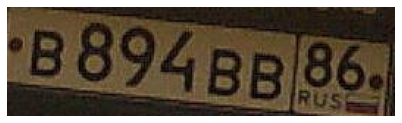

Rotated img:


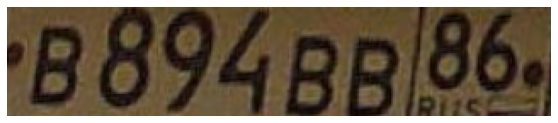

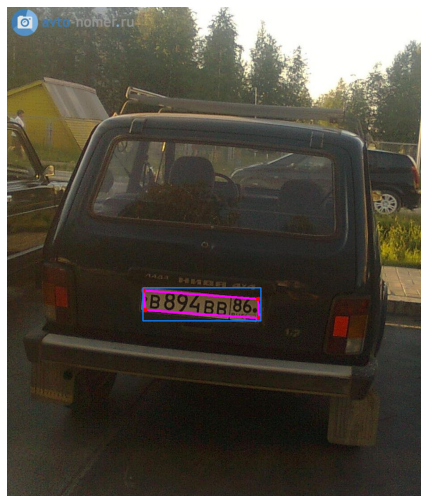

{'boxes': tensor([[304.2802, 631.4304, 568.4113, 705.8981],
         [403.6266, 641.5424, 645.1594, 710.1631]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 'scores': tensor([0.9914, 0.0802], device='cuda:0')}

In [20]:
visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95, my_transforms=my_transforms, mask_thresh=0.55)

### d) Предсказываем bounding box-ы и маску.
 
- С помощью NMS убираем перекрывающиеся предсказания
- Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
- Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box 

In [25]:
THRESHOLD_SCORE = 0.7  # 0.93
THRESHOLD_NMS = 0.2
TRESHOLD_MASK = 0.25

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    masks = prediction['masks']
    before_nms = scores > THRESHOLD_SCORE
    boxes = boxes[before_nms]
    labels = labels[before_nms]
    scores = scores[before_nms]
    masks = masks[before_nms]
    nms_pick = non_max_suppression_fast(boxes, THRESHOLD_NMS)
    boxes = boxes[nms_pick]
    labels = labels[nms_pick]
    scores = scores[nms_pick]
    masks = masks[nms_pick]

    for i in range(len(boxes)):
        x_min, y_min, x_max, y_max = map(int, boxes[i].tolist())
        label = int(labels[i])
        score = float(scores[i])
        mask = masks[i][0, :, :].cpu().numpy()
     
        # В разных версиях opencv этот метод возвращает разное число параметров
        # Оставил для версии colab
        contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
        approx = simplify_contour(contours[0], n_corners=4)
        
        if approx is None:
            x0, y0 = x_min, y_min
            x1, y1 = x_max, y_min
            x2, y2 = x_min, y_max
            x3, y3 = x_max, y_max
        else:
            x0, y0 = approx[0][0][0], approx[0][0][1]
            x1, y1 = approx[1][0][0], approx[1][0][1]
            x2, y2 = approx[2][0][0], approx[2][0][1]
            x3, y3 = approx[3][0][0], approx[3][0][1]
            
        points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

        pred['nums'].append({
            'box': points,
            'bbox': [x_min, y_min, x_max, y_max],
        })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

  0%|          | 0/3188 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
  5%|▌         | 164/3188 [01:00<19:22,  2.60it/s]

simplify_contour didnt coverege


 30%|██▉       | 947/3188 [05:55<13:07,  2.84it/s]

simplify_contour didnt coverege


 97%|█████████▋| 3080/3188 [19:23<00:40,  2.68it/s]

simplify_contour didnt coverege


# 2. Распознаем номера

### a) Датасет для распознавания номеров

Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [23]:
!pip install git+https://github.com/aleju/imgaug
!pip install imagecorruptions
import imgaug.augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-m1a8v807
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-m1a8v807
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=21b76564af217d8c25129a48e7bc8b53529b42d3f4aa0918b41525c815f2618e
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_gt59o8/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 2.1MB 3.4MB/s 


In [26]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Sometimes(1.0, # 0.1
                          iaa.OneOf([
                            iaa.GaussianBlur(sigma=(0, 2.0)),
                            iaa.LinearContrast((0.5, 2.0), per_channel=0.5),
                            iaa.AverageBlur(k=(2, 6)),
                            iaa.MedianBlur(k=(3, 3)),
                            iaa.MotionBlur(k=(3, 7), angle=[-45, 45]),
                            iaa.imgcorruptlike.Snow(severity=1),
                          ])
            ),
            iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
            iaa.Sometimes(0.25,
                            iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                        iaa.CoarseDropout(0.1, size_percent=0.5)])),
            iaa.Sometimes(0.4, iaa.JpegCompression(compression=(30, 95))),
        ])
        
    def __call__(self, image):
        img = image
        img = np.array(img)
        img = self.aug.augment_image(img)
        img = Image.fromarray(img)
        return img

In [27]:
class RightRotate90(object):
    def __init__(self, train=False):
        self.train = train

    def __call__(self, image):
        w, h = image.size
        if h > w:
            image = image.rotate(90, expand=True)

        # if self.train:  # не уверен что это правильно
        #     image = image.rotate(180, expand=True)

        return image

In [39]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):
        img = np.array(img)
        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        img = Image.fromarray(img)
        return img
    
def get_ocr_transforms(train=False):
    my_transforms = []
    my_transforms.append(transforms.ToPILImage())
    my_transforms.append(RightRotate90(train))
    my_transforms.append(Resize(size=(320, 64)))
    if train:
        my_transforms.append(ImgAugTransform())
    my_transforms.append(transforms.ToTensor())
    my_transforms.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]))
    return transforms.Compose(my_transforms)


def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=get_ocr_transforms(True)
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=get_ocr_transforms(False)
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

567

### b) Модель для распознования текста номера

Взял RCNN из семинара

In [40]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [47]:

gc.collect()
torch.cuda.empty_cache()

In [48]:
!nvidia-smi

Fri Jun 19 20:42:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    59W / 149W |    877MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### c) Обучаем модель для распознавания текста номера

In [49]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

In [50]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [51]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(10):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|          | 20/3016 [00:12<30:01,  1.66it/s]

Loss: 5.1310261


  1%|▏         | 40/3016 [00:23<26:09,  1.90it/s]

Loss: 3.4782822


  2%|▏         | 60/3016 [00:34<26:52,  1.83it/s]

Loss: 3.3040862


  3%|▎         | 80/3016 [00:45<27:04,  1.81it/s]

Loss: 3.1846837


  3%|▎         | 100/3016 [00:56<25:55,  1.87it/s]

Loss: 3.0886619


  4%|▍         | 120/3016 [01:08<28:51,  1.67it/s]

Loss: 3.0107951


  5%|▍         | 140/3016 [01:19<26:53,  1.78it/s]

Loss: 2.9375889


  5%|▌         | 160/3016 [01:30<29:00,  1.64it/s]

Loss: 2.8906835


  6%|▌         | 180/3016 [01:42<25:41,  1.84it/s]

Loss: 2.8782012


  7%|▋         | 200/3016 [01:52<24:19,  1.93it/s]

Loss: 2.8693378


  7%|▋         | 220/3016 [02:03<25:47,  1.81it/s]

Loss: 2.8520445


  8%|▊         | 240/3016 [02:15<24:23,  1.90it/s]

Loss: 2.7931490


  9%|▊         | 260/3016 [02:26<24:27,  1.88it/s]

Loss: 2.7590057


  9%|▉         | 280/3016 [02:37<26:54,  1.69it/s]

Loss: 2.7122856


 10%|▉         | 300/3016 [02:48<24:26,  1.85it/s]

Loss: 2.7593257


 11%|█         | 320/3016 [03:00<25:04,  1.79it/s]

Loss: 2.6944910


 11%|█▏        | 340/3016 [03:10<24:36,  1.81it/s]

Loss: 2.6638538


 12%|█▏        | 360/3016 [03:22<25:01,  1.77it/s]

Loss: 2.6654635


 13%|█▎        | 380/3016 [03:32<22:32,  1.95it/s]

Loss: 2.5969948


 13%|█▎        | 400/3016 [03:43<23:57,  1.82it/s]

Loss: 2.5400237


 14%|█▍        | 420/3016 [03:54<22:45,  1.90it/s]

Loss: 2.4491524


 15%|█▍        | 440/3016 [04:05<22:54,  1.87it/s]

Loss: 2.3976212


 15%|█▌        | 460/3016 [04:16<24:52,  1.71it/s]

Loss: 2.2959839


 16%|█▌        | 480/3016 [04:27<23:05,  1.83it/s]

Loss: 2.2568591


 17%|█▋        | 500/3016 [04:38<22:45,  1.84it/s]

Loss: 2.1592712


 17%|█▋        | 520/3016 [04:49<21:40,  1.92it/s]

Loss: 2.0202511


 18%|█▊        | 540/3016 [05:00<21:23,  1.93it/s]

Loss: 1.9821616


 19%|█▊        | 560/3016 [05:11<21:19,  1.92it/s]

Loss: 1.8855318


 19%|█▉        | 580/3016 [05:22<23:00,  1.76it/s]

Loss: 1.8184391


 20%|█▉        | 600/3016 [05:33<22:01,  1.83it/s]

Loss: 1.7338367


 21%|██        | 620/3016 [05:45<24:17,  1.64it/s]

Loss: 1.6531081


 21%|██        | 640/3016 [05:56<23:39,  1.67it/s]

Loss: 1.6335595


 22%|██▏       | 660/3016 [06:07<20:44,  1.89it/s]

Loss: 1.5126879


 23%|██▎       | 680/3016 [06:18<23:01,  1.69it/s]

Loss: 1.4720501


 23%|██▎       | 700/3016 [06:29<20:48,  1.85it/s]

Loss: 1.4433590


 24%|██▍       | 720/3016 [06:41<20:15,  1.89it/s]

Loss: 1.3757958


 25%|██▍       | 740/3016 [06:52<21:20,  1.78it/s]

Loss: 1.3458828


 25%|██▌       | 760/3016 [07:03<20:09,  1.87it/s]

Loss: 1.2245920


 26%|██▌       | 780/3016 [07:14<20:51,  1.79it/s]

Loss: 1.2195910


 27%|██▋       | 800/3016 [07:26<21:33,  1.71it/s]

Loss: 1.2183584


 27%|██▋       | 820/3016 [07:37<21:53,  1.67it/s]

Loss: 1.1963959


 28%|██▊       | 840/3016 [07:48<20:39,  1.76it/s]

Loss: 1.1181682


 29%|██▊       | 860/3016 [07:59<20:39,  1.74it/s]

Loss: 0.9632407


 29%|██▉       | 880/3016 [08:10<19:02,  1.87it/s]

Loss: 0.9634574


 30%|██▉       | 900/3016 [08:22<20:34,  1.71it/s]

Loss: 0.9037946


 31%|███       | 920/3016 [08:33<18:31,  1.89it/s]

Loss: 0.9204289


 31%|███       | 940/3016 [08:44<19:19,  1.79it/s]

Loss: 0.9101895


 32%|███▏      | 960/3016 [08:55<17:25,  1.97it/s]

Loss: 0.8538394


 32%|███▏      | 980/3016 [09:06<17:41,  1.92it/s]

Loss: 0.8118832


 33%|███▎      | 1000/3016 [09:17<18:30,  1.81it/s]

Loss: 0.8781132


 34%|███▍      | 1020/3016 [09:28<18:46,  1.77it/s]

Loss: 0.7908057


 34%|███▍      | 1040/3016 [09:38<16:51,  1.95it/s]

Loss: 0.7525877


 35%|███▌      | 1060/3016 [09:49<16:31,  1.97it/s]

Loss: 0.7892226


 36%|███▌      | 1080/3016 [10:00<17:24,  1.85it/s]

Loss: 0.6920269


 36%|███▋      | 1100/3016 [10:10<17:55,  1.78it/s]

Loss: 0.6798539


 37%|███▋      | 1120/3016 [10:21<17:45,  1.78it/s]

Loss: 0.6985522


 38%|███▊      | 1140/3016 [10:31<16:00,  1.95it/s]

Loss: 0.6201787


 38%|███▊      | 1160/3016 [10:42<16:54,  1.83it/s]

Loss: 0.6936542


 39%|███▉      | 1180/3016 [10:53<17:01,  1.80it/s]

Loss: 0.6157402


 40%|███▉      | 1200/3016 [11:04<15:46,  1.92it/s]

Loss: 0.6041355


 40%|████      | 1220/3016 [11:14<15:08,  1.98it/s]

Loss: 0.5834175


 41%|████      | 1240/3016 [11:25<17:07,  1.73it/s]

Loss: 0.5574877


 42%|████▏     | 1260/3016 [11:36<16:15,  1.80it/s]

Loss: 0.5516073


 42%|████▏     | 1280/3016 [11:47<15:51,  1.82it/s]

Loss: 0.5816806


 43%|████▎     | 1300/3016 [11:58<14:40,  1.95it/s]

Loss: 0.4872442


 44%|████▍     | 1320/3016 [12:09<14:50,  1.90it/s]

Loss: 0.4548545


 44%|████▍     | 1340/3016 [12:20<14:54,  1.87it/s]

Loss: 0.4936300


 45%|████▌     | 1360/3016 [12:31<15:09,  1.82it/s]

Loss: 0.4522360


 46%|████▌     | 1380/3016 [12:43<16:10,  1.69it/s]

Loss: 0.4797687


 46%|████▋     | 1400/3016 [12:54<14:19,  1.88it/s]

Loss: 0.4652489


 47%|████▋     | 1420/3016 [13:05<14:25,  1.84it/s]

Loss: 0.4241256


 48%|████▊     | 1440/3016 [13:16<15:53,  1.65it/s]

Loss: 0.4986830


 48%|████▊     | 1460/3016 [13:27<13:32,  1.91it/s]

Loss: 0.4479894


 49%|████▉     | 1480/3016 [13:38<13:33,  1.89it/s]

Loss: 0.4741790


 50%|████▉     | 1500/3016 [13:49<13:21,  1.89it/s]

Loss: 0.4110556


 50%|█████     | 1520/3016 [14:00<13:15,  1.88it/s]

Loss: 0.4618026


 51%|█████     | 1540/3016 [14:11<13:17,  1.85it/s]

Loss: 0.4055638


 52%|█████▏    | 1560/3016 [14:22<13:30,  1.80it/s]

Loss: 0.3666352


 52%|█████▏    | 1580/3016 [14:33<13:33,  1.77it/s]

Loss: 0.4026868


 53%|█████▎    | 1600/3016 [14:44<12:31,  1.88it/s]

Loss: 0.4852084


 54%|█████▎    | 1620/3016 [14:55<12:17,  1.89it/s]

Loss: 0.3542838


 54%|█████▍    | 1640/3016 [15:06<12:16,  1.87it/s]

Loss: 0.3393628


 55%|█████▌    | 1660/3016 [15:16<12:17,  1.84it/s]

Loss: 0.3408020


 56%|█████▌    | 1680/3016 [15:27<11:26,  1.95it/s]

Loss: 0.3392909


 56%|█████▋    | 1700/3016 [15:38<11:38,  1.88it/s]

Loss: 0.3567899


 57%|█████▋    | 1720/3016 [15:48<12:15,  1.76it/s]

Loss: 0.3823033


 58%|█████▊    | 1740/3016 [15:59<10:50,  1.96it/s]

Loss: 0.3319911


 58%|█████▊    | 1760/3016 [16:09<12:37,  1.66it/s]

Loss: 0.3147584


 59%|█████▉    | 1780/3016 [16:20<10:36,  1.94it/s]

Loss: 0.3134404


 60%|█████▉    | 1800/3016 [16:31<11:34,  1.75it/s]

Loss: 0.3303877


 60%|██████    | 1820/3016 [16:42<10:24,  1.92it/s]

Loss: 0.2847000


 61%|██████    | 1840/3016 [16:52<10:09,  1.93it/s]

Loss: 0.3640621


 62%|██████▏   | 1860/3016 [17:03<10:31,  1.83it/s]

Loss: 0.3239238


 62%|██████▏   | 1880/3016 [17:13<10:31,  1.80it/s]

Loss: 0.3103765


 63%|██████▎   | 1900/3016 [17:24<09:18,  2.00it/s]

Loss: 0.3554452


 64%|██████▎   | 1920/3016 [17:34<09:07,  2.00it/s]

Loss: 0.2898371


 64%|██████▍   | 1940/3016 [17:45<08:47,  2.04it/s]

Loss: 0.2923253


 65%|██████▍   | 1960/3016 [17:56<09:26,  1.86it/s]

Loss: 0.2468586


 66%|██████▌   | 1980/3016 [18:06<09:54,  1.74it/s]

Loss: 0.2890441


 66%|██████▋   | 2000/3016 [18:17<08:53,  1.91it/s]

Loss: 0.3675264


 67%|██████▋   | 2020/3016 [18:28<09:46,  1.70it/s]

Loss: 0.2618144


 68%|██████▊   | 2040/3016 [18:39<08:11,  1.98it/s]

Loss: 0.3410898


 68%|██████▊   | 2060/3016 [18:51<08:40,  1.84it/s]

Loss: 0.3151722


 69%|██████▉   | 2080/3016 [19:01<08:21,  1.87it/s]

Loss: 0.3187177


 70%|██████▉   | 2100/3016 [19:12<08:20,  1.83it/s]

Loss: 0.3518845


 70%|███████   | 2120/3016 [19:23<08:07,  1.84it/s]

Loss: 0.3499270


 71%|███████   | 2140/3016 [19:34<07:55,  1.84it/s]

Loss: 0.2549114


 72%|███████▏  | 2160/3016 [19:44<08:11,  1.74it/s]

Loss: 0.3088568


 72%|███████▏  | 2180/3016 [19:55<07:38,  1.82it/s]

Loss: 0.3020681
Epoch   109: reducing learning rate of group 0 to 2.5000e-04.


 73%|███████▎  | 2200/3016 [20:05<07:19,  1.86it/s]

Loss: 0.2973456


 74%|███████▎  | 2220/3016 [20:17<07:29,  1.77it/s]

Loss: 0.2484871


 74%|███████▍  | 2240/3016 [20:28<07:03,  1.83it/s]

Loss: 0.2437109


 75%|███████▍  | 2260/3016 [20:38<06:43,  1.87it/s]

Loss: 0.2938507


 76%|███████▌  | 2280/3016 [20:50<06:21,  1.93it/s]

Loss: 0.2279740


 76%|███████▋  | 2300/3016 [21:01<06:29,  1.84it/s]

Loss: 0.2383192


 77%|███████▋  | 2320/3016 [21:11<06:20,  1.83it/s]

Loss: 0.1999185


 78%|███████▊  | 2340/3016 [21:22<06:15,  1.80it/s]

Loss: 0.2003087


 78%|███████▊  | 2360/3016 [21:33<05:43,  1.91it/s]

Loss: 0.2136618


 79%|███████▉  | 2380/3016 [21:43<05:33,  1.91it/s]

Loss: 0.2037905


 80%|███████▉  | 2400/3016 [21:53<04:59,  2.06it/s]

Loss: 0.2799649


 80%|████████  | 2420/3016 [22:04<05:15,  1.89it/s]

Loss: 0.2968019


 81%|████████  | 2440/3016 [22:14<04:54,  1.95it/s]

Loss: 0.2802706


 82%|████████▏ | 2460/3016 [22:25<04:50,  1.91it/s]

Loss: 0.2246823


 82%|████████▏ | 2480/3016 [22:36<04:43,  1.89it/s]

Loss: 0.2203905


 83%|████████▎ | 2500/3016 [22:46<04:19,  1.99it/s]

Loss: 0.2711416


 84%|████████▎ | 2520/3016 [22:57<04:27,  1.85it/s]

Loss: 0.2495781


 84%|████████▍ | 2540/3016 [23:07<03:48,  2.08it/s]

Loss: 0.2161604
Epoch   127: reducing learning rate of group 0 to 1.2500e-04.


 85%|████████▍ | 2560/3016 [23:18<04:02,  1.88it/s]

Loss: 0.2302184


 86%|████████▌ | 2580/3016 [23:28<03:40,  1.98it/s]

Loss: 0.2317811


 86%|████████▌ | 2600/3016 [23:40<04:00,  1.73it/s]

Loss: 0.2437077


 87%|████████▋ | 2620/3016 [23:50<03:33,  1.85it/s]

Loss: 0.2141548


 88%|████████▊ | 2640/3016 [24:01<03:17,  1.90it/s]

Loss: 0.2324133


 88%|████████▊ | 2660/3016 [24:12<03:21,  1.77it/s]

Loss: 0.2428005


 89%|████████▉ | 2680/3016 [24:22<02:52,  1.95it/s]

Loss: 0.2078146


 90%|████████▉ | 2700/3016 [24:32<02:46,  1.89it/s]

Loss: 0.1913360


 90%|█████████ | 2720/3016 [24:44<02:49,  1.75it/s]

Loss: 0.1983837


 91%|█████████ | 2740/3016 [24:54<02:29,  1.85it/s]

Loss: 0.2216840


 92%|█████████▏| 2760/3016 [25:06<02:17,  1.86it/s]

Loss: 0.1401962


 92%|█████████▏| 2780/3016 [25:16<02:08,  1.83it/s]

Loss: 0.2086868


 93%|█████████▎| 2800/3016 [25:27<02:00,  1.79it/s]

Loss: 0.2023416


 94%|█████████▎| 2820/3016 [25:39<01:49,  1.79it/s]

Loss: 0.2123639


 94%|█████████▍| 2840/3016 [25:49<01:36,  1.83it/s]

Loss: 0.2017491


 95%|█████████▍| 2860/3016 [26:00<01:25,  1.82it/s]

Loss: 0.1544647


 95%|█████████▌| 2880/3016 [26:11<01:07,  2.01it/s]

Loss: 0.2291670


 96%|█████████▌| 2900/3016 [26:21<01:03,  1.84it/s]

Loss: 0.1748646


 97%|█████████▋| 2920/3016 [26:32<00:52,  1.81it/s]

Loss: 0.2368477


 97%|█████████▋| 2940/3016 [26:43<00:39,  1.92it/s]

Loss: 0.1833429


 98%|█████████▊| 2960/3016 [26:54<00:32,  1.75it/s]

Loss: 0.2040763


 99%|█████████▉| 2980/3016 [27:05<00:19,  1.83it/s]

Loss: 0.2083927
Epoch   149: reducing learning rate of group 0 to 6.2500e-05.


 99%|█████████▉| 3000/3016 [27:15<00:07,  2.10it/s]

Loss: 0.2677154


  0%|          | 0/3016 [00:00<?, ?it/s]

3015 0.9256799348249577


  1%|          | 20/3016 [00:10<26:15,  1.90it/s]

Loss: 0.1836131


  1%|▏         | 40/3016 [00:21<27:24,  1.81it/s]

Loss: 0.1824597


  2%|▏         | 60/3016 [00:31<25:06,  1.96it/s]

Loss: 0.2175272


  3%|▎         | 80/3016 [00:42<25:42,  1.90it/s]

Loss: 0.1569424


  3%|▎         | 100/3016 [00:53<25:17,  1.92it/s]

Loss: 0.2106313


  4%|▍         | 120/3016 [01:03<26:47,  1.80it/s]

Loss: 0.2383642


  5%|▍         | 140/3016 [01:13<22:26,  2.14it/s]

Loss: 0.1709604


  5%|▌         | 160/3016 [01:23<23:42,  2.01it/s]

Loss: 0.2415621


  6%|▌         | 180/3016 [01:34<23:08,  2.04it/s]

Loss: 0.2081839


  7%|▋         | 200/3016 [01:44<25:03,  1.87it/s]

Loss: 0.2034419
Epoch   160: reducing learning rate of group 0 to 3.1250e-05.


  7%|▋         | 220/3016 [01:54<22:54,  2.03it/s]

Loss: 0.2034937


  8%|▊         | 240/3016 [02:05<23:26,  1.97it/s]

Loss: 0.1983437


  9%|▊         | 260/3016 [02:15<25:10,  1.82it/s]

Loss: 0.1568252


  9%|▉         | 280/3016 [02:26<23:55,  1.91it/s]

Loss: 0.2089470


 10%|▉         | 300/3016 [02:36<20:38,  2.19it/s]

Loss: 0.1686380


 11%|█         | 320/3016 [02:46<26:58,  1.67it/s]

Loss: 0.2063746


 11%|█▏        | 340/3016 [02:58<25:40,  1.74it/s]

Loss: 0.2228921


 12%|█▏        | 360/3016 [03:08<22:03,  2.01it/s]

Loss: 0.1662074


 13%|█▎        | 380/3016 [03:19<22:50,  1.92it/s]

Loss: 0.1715634


 13%|█▎        | 400/3016 [03:30<26:00,  1.68it/s]

Loss: 0.2054726


 14%|█▍        | 420/3016 [03:40<25:05,  1.72it/s]

Loss: 0.2012586
Epoch   171: reducing learning rate of group 0 to 1.5625e-05.


 15%|█▍        | 440/3016 [03:51<20:59,  2.05it/s]

Loss: 0.1777906


 15%|█▌        | 460/3016 [04:02<22:51,  1.86it/s]

Loss: 0.1732944


 16%|█▌        | 480/3016 [04:13<23:13,  1.82it/s]

Loss: 0.2062513


 17%|█▋        | 500/3016 [04:24<23:06,  1.81it/s]

Loss: 0.2171553


 17%|█▋        | 520/3016 [04:35<20:23,  2.04it/s]

Loss: 0.1781207


 18%|█▊        | 540/3016 [04:45<22:19,  1.85it/s]

Loss: 0.1499878


 19%|█▊        | 560/3016 [04:56<22:04,  1.85it/s]

Loss: 0.1793058


 19%|█▉        | 580/3016 [05:07<21:43,  1.87it/s]

Loss: 0.2003578


 20%|█▉        | 600/3016 [05:17<23:09,  1.74it/s]

Loss: 0.1790821


 21%|██        | 620/3016 [05:28<21:14,  1.88it/s]

Loss: 0.1757166


 21%|██        | 640/3016 [05:38<20:45,  1.91it/s]

Loss: 0.2054621
Epoch   182: reducing learning rate of group 0 to 7.8125e-06.


 22%|██▏       | 660/3016 [05:49<20:39,  1.90it/s]

Loss: 0.1984537


 23%|██▎       | 680/3016 [06:00<22:32,  1.73it/s]

Loss: 0.2034167


 23%|██▎       | 700/3016 [06:10<20:34,  1.88it/s]

Loss: 0.2134420


 24%|██▍       | 720/3016 [06:21<20:21,  1.88it/s]

Loss: 0.1795763


 25%|██▍       | 740/3016 [06:31<19:55,  1.90it/s]

Loss: 0.1378552


 25%|██▌       | 760/3016 [06:42<21:01,  1.79it/s]

Loss: 0.1831576


 26%|██▌       | 780/3016 [06:52<20:10,  1.85it/s]

Loss: 0.1678347


 27%|██▋       | 800/3016 [07:03<19:48,  1.86it/s]

Loss: 0.1682030


 27%|██▋       | 820/3016 [07:13<18:07,  2.02it/s]

Loss: 0.1483351


 28%|██▊       | 840/3016 [07:23<20:16,  1.79it/s]

Loss: 0.1299783


 29%|██▊       | 860/3016 [07:34<19:05,  1.88it/s]

Loss: 0.2067835


 29%|██▉       | 880/3016 [07:44<18:17,  1.95it/s]

Loss: 0.2127069


 30%|██▉       | 900/3016 [07:54<17:20,  2.03it/s]

Loss: 0.1934298


 31%|███       | 920/3016 [08:05<18:09,  1.92it/s]

Loss: 0.1541111


 31%|███       | 940/3016 [08:15<17:47,  1.95it/s]

Loss: 0.1649864


 32%|███▏      | 960/3016 [08:25<16:52,  2.03it/s]

Loss: 0.1925474


 32%|███▏      | 980/3016 [08:36<18:21,  1.85it/s]

Loss: 0.2014568


 33%|███▎      | 1000/3016 [08:47<18:18,  1.83it/s]

Loss: 0.1834940


 34%|███▍      | 1020/3016 [08:57<16:58,  1.96it/s]

Loss: 0.1584545


 34%|███▍      | 1040/3016 [09:08<16:33,  1.99it/s]

Loss: 0.1785807


 35%|███▌      | 1060/3016 [09:19<17:58,  1.81it/s]

Loss: 0.1523636
Epoch   203: reducing learning rate of group 0 to 3.9063e-06.


 36%|███▌      | 1080/3016 [09:30<18:09,  1.78it/s]

Loss: 0.1891812


 36%|███▋      | 1100/3016 [09:40<16:57,  1.88it/s]

Loss: 0.2461355


 37%|███▋      | 1120/3016 [09:51<16:14,  1.95it/s]

Loss: 0.1982724


 38%|███▊      | 1140/3016 [10:02<16:36,  1.88it/s]

Loss: 0.2228306


 38%|███▊      | 1160/3016 [10:13<16:25,  1.88it/s]

Loss: 0.2011476


 39%|███▉      | 1180/3016 [10:24<15:45,  1.94it/s]

Loss: 0.1983276


 40%|███▉      | 1200/3016 [10:35<16:10,  1.87it/s]

Loss: 0.1963387


 40%|████      | 1220/3016 [10:46<15:07,  1.98it/s]

Loss: 0.1683741


 41%|████      | 1240/3016 [10:57<17:43,  1.67it/s]

Loss: 0.1858777


 42%|████▏     | 1260/3016 [11:07<15:36,  1.88it/s]

Loss: 0.1889866


 42%|████▏     | 1280/3016 [11:18<17:09,  1.69it/s]

Loss: 0.1935807
Epoch   214: reducing learning rate of group 0 to 1.9531e-06.


 43%|████▎     | 1300/3016 [11:28<14:08,  2.02it/s]

Loss: 0.1754240


 44%|████▍     | 1320/3016 [11:39<15:33,  1.82it/s]

Loss: 0.1872401


 44%|████▍     | 1340/3016 [11:50<15:02,  1.86it/s]

Loss: 0.1614296


 45%|████▌     | 1360/3016 [12:01<14:58,  1.84it/s]

Loss: 0.1963073


 46%|████▌     | 1380/3016 [12:12<16:24,  1.66it/s]

Loss: 0.2171215


 46%|████▋     | 1400/3016 [12:23<14:16,  1.89it/s]

Loss: 0.1886944


 47%|████▋     | 1420/3016 [12:33<13:59,  1.90it/s]

Loss: 0.1916509


 48%|████▊     | 1440/3016 [12:44<15:10,  1.73it/s]

Loss: 0.1687650


 48%|████▊     | 1460/3016 [12:54<13:51,  1.87it/s]

Loss: 0.2001028


 49%|████▉     | 1480/3016 [13:05<14:26,  1.77it/s]

Loss: 0.1882785


 50%|████▉     | 1500/3016 [13:15<13:20,  1.89it/s]

Loss: 0.2518854
Epoch   225: reducing learning rate of group 0 to 9.7656e-07.


 50%|█████     | 1520/3016 [13:26<14:08,  1.76it/s]

Loss: 0.1679518


 51%|█████     | 1540/3016 [13:37<13:53,  1.77it/s]

Loss: 0.1680915


 52%|█████▏    | 1560/3016 [13:47<11:50,  2.05it/s]

Loss: 0.1974295


 52%|█████▏    | 1580/3016 [13:58<12:50,  1.86it/s]

Loss: 0.2471789


 53%|█████▎    | 1600/3016 [14:09<12:48,  1.84it/s]

Loss: 0.1465448


 54%|█████▎    | 1620/3016 [14:19<12:22,  1.88it/s]

Loss: 0.1636958


 54%|█████▍    | 1640/3016 [14:30<11:39,  1.97it/s]

Loss: 0.1665284


 55%|█████▌    | 1660/3016 [14:40<12:29,  1.81it/s]

Loss: 0.1529554


 56%|█████▌    | 1680/3016 [14:50<12:12,  1.82it/s]

Loss: 0.1652810


 56%|█████▋    | 1700/3016 [15:01<11:34,  1.90it/s]

Loss: 0.1848256


 57%|█████▋    | 1720/3016 [15:12<11:41,  1.85it/s]

Loss: 0.2159626
Epoch   236: reducing learning rate of group 0 to 4.8828e-07.


 58%|█████▊    | 1740/3016 [15:22<10:37,  2.00it/s]

Loss: 0.2164790


 58%|█████▊    | 1760/3016 [15:34<11:18,  1.85it/s]

Loss: 0.1927276


 59%|█████▉    | 1780/3016 [15:44<10:50,  1.90it/s]

Loss: 0.1608594


 60%|█████▉    | 1800/3016 [15:55<11:19,  1.79it/s]

Loss: 0.1776663


 60%|██████    | 1820/3016 [16:06<10:43,  1.86it/s]

Loss: 0.1645974


 61%|██████    | 1840/3016 [16:17<09:50,  1.99it/s]

Loss: 0.2081187


 62%|██████▏   | 1860/3016 [16:27<09:46,  1.97it/s]

Loss: 0.1875387


 62%|██████▏   | 1880/3016 [16:38<10:39,  1.78it/s]

Loss: 0.1971084


 63%|██████▎   | 1900/3016 [16:49<09:15,  2.01it/s]

Loss: 0.1385004


 64%|██████▎   | 1920/3016 [17:00<09:46,  1.87it/s]

Loss: 0.1887993


 64%|██████▍   | 1940/3016 [17:11<09:40,  1.85it/s]

Loss: 0.2129824
Epoch   247: reducing learning rate of group 0 to 2.4414e-07.


 65%|██████▍   | 1960/3016 [17:22<09:27,  1.86it/s]

Loss: 0.2119506


 66%|██████▌   | 1980/3016 [17:33<09:11,  1.88it/s]

Loss: 0.2068321


 66%|██████▋   | 2000/3016 [17:44<09:36,  1.76it/s]

Loss: 0.2413726


 67%|██████▋   | 2020/3016 [17:54<08:37,  1.93it/s]

Loss: 0.2152110


 68%|██████▊   | 2040/3016 [18:05<08:44,  1.86it/s]

Loss: 0.1884107


 68%|██████▊   | 2060/3016 [18:16<08:52,  1.79it/s]

Loss: 0.1739162


 69%|██████▉   | 2080/3016 [18:27<08:11,  1.91it/s]

Loss: 0.1671638


 70%|██████▉   | 2100/3016 [18:39<08:50,  1.73it/s]

Loss: 0.1732429


 70%|███████   | 2120/3016 [18:50<08:31,  1.75it/s]

Loss: 0.1482658


 71%|███████   | 2140/3016 [19:01<08:04,  1.81it/s]

Loss: 0.1833881


 72%|███████▏  | 2160/3016 [19:11<07:08,  2.00it/s]

Loss: 0.2070239
Epoch   258: reducing learning rate of group 0 to 1.2207e-07.


 72%|███████▏  | 2180/3016 [19:22<06:50,  2.04it/s]

Loss: 0.1888428


 73%|███████▎  | 2200/3016 [19:32<06:59,  1.95it/s]

Loss: 0.1886004


 74%|███████▎  | 2220/3016 [19:42<06:27,  2.05it/s]

Loss: 0.1842292


 74%|███████▍  | 2240/3016 [19:53<06:45,  1.92it/s]

Loss: 0.1666742


 75%|███████▍  | 2260/3016 [20:04<06:57,  1.81it/s]

Loss: 0.2027693


 76%|███████▌  | 2280/3016 [20:14<06:46,  1.81it/s]

Loss: 0.1880700


 76%|███████▋  | 2300/3016 [20:25<06:02,  1.98it/s]

Loss: 0.1508626


 77%|███████▋  | 2320/3016 [20:35<06:13,  1.86it/s]

Loss: 0.1856958


 78%|███████▊  | 2340/3016 [20:46<05:36,  2.01it/s]

Loss: 0.2028842


 78%|███████▊  | 2360/3016 [20:56<05:47,  1.89it/s]

Loss: 0.2009080


 79%|███████▉  | 2380/3016 [21:07<05:29,  1.93it/s]

Loss: 0.2177414
Epoch   269: reducing learning rate of group 0 to 6.1035e-08.


 80%|███████▉  | 2400/3016 [21:18<05:16,  1.94it/s]

Loss: 0.1841376


 80%|████████  | 2420/3016 [21:28<04:44,  2.09it/s]

Loss: 0.1707275


 81%|████████  | 2440/3016 [21:38<04:48,  1.99it/s]

Loss: 0.1615713


 82%|████████▏ | 2460/3016 [21:49<05:18,  1.75it/s]

Loss: 0.1803850


 82%|████████▏ | 2480/3016 [22:00<04:54,  1.82it/s]

Loss: 0.2599394


 83%|████████▎ | 2500/3016 [22:11<04:50,  1.78it/s]

Loss: 0.1943430


 84%|████████▎ | 2520/3016 [22:22<04:28,  1.85it/s]

Loss: 0.1627284


 84%|████████▍ | 2540/3016 [22:32<03:55,  2.02it/s]

Loss: 0.1674892


 85%|████████▍ | 2560/3016 [22:43<04:22,  1.74it/s]

Loss: 0.1924835


 86%|████████▌ | 2580/3016 [22:54<03:57,  1.83it/s]

Loss: 0.1638784


 86%|████████▌ | 2600/3016 [23:04<03:32,  1.96it/s]

Loss: 0.1708438
Epoch   280: reducing learning rate of group 0 to 3.0518e-08.


 87%|████████▋ | 2620/3016 [23:15<03:48,  1.73it/s]

Loss: 0.1930745


 88%|████████▊ | 2640/3016 [23:26<03:13,  1.94it/s]

Loss: 0.1717628


 88%|████████▊ | 2660/3016 [23:37<03:04,  1.93it/s]

Loss: 0.1934384


 89%|████████▉ | 2680/3016 [23:48<03:08,  1.78it/s]

Loss: 0.2092747


 90%|████████▉ | 2700/3016 [23:58<02:39,  1.98it/s]

Loss: 0.1534766


 90%|█████████ | 2720/3016 [24:09<02:32,  1.94it/s]

Loss: 0.1979698


 91%|█████████ | 2740/3016 [24:20<02:32,  1.81it/s]

Loss: 0.2141720


 92%|█████████▏| 2760/3016 [24:31<02:28,  1.72it/s]

Loss: 0.1567143


 92%|█████████▏| 2780/3016 [24:42<02:17,  1.71it/s]

Loss: 0.1623157


 93%|█████████▎| 2800/3016 [24:53<02:01,  1.78it/s]

Loss: 0.2154613


 94%|█████████▎| 2820/3016 [25:04<01:49,  1.78it/s]

Loss: 0.1076760


 94%|█████████▍| 2840/3016 [25:15<01:39,  1.77it/s]

Loss: 0.1592994


 95%|█████████▍| 2860/3016 [25:26<01:21,  1.90it/s]

Loss: 0.1810305


 95%|█████████▌| 2880/3016 [25:36<01:09,  1.96it/s]

Loss: 0.1821824


 96%|█████████▌| 2900/3016 [25:47<00:59,  1.96it/s]

Loss: 0.1718692


 97%|█████████▋| 2920/3016 [25:58<00:50,  1.91it/s]

Loss: 0.1755141


 97%|█████████▋| 2940/3016 [26:08<00:36,  2.06it/s]

Loss: 0.1616378


 98%|█████████▊| 2960/3016 [26:19<00:28,  1.99it/s]

Loss: 0.1932287


 99%|█████████▉| 2980/3016 [26:29<00:18,  1.96it/s]

Loss: 0.1595754


 99%|█████████▉| 3000/3016 [26:40<00:08,  1.90it/s]

Loss: 0.1941552


  0%|          | 0/3016 [00:00<?, ?it/s]

3015 0.18655975602705535


  1%|          | 20/3016 [00:10<26:53,  1.86it/s]

Loss: 0.1922406


  1%|▏         | 40/3016 [00:20<25:04,  1.98it/s]

Loss: 0.1800774
Epoch   302: reducing learning rate of group 0 to 1.5259e-08.


  2%|▏         | 60/3016 [00:30<27:04,  1.82it/s]

Loss: 0.1837468


  3%|▎         | 80/3016 [00:41<25:29,  1.92it/s]

Loss: 0.1775322


  3%|▎         | 100/3016 [00:52<26:44,  1.82it/s]

Loss: 0.1950408


  4%|▍         | 120/3016 [01:02<24:19,  1.98it/s]

Loss: 0.2006293


  5%|▍         | 140/3016 [01:12<24:11,  1.98it/s]

Loss: 0.1734662


  5%|▌         | 160/3016 [01:23<25:06,  1.90it/s]

Loss: 0.1655753


  6%|▌         | 180/3016 [01:33<26:28,  1.79it/s]

Loss: 0.1667148


  7%|▋         | 200/3016 [01:44<26:25,  1.78it/s]

Loss: 0.2394097


  7%|▋         | 220/3016 [01:56<28:36,  1.63it/s]

Loss: 0.1786602


  8%|▊         | 240/3016 [02:06<26:40,  1.73it/s]

Loss: 0.1709439


  9%|▊         | 260/3016 [02:17<23:56,  1.92it/s]

Loss: 0.2156985


  9%|▉         | 280/3016 [02:28<23:32,  1.94it/s]

Loss: 0.1818948


 10%|▉         | 300/3016 [02:38<22:51,  1.98it/s]

Loss: 0.2184124


 11%|█         | 320/3016 [02:49<24:46,  1.81it/s]

Loss: 0.2263345


 11%|█▏        | 340/3016 [03:00<23:43,  1.88it/s]

Loss: 0.1508834


 12%|█▏        | 360/3016 [03:11<23:50,  1.86it/s]

Loss: 0.1796976


 13%|█▎        | 380/3016 [03:21<23:06,  1.90it/s]

Loss: 0.1942264


 13%|█▎        | 400/3016 [03:31<23:25,  1.86it/s]

Loss: 0.1692766


 14%|█▍        | 420/3016 [03:42<25:16,  1.71it/s]

Loss: 0.2040024


 15%|█▍        | 440/3016 [03:53<22:13,  1.93it/s]

Loss: 0.1690385


 15%|█▌        | 460/3016 [04:03<21:15,  2.00it/s]

Loss: 0.1621860


 16%|█▌        | 480/3016 [04:14<24:02,  1.76it/s]

Loss: 0.2215700


 17%|█▋        | 500/3016 [04:24<21:54,  1.91it/s]

Loss: 0.1607030


 17%|█▋        | 520/3016 [04:35<20:36,  2.02it/s]

Loss: 0.2003019


 18%|█▊        | 540/3016 [04:45<22:07,  1.87it/s]

Loss: 0.1971444


 19%|█▊        | 560/3016 [04:55<19:40,  2.08it/s]

Loss: 0.1997718


 19%|█▉        | 580/3016 [05:06<21:43,  1.87it/s]

Loss: 0.1724804


 20%|█▉        | 600/3016 [05:16<20:39,  1.95it/s]

Loss: 0.1900087


 21%|██        | 620/3016 [05:27<21:42,  1.84it/s]

Loss: 0.1865520


 21%|██        | 640/3016 [05:38<21:49,  1.81it/s]

Loss: 0.2095487


 22%|██▏       | 660/3016 [05:49<22:21,  1.76it/s]

Loss: 0.1888502


 23%|██▎       | 680/3016 [05:59<21:52,  1.78it/s]

Loss: 0.1931590


 23%|██▎       | 700/3016 [06:10<20:32,  1.88it/s]

Loss: 0.1956260


 24%|██▍       | 720/3016 [06:21<23:53,  1.60it/s]

Loss: 0.2352399


 25%|██▍       | 740/3016 [06:33<21:58,  1.73it/s]

Loss: 0.1445150


 25%|██▌       | 760/3016 [06:44<20:55,  1.80it/s]

Loss: 0.1805118


 26%|██▌       | 780/3016 [06:55<20:44,  1.80it/s]

Loss: 0.1648263


 27%|██▋       | 800/3016 [07:06<19:05,  1.93it/s]

Loss: 0.1991768


 27%|██▋       | 820/3016 [07:17<20:35,  1.78it/s]

Loss: 0.1617271


 28%|██▊       | 840/3016 [07:28<20:23,  1.78it/s]

Loss: 0.1955770


 29%|██▊       | 860/3016 [07:39<18:33,  1.94it/s]

Loss: 0.1644793


 29%|██▉       | 880/3016 [07:50<20:09,  1.77it/s]

Loss: 0.1641718


 30%|██▉       | 900/3016 [08:02<19:36,  1.80it/s]

Loss: 0.1784964


 31%|███       | 920/3016 [08:12<18:45,  1.86it/s]

Loss: 0.2143244


 31%|███       | 940/3016 [08:23<17:49,  1.94it/s]

Loss: 0.2086202


 32%|███▏      | 960/3016 [08:34<19:02,  1.80it/s]

Loss: 0.1367753


 32%|███▏      | 980/3016 [08:44<17:58,  1.89it/s]

Loss: 0.2218789


 33%|███▎      | 1000/3016 [08:55<17:13,  1.95it/s]

Loss: 0.1713625


 34%|███▍      | 1020/3016 [09:06<18:08,  1.83it/s]

Loss: 0.1869201


 34%|███▍      | 1040/3016 [09:16<17:20,  1.90it/s]

Loss: 0.2187892


 35%|███▌      | 1060/3016 [09:27<16:47,  1.94it/s]

Loss: 0.1690654


 36%|███▌      | 1080/3016 [09:37<17:38,  1.83it/s]

Loss: 0.2105775


 36%|███▋      | 1100/3016 [09:48<16:46,  1.90it/s]

Loss: 0.1297932


 37%|███▋      | 1120/3016 [09:59<16:01,  1.97it/s]

Loss: 0.2011790


 38%|███▊      | 1140/3016 [10:09<16:40,  1.88it/s]

Loss: 0.2129986


 38%|███▊      | 1160/3016 [10:20<15:10,  2.04it/s]

Loss: 0.2040084


 39%|███▉      | 1180/3016 [10:30<17:37,  1.74it/s]

Loss: 0.2064333


 40%|███▉      | 1200/3016 [10:41<16:55,  1.79it/s]

Loss: 0.1481660


 40%|████      | 1220/3016 [10:52<15:26,  1.94it/s]

Loss: 0.1499211


 41%|████      | 1240/3016 [11:03<15:18,  1.93it/s]

Loss: 0.1701644


 42%|████▏     | 1260/3016 [11:13<15:57,  1.83it/s]

Loss: 0.1640514


 42%|████▏     | 1280/3016 [11:24<15:39,  1.85it/s]

Loss: 0.1718342


 43%|████▎     | 1300/3016 [11:34<14:35,  1.96it/s]

Loss: 0.2415262


 44%|████▍     | 1320/3016 [11:45<14:05,  2.01it/s]

Loss: 0.1918961


 44%|████▍     | 1340/3016 [11:55<14:54,  1.87it/s]

Loss: 0.2017326


 45%|████▌     | 1360/3016 [12:06<14:35,  1.89it/s]

Loss: 0.1893711


 46%|████▌     | 1380/3016 [12:17<15:22,  1.77it/s]

Loss: 0.1724035


 46%|████▋     | 1400/3016 [12:28<13:39,  1.97it/s]

Loss: 0.1824388


 47%|████▋     | 1420/3016 [12:39<15:38,  1.70it/s]

Loss: 0.2003770


 48%|████▊     | 1440/3016 [12:49<12:55,  2.03it/s]

Loss: 0.1641939


 48%|████▊     | 1460/3016 [13:00<13:45,  1.88it/s]

Loss: 0.1867367


 49%|████▉     | 1480/3016 [13:11<14:21,  1.78it/s]

Loss: 0.2047610


 50%|████▉     | 1500/3016 [13:21<12:47,  1.98it/s]

Loss: 0.1809879


 50%|█████     | 1520/3016 [13:32<13:40,  1.82it/s]

Loss: 0.1989045


 51%|█████     | 1540/3016 [13:43<13:03,  1.88it/s]

Loss: 0.1484559


 52%|█████▏    | 1560/3016 [13:53<13:15,  1.83it/s]

Loss: 0.1749924


 52%|█████▏    | 1580/3016 [14:04<12:42,  1.88it/s]

Loss: 0.1973277


 53%|█████▎    | 1600/3016 [14:14<12:04,  1.96it/s]

Loss: 0.1721530


 54%|█████▎    | 1620/3016 [14:25<12:22,  1.88it/s]

Loss: 0.2403670


 54%|█████▍    | 1640/3016 [14:37<13:05,  1.75it/s]

Loss: 0.1802512


 55%|█████▌    | 1660/3016 [14:48<12:49,  1.76it/s]

Loss: 0.1731006


 56%|█████▌    | 1680/3016 [14:58<10:58,  2.03it/s]

Loss: 0.1922245


 56%|█████▋    | 1700/3016 [15:08<11:46,  1.86it/s]

Loss: 0.1864342


 57%|█████▋    | 1720/3016 [15:19<10:55,  1.98it/s]

Loss: 0.1737792


 58%|█████▊    | 1740/3016 [15:30<12:27,  1.71it/s]

Loss: 0.1720544


 58%|█████▊    | 1760/3016 [15:40<09:30,  2.20it/s]

Loss: 0.1820917


 59%|█████▉    | 1780/3016 [15:51<11:19,  1.82it/s]

Loss: 0.1881875


 60%|█████▉    | 1800/3016 [16:01<10:30,  1.93it/s]

Loss: 0.1457234


 60%|██████    | 1820/3016 [16:12<10:47,  1.85it/s]

Loss: 0.1581203


 61%|██████    | 1840/3016 [16:22<09:49,  1.99it/s]

Loss: 0.1571855


 62%|██████▏   | 1860/3016 [16:33<10:01,  1.92it/s]

Loss: 0.1563246


 62%|██████▏   | 1880/3016 [16:43<09:38,  1.96it/s]

Loss: 0.1600041


 63%|██████▎   | 1900/3016 [16:53<10:08,  1.83it/s]

Loss: 0.2003713


 64%|██████▎   | 1920/3016 [17:04<09:34,  1.91it/s]

Loss: 0.1543564


 64%|██████▍   | 1940/3016 [17:15<09:27,  1.90it/s]

Loss: 0.1593838


 65%|██████▍   | 1960/3016 [17:25<09:18,  1.89it/s]

Loss: 0.1972226


 66%|██████▌   | 1980/3016 [17:36<09:46,  1.77it/s]

Loss: 0.1885413


 66%|██████▋   | 2000/3016 [17:47<09:11,  1.84it/s]

Loss: 0.1959911


 67%|██████▋   | 2020/3016 [17:58<09:28,  1.75it/s]

Loss: 0.1473372


 68%|██████▊   | 2040/3016 [18:09<08:41,  1.87it/s]

Loss: 0.2128449


 68%|██████▊   | 2060/3016 [18:20<09:12,  1.73it/s]

Loss: 0.1538520


 69%|██████▉   | 2080/3016 [18:30<08:16,  1.89it/s]

Loss: 0.1595213


 70%|██████▉   | 2100/3016 [18:41<08:11,  1.86it/s]

Loss: 0.2120172


 70%|███████   | 2120/3016 [18:53<08:58,  1.66it/s]

Loss: 0.1671811


 71%|███████   | 2140/3016 [19:04<07:53,  1.85it/s]

Loss: 0.1463185


 72%|███████▏  | 2160/3016 [19:15<07:44,  1.84it/s]

Loss: 0.2083752


 72%|███████▏  | 2180/3016 [19:26<07:52,  1.77it/s]

Loss: 0.1707784


 73%|███████▎  | 2200/3016 [19:37<07:35,  1.79it/s]

Loss: 0.1856508


 74%|███████▎  | 2220/3016 [19:47<07:03,  1.88it/s]

Loss: 0.1802797


 74%|███████▍  | 2240/3016 [19:58<06:32,  1.98it/s]

Loss: 0.2262430


 75%|███████▍  | 2260/3016 [20:09<06:43,  1.88it/s]

Loss: 0.1692179


 76%|███████▌  | 2280/3016 [20:20<06:20,  1.94it/s]

Loss: 0.1457092


 76%|███████▋  | 2300/3016 [20:30<06:50,  1.74it/s]

Loss: 0.2430719


 77%|███████▋  | 2320/3016 [20:41<06:29,  1.79it/s]

Loss: 0.1752977


 78%|███████▊  | 2340/3016 [20:52<06:02,  1.86it/s]

Loss: 0.1969322


 78%|███████▊  | 2360/3016 [21:02<05:51,  1.87it/s]

Loss: 0.1562688


 79%|███████▉  | 2380/3016 [21:13<05:30,  1.92it/s]

Loss: 0.1657222


 80%|███████▉  | 2400/3016 [21:24<06:01,  1.70it/s]

Loss: 0.1918580


 80%|████████  | 2420/3016 [21:35<05:00,  1.98it/s]

Loss: 0.1830991


 81%|████████  | 2440/3016 [21:46<04:50,  1.98it/s]

Loss: 0.1682205


 82%|████████▏ | 2460/3016 [21:56<05:18,  1.74it/s]

Loss: 0.1623065


 82%|████████▏ | 2480/3016 [22:07<04:33,  1.96it/s]

Loss: 0.1545215


 83%|████████▎ | 2500/3016 [22:18<04:35,  1.88it/s]

Loss: 0.1726288


 84%|████████▎ | 2520/3016 [22:28<04:25,  1.87it/s]

Loss: 0.1964778


 84%|████████▍ | 2540/3016 [22:39<03:52,  2.05it/s]

Loss: 0.1516780


 85%|████████▍ | 2560/3016 [22:50<04:16,  1.78it/s]

Loss: 0.1942219


 86%|████████▌ | 2580/3016 [23:00<03:58,  1.83it/s]

Loss: 0.1918214


 86%|████████▌ | 2600/3016 [23:10<03:47,  1.83it/s]

Loss: 0.1534869


 87%|████████▋ | 2620/3016 [23:21<03:36,  1.83it/s]

Loss: 0.2125571


 88%|████████▊ | 2640/3016 [23:32<03:29,  1.80it/s]

Loss: 0.1981094


 88%|████████▊ | 2660/3016 [23:42<03:11,  1.86it/s]

Loss: 0.1669780


 89%|████████▉ | 2680/3016 [23:53<02:58,  1.88it/s]

Loss: 0.1462790


 90%|████████▉ | 2700/3016 [24:03<02:44,  1.92it/s]

Loss: 0.2254324


 90%|█████████ | 2720/3016 [24:14<02:38,  1.87it/s]

Loss: 0.2201014


 91%|█████████ | 2740/3016 [24:25<02:26,  1.89it/s]

Loss: 0.2084803


 92%|█████████▏| 2760/3016 [24:36<02:36,  1.64it/s]

Loss: 0.1588187


 92%|█████████▏| 2780/3016 [24:47<02:04,  1.89it/s]

Loss: 0.2145955


 93%|█████████▎| 2800/3016 [24:58<02:01,  1.78it/s]

Loss: 0.1975221


 94%|█████████▎| 2820/3016 [25:09<01:46,  1.85it/s]

Loss: 0.1282344


 94%|█████████▍| 2840/3016 [25:21<01:38,  1.78it/s]

Loss: 0.1852890


 95%|█████████▍| 2860/3016 [25:31<01:25,  1.82it/s]

Loss: 0.1728208


 95%|█████████▌| 2880/3016 [25:42<01:05,  2.06it/s]

Loss: 0.2044965


 96%|█████████▌| 2900/3016 [25:53<01:01,  1.89it/s]

Loss: 0.1693074


 97%|█████████▋| 2920/3016 [26:03<00:49,  1.95it/s]

Loss: 0.1629593


 97%|█████████▋| 2940/3016 [26:14<00:44,  1.70it/s]

Loss: 0.2947950


 98%|█████████▊| 2960/3016 [26:25<00:28,  1.97it/s]

Loss: 0.1822974


 99%|█████████▉| 2980/3016 [26:36<00:17,  2.03it/s]

Loss: 0.1955838


 99%|█████████▉| 3000/3016 [26:46<00:08,  1.90it/s]

Loss: 0.1534029


  0%|          | 0/3016 [00:00<?, ?it/s]

3015 0.184009479988732


  1%|          | 20/3016 [00:10<28:40,  1.74it/s]

Loss: 0.2090302


  1%|▏         | 40/3016 [00:21<26:21,  1.88it/s]

Loss: 0.2010070


  2%|▏         | 60/3016 [00:32<24:57,  1.97it/s]

Loss: 0.1684059


  3%|▎         | 80/3016 [00:43<27:09,  1.80it/s]

Loss: 0.1902115


  3%|▎         | 100/3016 [00:53<25:49,  1.88it/s]

Loss: 0.2005231


  4%|▍         | 120/3016 [01:04<27:36,  1.75it/s]

Loss: 0.1589920


  5%|▍         | 140/3016 [01:15<25:34,  1.87it/s]

Loss: 0.1650519


  5%|▌         | 160/3016 [01:26<26:22,  1.80it/s]

Loss: 0.1820427


  6%|▌         | 180/3016 [01:36<25:15,  1.87it/s]

Loss: 0.2097001


  7%|▋         | 200/3016 [01:46<23:11,  2.02it/s]

Loss: 0.2128575


  7%|▋         | 220/3016 [01:57<25:05,  1.86it/s]

Loss: 0.1958714


  8%|▊         | 240/3016 [02:07<23:35,  1.96it/s]

Loss: 0.2102828


  9%|▊         | 260/3016 [02:17<24:07,  1.90it/s]

Loss: 0.1768633


  9%|▉         | 280/3016 [02:28<24:16,  1.88it/s]

Loss: 0.1778498


 10%|▉         | 300/3016 [02:38<25:08,  1.80it/s]

Loss: 0.1914054


 11%|█         | 320/3016 [02:49<23:39,  1.90it/s]

Loss: 0.2208926


 11%|█▏        | 340/3016 [02:59<24:23,  1.83it/s]

Loss: 0.1767337


 12%|█▏        | 360/3016 [03:09<22:44,  1.95it/s]

Loss: 0.1742035


 13%|█▎        | 380/3016 [03:20<24:04,  1.83it/s]

Loss: 0.1868749


 13%|█▎        | 400/3016 [03:31<23:14,  1.88it/s]

Loss: 0.2353746


 14%|█▍        | 420/3016 [03:42<24:05,  1.80it/s]

Loss: 0.2221822


 15%|█▍        | 440/3016 [03:52<20:34,  2.09it/s]

Loss: 0.1896211


 15%|█▌        | 460/3016 [04:03<22:39,  1.88it/s]

Loss: 0.1616473


 16%|█▌        | 480/3016 [04:14<26:29,  1.60it/s]

Loss: 0.1747050


 17%|█▋        | 500/3016 [04:25<22:37,  1.85it/s]

Loss: 0.1882930


 17%|█▋        | 520/3016 [04:36<22:33,  1.84it/s]

Loss: 0.2262411


 18%|█▊        | 540/3016 [04:47<23:48,  1.73it/s]

Loss: 0.1516550


 19%|█▊        | 560/3016 [04:57<20:45,  1.97it/s]

Loss: 0.2040585


 19%|█▉        | 580/3016 [05:08<22:43,  1.79it/s]

Loss: 0.2434207


 20%|█▉        | 600/3016 [05:19<23:10,  1.74it/s]

Loss: 0.1470126


 21%|██        | 620/3016 [05:30<22:07,  1.80it/s]

Loss: 0.1716558


 21%|██        | 640/3016 [05:41<22:33,  1.76it/s]

Loss: 0.1512967


 22%|██▏       | 660/3016 [05:52<23:26,  1.68it/s]

Loss: 0.1976671


 23%|██▎       | 680/3016 [06:03<19:52,  1.96it/s]

Loss: 0.1893090


 23%|██▎       | 700/3016 [06:14<20:21,  1.90it/s]

Loss: 0.2056512


 24%|██▍       | 720/3016 [06:24<19:20,  1.98it/s]

Loss: 0.1755075


 25%|██▍       | 740/3016 [06:35<20:49,  1.82it/s]

Loss: 0.2106778


 25%|██▌       | 760/3016 [06:46<20:19,  1.85it/s]

Loss: 0.1959999


 26%|██▌       | 780/3016 [06:57<20:33,  1.81it/s]

Loss: 0.1724532


 27%|██▋       | 800/3016 [07:07<19:08,  1.93it/s]

Loss: 0.1807415


 27%|██▋       | 820/3016 [07:18<20:07,  1.82it/s]

Loss: 0.2228012


 28%|██▊       | 840/3016 [07:28<19:11,  1.89it/s]

Loss: 0.1937009


 29%|██▊       | 860/3016 [07:39<19:36,  1.83it/s]

Loss: 0.1538587


 29%|██▉       | 880/3016 [07:49<17:11,  2.07it/s]

Loss: 0.1957732


 30%|██▉       | 900/3016 [07:59<18:24,  1.92it/s]

Loss: 0.2162434


 31%|███       | 920/3016 [08:10<18:47,  1.86it/s]

Loss: 0.1797809


 31%|███       | 940/3016 [08:20<18:55,  1.83it/s]

Loss: 0.1925229


 32%|███▏      | 960/3016 [08:30<17:43,  1.93it/s]

Loss: 0.1993082


 32%|███▏      | 980/3016 [08:41<18:36,  1.82it/s]

Loss: 0.2352632


 33%|███▎      | 1000/3016 [08:51<17:20,  1.94it/s]

Loss: 0.2057674


 34%|███▍      | 1020/3016 [09:01<19:11,  1.73it/s]

Loss: 0.1785222


 34%|███▍      | 1040/3016 [09:12<17:49,  1.85it/s]

Loss: 0.1548926


 35%|███▌      | 1060/3016 [09:23<16:44,  1.95it/s]

Loss: 0.1917657


 36%|███▌      | 1080/3016 [09:34<17:48,  1.81it/s]

Loss: 0.2134837


 36%|███▋      | 1100/3016 [09:45<17:29,  1.83it/s]

Loss: 0.1829353


 37%|███▋      | 1120/3016 [09:55<16:37,  1.90it/s]

Loss: 0.1965742


 38%|███▊      | 1140/3016 [10:06<16:21,  1.91it/s]

Loss: 0.1662325


 38%|███▊      | 1160/3016 [10:17<15:46,  1.96it/s]

Loss: 0.1430439


 39%|███▉      | 1180/3016 [10:28<15:57,  1.92it/s]

Loss: 0.1991172


 40%|███▉      | 1200/3016 [10:38<15:52,  1.91it/s]

Loss: 0.2017971


 40%|████      | 1220/3016 [10:49<16:22,  1.83it/s]

Loss: 0.1581338


 41%|████      | 1240/3016 [11:00<15:54,  1.86it/s]

Loss: 0.1677928


 42%|████▏     | 1260/3016 [11:11<15:45,  1.86it/s]

Loss: 0.1820127


 42%|████▏     | 1280/3016 [11:22<16:16,  1.78it/s]

Loss: 0.1910708


 43%|████▎     | 1300/3016 [11:33<17:03,  1.68it/s]

Loss: 0.2003146


 44%|████▍     | 1320/3016 [11:44<15:48,  1.79it/s]

Loss: 0.1730325


 44%|████▍     | 1340/3016 [11:55<15:28,  1.81it/s]

Loss: 0.1892428


 45%|████▌     | 1360/3016 [12:06<16:00,  1.72it/s]

Loss: 0.1779373


 46%|████▌     | 1380/3016 [12:17<14:06,  1.93it/s]

Loss: 0.1440321


 46%|████▋     | 1400/3016 [12:28<15:23,  1.75it/s]

Loss: 0.2237290


 47%|████▋     | 1420/3016 [12:38<13:56,  1.91it/s]

Loss: 0.1882889


 48%|████▊     | 1440/3016 [12:48<12:09,  2.16it/s]

Loss: 0.1668999


 48%|████▊     | 1460/3016 [12:58<13:54,  1.87it/s]

Loss: 0.1608717


 49%|████▉     | 1480/3016 [13:08<13:26,  1.90it/s]

Loss: 0.1795604


 50%|████▉     | 1500/3016 [13:19<13:43,  1.84it/s]

Loss: 0.1432729


 50%|█████     | 1520/3016 [13:30<13:28,  1.85it/s]

Loss: 0.1515657


 51%|█████     | 1540/3016 [13:39<12:18,  2.00it/s]

Loss: 0.1779241


 52%|█████▏    | 1560/3016 [13:50<12:21,  1.96it/s]

Loss: 0.2102980


 52%|█████▏    | 1580/3016 [14:00<12:06,  1.98it/s]

Loss: 0.1590466


 53%|█████▎    | 1600/3016 [14:11<12:37,  1.87it/s]

Loss: 0.2304625


 54%|█████▎    | 1620/3016 [14:21<11:48,  1.97it/s]

Loss: 0.1876228


 54%|█████▍    | 1640/3016 [14:31<11:59,  1.91it/s]

Loss: 0.2507829


 55%|█████▌    | 1660/3016 [14:42<12:03,  1.87it/s]

Loss: 0.1801619


 56%|█████▌    | 1680/3016 [14:52<10:55,  2.04it/s]

Loss: 0.1736782


 56%|█████▋    | 1700/3016 [15:03<12:54,  1.70it/s]

Loss: 0.2258465


 57%|█████▋    | 1720/3016 [15:14<11:08,  1.94it/s]

Loss: 0.1698796


 58%|█████▊    | 1740/3016 [15:25<11:37,  1.83it/s]

Loss: 0.1921890


 58%|█████▊    | 1760/3016 [15:35<11:53,  1.76it/s]

Loss: 0.1663322


 59%|█████▉    | 1780/3016 [15:46<10:46,  1.91it/s]

Loss: 0.1614324


 60%|█████▉    | 1800/3016 [15:57<10:19,  1.96it/s]

Loss: 0.1435981


 60%|██████    | 1820/3016 [16:08<10:13,  1.95it/s]

Loss: 0.1770171


 61%|██████    | 1840/3016 [16:18<11:49,  1.66it/s]

Loss: 0.1911452


 62%|██████▏   | 1860/3016 [16:28<10:08,  1.90it/s]

Loss: 0.1749674


 62%|██████▏   | 1880/3016 [16:39<09:32,  1.99it/s]

Loss: 0.1723074


 63%|██████▎   | 1900/3016 [16:50<10:12,  1.82it/s]

Loss: 0.1847273


 64%|██████▎   | 1920/3016 [17:00<10:09,  1.80it/s]

Loss: 0.1746748


 64%|██████▍   | 1940/3016 [17:10<09:08,  1.96it/s]

Loss: 0.2245644


 65%|██████▍   | 1960/3016 [17:21<09:36,  1.83it/s]

Loss: 0.1713360


 66%|██████▌   | 1980/3016 [17:31<08:26,  2.04it/s]

Loss: 0.1819497


 66%|██████▋   | 2000/3016 [17:41<08:48,  1.92it/s]

Loss: 0.1986637


 67%|██████▋   | 2020/3016 [17:52<08:55,  1.86it/s]

Loss: 0.2005578


 68%|██████▊   | 2040/3016 [18:02<08:11,  1.99it/s]

Loss: 0.2089945


 68%|██████▊   | 2060/3016 [18:13<08:15,  1.93it/s]

Loss: 0.1829816


 69%|██████▉   | 2080/3016 [18:24<07:55,  1.97it/s]

Loss: 0.1857521


 70%|██████▉   | 2100/3016 [18:34<08:51,  1.72it/s]

Loss: 0.1621201


 70%|███████   | 2120/3016 [18:45<07:59,  1.87it/s]

Loss: 0.1827101


 71%|███████   | 2140/3016 [18:55<08:08,  1.79it/s]

Loss: 0.1815769


 72%|███████▏  | 2160/3016 [19:06<07:11,  1.99it/s]

Loss: 0.1892278


 72%|███████▏  | 2180/3016 [19:17<07:36,  1.83it/s]

Loss: 0.1870335


 73%|███████▎  | 2200/3016 [19:27<07:31,  1.81it/s]

Loss: 0.1617045


 74%|███████▎  | 2220/3016 [19:38<06:44,  1.97it/s]

Loss: 0.1783881


 74%|███████▍  | 2240/3016 [19:48<06:29,  1.99it/s]

Loss: 0.1878902


 75%|███████▍  | 2260/3016 [19:58<06:25,  1.96it/s]

Loss: 0.1724349


 76%|███████▌  | 2280/3016 [20:08<05:56,  2.07it/s]

Loss: 0.1481435


 76%|███████▋  | 2300/3016 [20:19<06:31,  1.83it/s]

Loss: 0.1605308


 77%|███████▋  | 2320/3016 [20:29<05:33,  2.08it/s]

Loss: 0.2249411


 78%|███████▊  | 2340/3016 [20:40<06:15,  1.80it/s]

Loss: 0.1504190


 78%|███████▊  | 2360/3016 [20:50<05:16,  2.07it/s]

Loss: 0.1891970


 79%|███████▉  | 2380/3016 [21:00<05:37,  1.89it/s]

Loss: 0.1622099


 80%|███████▉  | 2400/3016 [21:11<05:15,  1.95it/s]

Loss: 0.1637218


 80%|████████  | 2420/3016 [21:21<04:55,  2.02it/s]

Loss: 0.1805561


 81%|████████  | 2440/3016 [21:32<05:05,  1.89it/s]

Loss: 0.1747484


 82%|████████▏ | 2460/3016 [21:42<04:55,  1.88it/s]

Loss: 0.2306684


 82%|████████▏ | 2480/3016 [21:53<04:47,  1.86it/s]

Loss: 0.1749293


 83%|████████▎ | 2500/3016 [22:03<04:32,  1.89it/s]

Loss: 0.1628302


 84%|████████▎ | 2520/3016 [22:14<04:36,  1.79it/s]

Loss: 0.1973682


 84%|████████▍ | 2540/3016 [22:23<03:39,  2.17it/s]

Loss: 0.2034498


 85%|████████▍ | 2560/3016 [22:33<03:48,  2.00it/s]

Loss: 0.1939951


 86%|████████▌ | 2580/3016 [22:44<04:01,  1.81it/s]

Loss: 0.1550708


 86%|████████▌ | 2600/3016 [22:54<03:37,  1.91it/s]

Loss: 0.1588927


 87%|████████▋ | 2620/3016 [23:05<03:24,  1.94it/s]

Loss: 0.1957348


 88%|████████▊ | 2640/3016 [23:15<03:13,  1.95it/s]

Loss: 0.2666843


 88%|████████▊ | 2660/3016 [23:26<03:00,  1.97it/s]

Loss: 0.2008487


 89%|████████▉ | 2680/3016 [23:36<02:57,  1.89it/s]

Loss: 0.1708542


 90%|████████▉ | 2700/3016 [23:47<02:52,  1.83it/s]

Loss: 0.1903672


 90%|█████████ | 2720/3016 [23:58<02:29,  1.99it/s]

Loss: 0.2002857


 91%|█████████ | 2740/3016 [24:08<02:29,  1.85it/s]

Loss: 0.1497933


 92%|█████████▏| 2760/3016 [24:19<02:16,  1.88it/s]

Loss: 0.1863084


 92%|█████████▏| 2780/3016 [24:30<02:04,  1.90it/s]

Loss: 0.1823476


 93%|█████████▎| 2800/3016 [24:40<01:57,  1.84it/s]

Loss: 0.2246125


 94%|█████████▎| 2820/3016 [24:51<01:44,  1.88it/s]

Loss: 0.1449079


 94%|█████████▍| 2840/3016 [25:01<01:30,  1.94it/s]

Loss: 0.1381469


 95%|█████████▍| 2860/3016 [25:12<01:14,  2.09it/s]

Loss: 0.1945551


 95%|█████████▌| 2880/3016 [25:23<01:07,  2.01it/s]

Loss: 0.1792714


 96%|█████████▌| 2900/3016 [25:33<00:59,  1.94it/s]

Loss: 0.1919061


 97%|█████████▋| 2920/3016 [25:44<00:50,  1.90it/s]

Loss: 0.1663675


 97%|█████████▋| 2940/3016 [25:54<00:38,  1.99it/s]

Loss: 0.1867199


 98%|█████████▊| 2960/3016 [26:05<00:28,  1.97it/s]

Loss: 0.2178001


 99%|█████████▉| 2980/3016 [26:15<00:18,  1.96it/s]

Loss: 0.1234204


 99%|█████████▉| 3000/3016 [26:25<00:08,  1.96it/s]

Loss: 0.1472949


  0%|          | 0/3016 [00:00<?, ?it/s]

3015 0.1848874273895229


  1%|          | 20/3016 [00:10<26:07,  1.91it/s]

Loss: 0.1574124


  1%|▏         | 40/3016 [00:21<25:10,  1.97it/s]

Loss: 0.1949011


  2%|▏         | 60/3016 [00:31<25:52,  1.90it/s]

Loss: 0.1898457


  3%|▎         | 80/3016 [00:41<26:15,  1.86it/s]

Loss: 0.1769232


  3%|▎         | 100/3016 [00:52<25:52,  1.88it/s]

Loss: 0.1764245


  4%|▍         | 120/3016 [01:02<23:59,  2.01it/s]

Loss: 0.1813052


  5%|▍         | 140/3016 [01:12<23:26,  2.04it/s]

Loss: 0.1962479


  5%|▌         | 160/3016 [01:22<23:56,  1.99it/s]

Loss: 0.1935299


  6%|▌         | 180/3016 [01:32<25:15,  1.87it/s]

Loss: 0.1514545


  7%|▋         | 200/3016 [01:43<27:55,  1.68it/s]

Loss: 0.1520245


  7%|▋         | 220/3016 [01:53<23:02,  2.02it/s]

Loss: 0.1493253


  8%|▊         | 240/3016 [02:03<23:55,  1.93it/s]

Loss: 0.1902024


  9%|▊         | 260/3016 [02:14<24:36,  1.87it/s]

Loss: 0.1288712


  9%|▉         | 280/3016 [02:24<23:02,  1.98it/s]

Loss: 0.1920950


 10%|▉         | 300/3016 [02:34<22:59,  1.97it/s]

Loss: 0.2016001


 11%|█         | 320/3016 [02:45<23:11,  1.94it/s]

Loss: 0.1289279


 11%|█▏        | 340/3016 [02:55<21:39,  2.06it/s]

Loss: 0.1860586


 12%|█▏        | 360/3016 [03:06<22:40,  1.95it/s]

Loss: 0.1519933


 13%|█▎        | 380/3016 [03:16<24:48,  1.77it/s]

Loss: 0.2255789


 13%|█▎        | 400/3016 [03:27<23:40,  1.84it/s]

Loss: 0.1861346


 14%|█▍        | 420/3016 [03:38<21:59,  1.97it/s]

Loss: 0.1948937


 15%|█▍        | 440/3016 [03:48<21:19,  2.01it/s]

Loss: 0.2018599


 15%|█▌        | 460/3016 [03:58<22:33,  1.89it/s]

Loss: 0.1391500


 16%|█▌        | 480/3016 [04:08<21:32,  1.96it/s]

Loss: 0.1661568


 17%|█▋        | 500/3016 [04:19<22:48,  1.84it/s]

Loss: 0.1770175


 17%|█▋        | 520/3016 [04:30<22:48,  1.82it/s]

Loss: 0.2149853


 18%|█▊        | 540/3016 [04:41<20:52,  1.98it/s]

Loss: 0.1776328


 19%|█▊        | 560/3016 [04:52<22:17,  1.84it/s]

Loss: 0.1647626


 19%|█▉        | 580/3016 [05:03<21:40,  1.87it/s]

Loss: 0.1560708


 20%|█▉        | 600/3016 [05:13<20:31,  1.96it/s]

Loss: 0.2016012


 21%|██        | 620/3016 [05:24<21:57,  1.82it/s]

Loss: 0.1469777


 21%|██        | 640/3016 [05:35<20:31,  1.93it/s]

Loss: 0.1889262


 22%|██▏       | 660/3016 [05:45<19:57,  1.97it/s]

Loss: 0.1628072


 23%|██▎       | 680/3016 [05:55<21:03,  1.85it/s]

Loss: 0.1613535


 23%|██▎       | 700/3016 [06:05<19:56,  1.94it/s]

Loss: 0.2125974


 24%|██▍       | 720/3016 [06:15<19:21,  1.98it/s]

Loss: 0.2535528


 25%|██▍       | 740/3016 [06:26<18:48,  2.02it/s]

Loss: 0.2485431


 25%|██▌       | 760/3016 [06:37<20:34,  1.83it/s]

Loss: 0.1886571


 26%|██▌       | 780/3016 [06:47<19:27,  1.91it/s]

Loss: 0.1794385


 27%|██▋       | 800/3016 [06:57<19:22,  1.91it/s]

Loss: 0.2157177


 27%|██▋       | 820/3016 [07:08<19:27,  1.88it/s]

Loss: 0.2226596


 28%|██▊       | 840/3016 [07:18<19:23,  1.87it/s]

Loss: 0.1598473


 29%|██▊       | 860/3016 [07:29<19:59,  1.80it/s]

Loss: 0.2021073


 29%|██▉       | 880/3016 [07:40<18:26,  1.93it/s]

Loss: 0.1758356


 30%|██▉       | 900/3016 [07:50<18:23,  1.92it/s]

Loss: 0.1733096


 31%|███       | 920/3016 [08:01<17:44,  1.97it/s]

Loss: 0.1578521


 31%|███       | 940/3016 [08:11<18:14,  1.90it/s]

Loss: 0.1786686


 32%|███▏      | 960/3016 [08:22<18:34,  1.84it/s]

Loss: 0.1529824


 32%|███▏      | 980/3016 [08:32<17:49,  1.90it/s]

Loss: 0.2139501


 33%|███▎      | 1000/3016 [08:43<18:29,  1.82it/s]

Loss: 0.1545133


 34%|███▍      | 1020/3016 [08:54<16:00,  2.08it/s]

Loss: 0.2097170


 34%|███▍      | 1040/3016 [09:04<16:33,  1.99it/s]

Loss: 0.2112962


 35%|███▌      | 1060/3016 [09:15<16:59,  1.92it/s]

Loss: 0.1425153


 36%|███▌      | 1080/3016 [09:25<16:26,  1.96it/s]

Loss: 0.1760877


 36%|███▋      | 1100/3016 [09:36<17:00,  1.88it/s]

Loss: 0.2238677


 37%|███▋      | 1120/3016 [09:46<17:39,  1.79it/s]

Loss: 0.1974550


 38%|███▊      | 1140/3016 [09:57<16:28,  1.90it/s]

Loss: 0.1762217


 38%|███▊      | 1160/3016 [10:08<16:21,  1.89it/s]

Loss: 0.1906748


 39%|███▉      | 1180/3016 [10:18<14:06,  2.17it/s]

Loss: 0.2004552


 40%|███▉      | 1200/3016 [10:28<15:34,  1.94it/s]

Loss: 0.1814921


 40%|████      | 1220/3016 [10:39<15:15,  1.96it/s]

Loss: 0.1850489


 41%|████      | 1240/3016 [10:49<13:43,  2.16it/s]

Loss: 0.1612840


 42%|████▏     | 1260/3016 [10:59<14:42,  1.99it/s]

Loss: 0.1918814


 42%|████▏     | 1280/3016 [11:10<14:52,  1.94it/s]

Loss: 0.1665738


 43%|████▎     | 1300/3016 [11:20<13:56,  2.05it/s]

Loss: 0.1530954


 44%|████▍     | 1320/3016 [11:30<14:19,  1.97it/s]

Loss: 0.1710607


 44%|████▍     | 1340/3016 [11:41<14:18,  1.95it/s]

Loss: 0.2023345


 45%|████▌     | 1360/3016 [11:51<13:38,  2.02it/s]

Loss: 0.1761352


 46%|████▌     | 1380/3016 [12:02<15:18,  1.78it/s]

Loss: 0.1850879


 46%|████▋     | 1400/3016 [12:13<15:02,  1.79it/s]

Loss: 0.1828723


 47%|████▋     | 1420/3016 [12:23<13:55,  1.91it/s]

Loss: 0.2013014


 48%|████▊     | 1440/3016 [12:34<13:42,  1.92it/s]

Loss: 0.1861712


 48%|████▊     | 1460/3016 [12:44<13:08,  1.97it/s]

Loss: 0.2010021


 49%|████▉     | 1480/3016 [12:54<12:40,  2.02it/s]

Loss: 0.1931272


 50%|████▉     | 1500/3016 [13:04<12:46,  1.98it/s]

Loss: 0.1425597


 50%|█████     | 1520/3016 [13:14<13:27,  1.85it/s]

Loss: 0.1782032


 51%|█████     | 1540/3016 [13:25<12:17,  2.00it/s]

Loss: 0.1758097


 52%|█████▏    | 1560/3016 [13:35<13:22,  1.81it/s]

Loss: 0.1866533


 52%|█████▏    | 1580/3016 [13:46<13:57,  1.71it/s]

Loss: 0.1971217


 53%|█████▎    | 1600/3016 [13:57<11:40,  2.02it/s]

Loss: 0.1658144


 54%|█████▎    | 1620/3016 [14:07<11:59,  1.94it/s]

Loss: 0.1496491


 54%|█████▍    | 1640/3016 [14:18<11:01,  2.08it/s]

Loss: 0.1316579


 55%|█████▌    | 1660/3016 [14:28<12:40,  1.78it/s]

Loss: 0.1972326


 56%|█████▌    | 1680/3016 [14:39<12:10,  1.83it/s]

Loss: 0.2035471


 56%|█████▋    | 1700/3016 [14:49<11:20,  1.93it/s]

Loss: 0.1816437


 57%|█████▋    | 1720/3016 [15:00<11:15,  1.92it/s]

Loss: 0.2552547


 58%|█████▊    | 1740/3016 [15:10<10:59,  1.93it/s]

Loss: 0.1656226


 58%|█████▊    | 1760/3016 [15:20<10:32,  1.99it/s]

Loss: 0.2343055


 59%|█████▉    | 1780/3016 [15:32<11:39,  1.77it/s]

Loss: 0.1816559


 60%|█████▉    | 1800/3016 [15:43<13:06,  1.55it/s]

Loss: 0.2039012


 60%|██████    | 1820/3016 [15:54<10:50,  1.84it/s]

Loss: 0.1746806


 61%|██████    | 1840/3016 [16:05<10:43,  1.83it/s]

Loss: 0.1714451


 62%|██████▏   | 1860/3016 [16:15<09:54,  1.94it/s]

Loss: 0.2042692


 62%|██████▏   | 1880/3016 [16:26<09:32,  1.98it/s]

Loss: 0.1655165


 63%|██████▎   | 1900/3016 [16:37<10:06,  1.84it/s]

Loss: 0.1728763


 64%|██████▎   | 1920/3016 [16:47<09:36,  1.90it/s]

Loss: 0.1866332


 64%|██████▍   | 1940/3016 [16:58<10:17,  1.74it/s]

Loss: 0.1627415


 65%|██████▍   | 1960/3016 [17:09<09:04,  1.94it/s]

Loss: 0.2153441


 66%|██████▌   | 1980/3016 [17:20<09:29,  1.82it/s]

Loss: 0.1885105


 66%|██████▋   | 2000/3016 [17:31<08:40,  1.95it/s]

Loss: 0.1582800


 67%|██████▋   | 2020/3016 [17:41<09:03,  1.83it/s]

Loss: 0.1879542


 68%|██████▊   | 2040/3016 [17:52<08:37,  1.89it/s]

Loss: 0.1740783


 68%|██████▊   | 2060/3016 [18:02<08:39,  1.84it/s]

Loss: 0.1591749


 69%|██████▉   | 2080/3016 [18:13<08:24,  1.85it/s]

Loss: 0.1614429


 70%|██████▉   | 2100/3016 [18:23<08:11,  1.86it/s]

Loss: 0.1927505


 70%|███████   | 2120/3016 [18:34<08:16,  1.80it/s]

Loss: 0.1748755


 71%|███████   | 2140/3016 [18:45<07:37,  1.91it/s]

Loss: 0.2063083


 72%|███████▏  | 2160/3016 [18:55<07:32,  1.89it/s]

Loss: 0.1748121


 72%|███████▏  | 2180/3016 [19:06<08:11,  1.70it/s]

Loss: 0.1831673


 73%|███████▎  | 2200/3016 [19:17<07:50,  1.73it/s]

Loss: 0.1709206


 74%|███████▎  | 2220/3016 [19:28<07:16,  1.82it/s]

Loss: 0.1654130


 74%|███████▍  | 2240/3016 [19:38<07:10,  1.80it/s]

Loss: 0.1604239


 75%|███████▍  | 2260/3016 [19:49<07:03,  1.79it/s]

Loss: 0.2016009


 76%|███████▌  | 2280/3016 [20:00<06:34,  1.86it/s]

Loss: 0.1829356


 76%|███████▋  | 2300/3016 [20:11<06:27,  1.85it/s]

Loss: 0.1983843


 77%|███████▋  | 2320/3016 [20:22<05:52,  1.98it/s]

Loss: 0.1866637


 78%|███████▊  | 2340/3016 [20:33<06:24,  1.76it/s]

Loss: 0.1322432


 78%|███████▊  | 2360/3016 [20:43<05:48,  1.88it/s]

Loss: 0.1902704


 79%|███████▉  | 2380/3016 [20:54<05:39,  1.88it/s]

Loss: 0.2092259


 80%|███████▉  | 2400/3016 [21:05<05:06,  2.01it/s]

Loss: 0.1781416


 80%|████████  | 2420/3016 [21:15<04:59,  1.99it/s]

Loss: 0.1618579


 81%|████████  | 2440/3016 [21:25<04:51,  1.97it/s]

Loss: 0.1827987


 82%|████████▏ | 2460/3016 [21:35<05:03,  1.83it/s]

Loss: 0.1660734


 82%|████████▏ | 2480/3016 [21:46<04:26,  2.01it/s]

Loss: 0.2043899


 83%|████████▎ | 2500/3016 [21:57<04:20,  1.98it/s]

Loss: 0.2027970


 84%|████████▎ | 2520/3016 [22:07<04:16,  1.94it/s]

Loss: 0.1296148


 84%|████████▍ | 2540/3016 [22:18<04:16,  1.86it/s]

Loss: 0.2133966


 85%|████████▍ | 2560/3016 [22:28<04:03,  1.87it/s]

Loss: 0.1429517


 86%|████████▌ | 2580/3016 [22:39<04:05,  1.78it/s]

Loss: 0.1890280


 86%|████████▌ | 2600/3016 [22:49<03:30,  1.98it/s]

Loss: 0.2111127


 87%|████████▋ | 2620/3016 [23:00<03:40,  1.79it/s]

Loss: 0.1520975


 88%|████████▊ | 2640/3016 [23:10<03:11,  1.97it/s]

Loss: 0.2282123


 88%|████████▊ | 2660/3016 [23:21<03:05,  1.91it/s]

Loss: 0.2187001


 89%|████████▉ | 2680/3016 [23:31<03:11,  1.76it/s]

Loss: 0.2077539


 90%|████████▉ | 2700/3016 [23:43<03:06,  1.70it/s]

Loss: 0.1696877


 90%|█████████ | 2720/3016 [23:53<02:35,  1.90it/s]

Loss: 0.1872440


 91%|█████████ | 2740/3016 [24:04<02:26,  1.89it/s]

Loss: 0.1386024


 92%|█████████▏| 2760/3016 [24:14<02:06,  2.02it/s]

Loss: 0.2030998


 92%|█████████▏| 2780/3016 [24:24<02:07,  1.85it/s]

Loss: 0.2359949


 93%|█████████▎| 2800/3016 [24:35<02:01,  1.78it/s]

Loss: 0.1969344


 94%|█████████▎| 2820/3016 [24:46<01:40,  1.96it/s]

Loss: 0.1594022


 94%|█████████▍| 2840/3016 [24:56<01:32,  1.91it/s]

Loss: 0.1989935


 95%|█████████▍| 2860/3016 [25:06<01:16,  2.04it/s]

Loss: 0.1411875


 95%|█████████▌| 2880/3016 [25:17<01:16,  1.78it/s]

Loss: 0.2166163


 96%|█████████▌| 2900/3016 [25:27<00:56,  2.04it/s]

Loss: 0.2274677


 97%|█████████▋| 2920/3016 [25:38<00:50,  1.90it/s]

Loss: 0.1843060


 97%|█████████▋| 2940/3016 [25:48<00:39,  1.95it/s]

Loss: 0.1803221


 98%|█████████▊| 2960/3016 [25:58<00:27,  2.04it/s]

Loss: 0.2265206


 99%|█████████▉| 2980/3016 [26:09<00:19,  1.87it/s]

Loss: 0.1986141


 99%|█████████▉| 3000/3016 [26:19<00:08,  1.81it/s]

Loss: 0.1901338


  0%|          | 0/3016 [00:00<?, ?it/s]

3015 0.18355557261422692


  1%|          | 20/3016 [00:10<27:05,  1.84it/s]

Loss: 0.2435901


  1%|▏         | 40/3016 [00:20<25:21,  1.96it/s]

Loss: 0.1601423


  2%|▏         | 60/3016 [00:31<28:56,  1.70it/s]

Loss: 0.2047998


  3%|▎         | 80/3016 [00:42<25:00,  1.96it/s]

Loss: 0.1872985


  3%|▎         | 100/3016 [00:53<25:57,  1.87it/s]

Loss: 0.1857867


  4%|▍         | 120/3016 [01:03<24:01,  2.01it/s]

Loss: 0.1844774


  5%|▍         | 140/3016 [01:13<24:08,  1.99it/s]

Loss: 0.2709310


  5%|▌         | 160/3016 [01:23<25:05,  1.90it/s]

Loss: 0.1256357


  6%|▌         | 180/3016 [01:34<24:32,  1.93it/s]

Loss: 0.1795960


  7%|▋         | 200/3016 [01:45<26:20,  1.78it/s]

Loss: 0.1604863


  7%|▋         | 220/3016 [01:55<25:05,  1.86it/s]

Loss: 0.1770288


  8%|▊         | 240/3016 [02:05<24:04,  1.92it/s]

Loss: 0.1547653


  9%|▊         | 260/3016 [02:16<24:44,  1.86it/s]

Loss: 0.1710702


  9%|▉         | 280/3016 [02:26<23:03,  1.98it/s]

Loss: 0.2038217


 10%|▉         | 300/3016 [02:37<25:41,  1.76it/s]

Loss: 0.1649755


 11%|█         | 320/3016 [02:47<23:04,  1.95it/s]

Loss: 0.1519449


 11%|█▏        | 340/3016 [02:58<22:23,  1.99it/s]

Loss: 0.1901918


 12%|█▏        | 360/3016 [03:09<26:23,  1.68it/s]

Loss: 0.2085379


 13%|█▎        | 380/3016 [03:19<23:24,  1.88it/s]

Loss: 0.1796772


 13%|█▎        | 400/3016 [03:30<20:21,  2.14it/s]

Loss: 0.2124220


 14%|█▍        | 420/3016 [03:40<22:05,  1.96it/s]

Loss: 0.1792522


 15%|█▍        | 440/3016 [03:50<22:25,  1.91it/s]

Loss: 0.1922075


 15%|█▌        | 460/3016 [04:01<20:33,  2.07it/s]

Loss: 0.2101876


 16%|█▌        | 480/3016 [04:12<23:05,  1.83it/s]

Loss: 0.1865800


 17%|█▋        | 500/3016 [04:22<22:07,  1.89it/s]

Loss: 0.1644121


 17%|█▋        | 520/3016 [04:33<20:57,  1.99it/s]

Loss: 0.1800602


 18%|█▊        | 540/3016 [04:43<22:55,  1.80it/s]

Loss: 0.1452215


 19%|█▊        | 560/3016 [04:54<22:38,  1.81it/s]

Loss: 0.1769234


 19%|█▉        | 580/3016 [05:05<21:04,  1.93it/s]

Loss: 0.1962759


 20%|█▉        | 600/3016 [05:15<20:53,  1.93it/s]

Loss: 0.1823461


 21%|██        | 620/3016 [05:26<22:04,  1.81it/s]

Loss: 0.1753837


 21%|██        | 640/3016 [05:36<21:57,  1.80it/s]

Loss: 0.1846087


 22%|██▏       | 660/3016 [05:47<21:47,  1.80it/s]

Loss: 0.1935312


 23%|██▎       | 680/3016 [05:58<20:15,  1.92it/s]

Loss: 0.1801099


 23%|██▎       | 700/3016 [06:08<20:03,  1.92it/s]

Loss: 0.1663240


 24%|██▍       | 720/3016 [06:19<19:10,  2.00it/s]

Loss: 0.2069992


 25%|██▍       | 740/3016 [06:29<19:40,  1.93it/s]

Loss: 0.2255203


 25%|██▌       | 760/3016 [06:40<19:19,  1.95it/s]

Loss: 0.1879130


 26%|██▌       | 780/3016 [06:51<19:21,  1.92it/s]

Loss: 0.1928376


 27%|██▋       | 800/3016 [07:01<18:54,  1.95it/s]

Loss: 0.1924351


 27%|██▋       | 820/3016 [07:12<20:21,  1.80it/s]

Loss: 0.2100114


 28%|██▊       | 840/3016 [07:22<19:07,  1.90it/s]

Loss: 0.1428174


 29%|██▊       | 860/3016 [07:33<18:30,  1.94it/s]

Loss: 0.1686792


 29%|██▉       | 880/3016 [07:42<16:27,  2.16it/s]

Loss: 0.1529083


 30%|██▉       | 900/3016 [07:52<17:34,  2.01it/s]

Loss: 0.1994851


 31%|███       | 920/3016 [08:03<17:41,  1.97it/s]

Loss: 0.1687389


 31%|███       | 940/3016 [08:14<17:11,  2.01it/s]

Loss: 0.1617139


 32%|███▏      | 960/3016 [08:24<17:37,  1.94it/s]

Loss: 0.1745965


 32%|███▏      | 980/3016 [08:34<17:56,  1.89it/s]

Loss: 0.2355072


 33%|███▎      | 1000/3016 [08:45<17:28,  1.92it/s]

Loss: 0.2450114


 34%|███▍      | 1020/3016 [08:55<17:09,  1.94it/s]

Loss: 0.1759136


 34%|███▍      | 1040/3016 [09:05<18:11,  1.81it/s]

Loss: 0.1603057


 35%|███▌      | 1060/3016 [09:16<17:40,  1.84it/s]

Loss: 0.1555714


 36%|███▌      | 1080/3016 [09:27<18:36,  1.73it/s]

Loss: 0.1920762


 36%|███▋      | 1100/3016 [09:37<17:58,  1.78it/s]

Loss: 0.1756865


 37%|███▋      | 1120/3016 [09:48<16:50,  1.88it/s]

Loss: 0.1779715


 38%|███▊      | 1140/3016 [09:59<16:42,  1.87it/s]

Loss: 0.1893470


 38%|███▊      | 1160/3016 [10:09<16:53,  1.83it/s]

Loss: 0.1829067


 39%|███▉      | 1180/3016 [10:19<14:12,  2.15it/s]

Loss: 0.1705571


 40%|███▉      | 1200/3016 [10:30<14:32,  2.08it/s]

Loss: 0.1780078


 40%|████      | 1220/3016 [10:40<14:26,  2.07it/s]

Loss: 0.1848776


 41%|████      | 1240/3016 [10:51<15:27,  1.91it/s]

Loss: 0.1866358


 42%|████▏     | 1260/3016 [11:01<15:46,  1.86it/s]

Loss: 0.1269316


 42%|████▏     | 1280/3016 [11:12<15:56,  1.81it/s]

Loss: 0.1752225


 43%|████▎     | 1300/3016 [11:22<14:23,  1.99it/s]

Loss: 0.1992156


 44%|████▍     | 1320/3016 [11:33<15:46,  1.79it/s]

Loss: 0.2518403


 44%|████▍     | 1340/3016 [11:44<15:23,  1.81it/s]

Loss: 0.1423751


 45%|████▌     | 1360/3016 [11:54<16:04,  1.72it/s]

Loss: 0.1849799


 46%|████▌     | 1380/3016 [12:05<13:58,  1.95it/s]

Loss: 0.1563617


 46%|████▋     | 1400/3016 [12:15<13:36,  1.98it/s]

Loss: 0.1525771


 47%|████▋     | 1420/3016 [12:25<13:59,  1.90it/s]

Loss: 0.1435357


 48%|████▊     | 1440/3016 [12:36<14:26,  1.82it/s]

Loss: 0.1732460


 48%|████▊     | 1460/3016 [12:46<13:06,  1.98it/s]

Loss: 0.1685956


 49%|████▉     | 1480/3016 [12:57<13:30,  1.90it/s]

Loss: 0.1820652


 50%|████▉     | 1500/3016 [13:07<12:56,  1.95it/s]

Loss: 0.1677056


 50%|█████     | 1520/3016 [13:18<13:04,  1.91it/s]

Loss: 0.2331741


 51%|█████     | 1540/3016 [13:28<12:50,  1.92it/s]

Loss: 0.1660523


 52%|█████▏    | 1560/3016 [13:38<12:15,  1.98it/s]

Loss: 0.2022972


 52%|█████▏    | 1580/3016 [13:48<12:11,  1.96it/s]

Loss: 0.1483582


 53%|█████▎    | 1600/3016 [13:59<13:08,  1.80it/s]

Loss: 0.1920733


 54%|█████▎    | 1620/3016 [14:10<12:14,  1.90it/s]

Loss: 0.2018196


 54%|█████▍    | 1640/3016 [14:20<12:39,  1.81it/s]

Loss: 0.1564721


 55%|█████▌    | 1660/3016 [14:31<12:14,  1.85it/s]

Loss: 0.1852098


 56%|█████▌    | 1680/3016 [14:41<12:18,  1.81it/s]

Loss: 0.1957792


 56%|█████▋    | 1700/3016 [14:52<11:18,  1.94it/s]

Loss: 0.2016811


 57%|█████▋    | 1720/3016 [15:02<10:47,  2.00it/s]

Loss: 0.1842958


 58%|█████▊    | 1740/3016 [15:12<11:06,  1.91it/s]

Loss: 0.1377386


 58%|█████▊    | 1760/3016 [15:23<10:54,  1.92it/s]

Loss: 0.1934061


 59%|█████▉    | 1780/3016 [15:34<11:21,  1.81it/s]

Loss: 0.1778398


 60%|█████▉    | 1800/3016 [15:44<11:03,  1.83it/s]

Loss: 0.1742253


 60%|██████    | 1820/3016 [15:55<11:35,  1.72it/s]

Loss: 0.1696768


 61%|██████    | 1840/3016 [16:06<10:39,  1.84it/s]

Loss: 0.1795567


 62%|██████▏   | 1860/3016 [16:16<09:36,  2.00it/s]

Loss: 0.2047504


 62%|██████▏   | 1880/3016 [16:27<10:11,  1.86it/s]

Loss: 0.1941013


 63%|██████▎   | 1900/3016 [16:37<09:06,  2.04it/s]

Loss: 0.1789028


 64%|██████▎   | 1920/3016 [16:47<09:16,  1.97it/s]

Loss: 0.2158666


 64%|██████▍   | 1940/3016 [16:57<08:28,  2.12it/s]

Loss: 0.1796905


 65%|██████▍   | 1960/3016 [17:08<10:11,  1.73it/s]

Loss: 0.1806352


 66%|██████▌   | 1980/3016 [17:19<09:11,  1.88it/s]

Loss: 0.1856096


 66%|██████▋   | 2000/3016 [17:29<08:38,  1.96it/s]

Loss: 0.1856947


 67%|██████▋   | 2020/3016 [17:40<08:52,  1.87it/s]

Loss: 0.1720257


 68%|██████▊   | 2040/3016 [17:50<08:17,  1.96it/s]

Loss: 0.1952019


 68%|██████▊   | 2060/3016 [18:00<08:45,  1.82it/s]

Loss: 0.1920645


 69%|██████▉   | 2080/3016 [18:11<08:27,  1.84it/s]

Loss: 0.1595991


 70%|██████▉   | 2100/3016 [18:21<07:54,  1.93it/s]

Loss: 0.2099089


 70%|███████   | 2120/3016 [18:31<07:16,  2.05it/s]

Loss: 0.1522062


 71%|███████   | 2140/3016 [18:42<07:49,  1.86it/s]

Loss: 0.1737377


 72%|███████▏  | 2160/3016 [18:52<07:30,  1.90it/s]

Loss: 0.1949890


 72%|███████▏  | 2180/3016 [19:03<07:34,  1.84it/s]

Loss: 0.2147409


 73%|███████▎  | 2200/3016 [19:13<06:49,  1.99it/s]

Loss: 0.1668622


 74%|███████▎  | 2220/3016 [19:24<07:04,  1.88it/s]

Loss: 0.2074359


 74%|███████▍  | 2240/3016 [19:34<07:03,  1.83it/s]

Loss: 0.1820351


 75%|███████▍  | 2260/3016 [19:45<06:34,  1.92it/s]

Loss: 0.1685248


 76%|███████▌  | 2280/3016 [19:56<06:28,  1.90it/s]

Loss: 0.1531345


 76%|███████▋  | 2300/3016 [20:06<06:35,  1.81it/s]

Loss: 0.1531390


 77%|███████▋  | 2320/3016 [20:17<06:49,  1.70it/s]

Loss: 0.1493391


 78%|███████▊  | 2340/3016 [20:28<05:45,  1.95it/s]

Loss: 0.1707869


 78%|███████▊  | 2360/3016 [20:38<05:28,  2.00it/s]

Loss: 0.1578118


 79%|███████▉  | 2380/3016 [20:49<05:34,  1.90it/s]

Loss: 0.1898985


 80%|███████▉  | 2400/3016 [21:00<05:54,  1.74it/s]

Loss: 0.2203679


 80%|████████  | 2420/3016 [21:11<05:12,  1.91it/s]

Loss: 0.1923440


 81%|████████  | 2440/3016 [21:21<04:55,  1.95it/s]

Loss: 0.2308919


 82%|████████▏ | 2460/3016 [21:32<04:49,  1.92it/s]

Loss: 0.2210779


 82%|████████▏ | 2480/3016 [21:42<04:36,  1.94it/s]

Loss: 0.1774391


 83%|████████▎ | 2500/3016 [21:53<04:49,  1.78it/s]

Loss: 0.1950446


 84%|████████▎ | 2520/3016 [22:04<04:16,  1.94it/s]

Loss: 0.1865534


 84%|████████▍ | 2540/3016 [22:15<04:39,  1.70it/s]

Loss: 0.2142544


 85%|████████▍ | 2560/3016 [22:25<03:58,  1.91it/s]

Loss: 0.1989538


 86%|████████▌ | 2580/3016 [22:36<03:49,  1.90it/s]

Loss: 0.2364390


 86%|████████▌ | 2600/3016 [22:46<03:35,  1.93it/s]

Loss: 0.1963407


 87%|████████▋ | 2620/3016 [22:57<03:28,  1.90it/s]

Loss: 0.1840472


 88%|████████▊ | 2640/3016 [23:07<03:15,  1.93it/s]

Loss: 0.1452113


 88%|████████▊ | 2660/3016 [23:18<03:18,  1.79it/s]

Loss: 0.2460766


 89%|████████▉ | 2680/3016 [23:29<03:12,  1.74it/s]

Loss: 0.1403774


 90%|████████▉ | 2700/3016 [23:40<02:42,  1.95it/s]

Loss: 0.1733434


 90%|█████████ | 2720/3016 [23:51<02:37,  1.88it/s]

Loss: 0.1790739


 91%|█████████ | 2740/3016 [24:01<02:15,  2.04it/s]

Loss: 0.1998207


 92%|█████████▏| 2760/3016 [24:12<02:19,  1.83it/s]

Loss: 0.1650514


 92%|█████████▏| 2780/3016 [24:22<02:02,  1.92it/s]

Loss: 0.1713440


 93%|█████████▎| 2800/3016 [24:33<02:09,  1.67it/s]

Loss: 0.1978267


 94%|█████████▎| 2820/3016 [24:44<01:42,  1.91it/s]

Loss: 0.1732960


 94%|█████████▍| 2840/3016 [24:54<01:28,  1.99it/s]

Loss: 0.1837700


 95%|█████████▍| 2860/3016 [25:04<01:18,  1.98it/s]

Loss: 0.2445824


 95%|█████████▌| 2880/3016 [25:14<01:11,  1.91it/s]

Loss: 0.2135172


 96%|█████████▌| 2900/3016 [25:25<01:00,  1.91it/s]

Loss: 0.1755098


 97%|█████████▋| 2920/3016 [25:36<00:48,  1.97it/s]

Loss: 0.2149606


 97%|█████████▋| 2940/3016 [25:46<00:38,  1.99it/s]

Loss: 0.2034056


 98%|█████████▊| 2960/3016 [25:57<00:29,  1.87it/s]

Loss: 0.1729342


 99%|█████████▉| 2980/3016 [26:07<00:19,  1.89it/s]

Loss: 0.1399388


 99%|█████████▉| 3000/3016 [26:18<00:08,  1.94it/s]

Loss: 0.1737453


  0%|          | 0/3016 [00:00<?, ?it/s]

3015 0.1844392970898522


  1%|          | 20/3016 [00:10<26:55,  1.85it/s]

Loss: 0.1691675


  1%|▏         | 40/3016 [00:21<26:35,  1.87it/s]

Loss: 0.1897564


  2%|▏         | 60/3016 [00:31<26:46,  1.84it/s]

Loss: 0.1874404


  3%|▎         | 80/3016 [00:42<25:17,  1.93it/s]

Loss: 0.1656992


  3%|▎         | 100/3016 [00:52<25:33,  1.90it/s]

Loss: 0.2027096


  4%|▍         | 120/3016 [01:03<27:30,  1.75it/s]

Loss: 0.1719407


  5%|▍         | 140/3016 [01:13<24:16,  1.97it/s]

Loss: 0.1389238


  5%|▌         | 160/3016 [01:24<26:13,  1.81it/s]

Loss: 0.1885057


  6%|▌         | 180/3016 [01:35<25:17,  1.87it/s]

Loss: 0.2144877


  7%|▋         | 200/3016 [01:47<26:04,  1.80it/s]

Loss: 0.2065699


  7%|▋         | 220/3016 [01:57<25:38,  1.82it/s]

Loss: 0.1484528


  8%|▊         | 240/3016 [02:08<23:07,  2.00it/s]

Loss: 0.1820354


  9%|▊         | 260/3016 [02:18<22:54,  2.00it/s]

Loss: 0.1954518


  9%|▉         | 280/3016 [02:29<24:26,  1.87it/s]

Loss: 0.2118771


 10%|▉         | 300/3016 [02:39<23:26,  1.93it/s]

Loss: 0.1718905


 11%|█         | 320/3016 [02:49<23:11,  1.94it/s]

Loss: 0.2034553


 11%|█▏        | 340/3016 [03:00<23:50,  1.87it/s]

Loss: 0.2092821


 12%|█▏        | 360/3016 [03:10<22:50,  1.94it/s]

Loss: 0.1523940


 13%|█▎        | 380/3016 [03:21<24:56,  1.76it/s]

Loss: 0.1670524


 13%|█▎        | 400/3016 [03:32<23:05,  1.89it/s]

Loss: 0.1372181


 14%|█▍        | 420/3016 [03:42<20:14,  2.14it/s]

Loss: 0.1883945


 15%|█▍        | 440/3016 [03:53<21:32,  1.99it/s]

Loss: 0.1748220


 15%|█▌        | 460/3016 [04:03<21:26,  1.99it/s]

Loss: 0.1606470


 16%|█▌        | 480/3016 [04:14<21:18,  1.98it/s]

Loss: 0.2047344


 17%|█▋        | 500/3016 [04:25<20:57,  2.00it/s]

Loss: 0.1885975


 17%|█▋        | 520/3016 [04:36<22:27,  1.85it/s]

Loss: 0.1866253


 18%|█▊        | 540/3016 [04:47<23:00,  1.79it/s]

Loss: 0.1870388


 19%|█▊        | 560/3016 [04:58<22:27,  1.82it/s]

Loss: 0.1960899


 19%|█▉        | 580/3016 [05:09<23:05,  1.76it/s]

Loss: 0.1846168


 20%|█▉        | 600/3016 [05:20<22:39,  1.78it/s]

Loss: 0.2188628


 21%|██        | 620/3016 [05:32<22:07,  1.81it/s]

Loss: 0.1691292


 21%|██        | 640/3016 [05:42<20:30,  1.93it/s]

Loss: 0.1479061


 22%|██▏       | 660/3016 [05:53<20:19,  1.93it/s]

Loss: 0.1687857


 23%|██▎       | 680/3016 [06:04<19:31,  1.99it/s]

Loss: 0.1882624


 23%|██▎       | 700/3016 [06:15<21:20,  1.81it/s]

Loss: 0.1675857


 24%|██▍       | 720/3016 [06:26<21:23,  1.79it/s]

Loss: 0.2041430


 25%|██▍       | 740/3016 [06:38<22:17,  1.70it/s]

Loss: 0.2032238


 25%|██▌       | 760/3016 [06:49<20:41,  1.82it/s]

Loss: 0.1690817


 26%|██▌       | 780/3016 [06:59<18:30,  2.01it/s]

Loss: 0.1747838


 27%|██▋       | 800/3016 [07:10<19:36,  1.88it/s]

Loss: 0.1717941


 27%|██▋       | 820/3016 [07:20<19:01,  1.92it/s]

Loss: 0.2054301


 28%|██▊       | 840/3016 [07:31<21:32,  1.68it/s]

Loss: 0.2083905


 29%|██▊       | 860/3016 [07:42<18:23,  1.95it/s]

Loss: 0.1589859


 29%|██▉       | 880/3016 [07:53<19:54,  1.79it/s]

Loss: 0.1487315


 30%|██▉       | 900/3016 [08:03<19:11,  1.84it/s]

Loss: 0.1648009


 31%|███       | 920/3016 [08:14<19:44,  1.77it/s]

Loss: 0.1395622


 31%|███       | 940/3016 [08:25<18:44,  1.85it/s]

Loss: 0.1833080


 32%|███▏      | 960/3016 [08:36<18:38,  1.84it/s]

Loss: 0.1769833


 32%|███▏      | 980/3016 [08:47<18:22,  1.85it/s]

Loss: 0.1786825


 33%|███▎      | 1000/3016 [08:58<17:32,  1.92it/s]

Loss: 0.1641194


 34%|███▍      | 1020/3016 [09:09<18:29,  1.80it/s]

Loss: 0.1944645


 34%|███▍      | 1040/3016 [09:19<18:17,  1.80it/s]

Loss: 0.2111964


 35%|███▌      | 1060/3016 [09:30<17:59,  1.81it/s]

Loss: 0.1703664


 36%|███▌      | 1080/3016 [09:41<17:51,  1.81it/s]

Loss: 0.1321658


 36%|███▋      | 1100/3016 [09:53<18:08,  1.76it/s]

Loss: 0.1591539


 37%|███▋      | 1120/3016 [10:04<17:09,  1.84it/s]

Loss: 0.1640134


 38%|███▊      | 1140/3016 [10:15<16:50,  1.86it/s]

Loss: 0.2035830


 38%|███▊      | 1160/3016 [10:26<17:05,  1.81it/s]

Loss: 0.2050235


 39%|███▉      | 1180/3016 [10:37<16:58,  1.80it/s]

Loss: 0.1552667


 40%|███▉      | 1200/3016 [10:48<17:07,  1.77it/s]

Loss: 0.1833757


 40%|████      | 1220/3016 [10:59<14:32,  2.06it/s]

Loss: 0.2425572


 41%|████      | 1240/3016 [11:10<16:51,  1.76it/s]

Loss: 0.2185838


 42%|████▏     | 1260/3016 [11:21<15:16,  1.92it/s]

Loss: 0.1827287


 42%|████▏     | 1280/3016 [11:32<15:57,  1.81it/s]

Loss: 0.1917536


 43%|████▎     | 1300/3016 [11:42<14:07,  2.02it/s]

Loss: 0.2052297


 44%|████▍     | 1320/3016 [11:53<16:06,  1.76it/s]

Loss: 0.2112307


 44%|████▍     | 1340/3016 [12:04<16:10,  1.73it/s]

Loss: 0.1891495


 45%|████▌     | 1360/3016 [12:15<15:08,  1.82it/s]

Loss: 0.1896494


 46%|████▌     | 1380/3016 [12:26<14:05,  1.94it/s]

Loss: 0.1907946


 46%|████▋     | 1400/3016 [12:37<15:44,  1.71it/s]

Loss: 0.1614911


 47%|████▋     | 1420/3016 [12:48<14:21,  1.85it/s]

Loss: 0.1594585


 48%|████▊     | 1440/3016 [12:59<15:11,  1.73it/s]

Loss: 0.1938977


 48%|████▊     | 1460/3016 [13:10<14:27,  1.79it/s]

Loss: 0.1928603


 49%|████▉     | 1480/3016 [13:20<13:21,  1.92it/s]

Loss: 0.1761060


 50%|████▉     | 1500/3016 [13:32<14:18,  1.77it/s]

Loss: 0.1938886


 50%|█████     | 1520/3016 [13:43<13:39,  1.82it/s]

Loss: 0.2400256


 51%|█████     | 1540/3016 [13:54<14:38,  1.68it/s]

Loss: 0.1824416


 52%|█████▏    | 1560/3016 [14:06<14:02,  1.73it/s]

Loss: 0.1845381


 52%|█████▏    | 1580/3016 [14:17<13:02,  1.84it/s]

Loss: 0.1545938


 53%|█████▎    | 1600/3016 [14:27<12:51,  1.84it/s]

Loss: 0.1895456


 54%|█████▎    | 1620/3016 [14:39<13:46,  1.69it/s]

Loss: 0.1774700


 54%|█████▍    | 1640/3016 [14:49<12:09,  1.89it/s]

Loss: 0.2240625


 55%|█████▌    | 1660/3016 [15:01<13:16,  1.70it/s]

Loss: 0.1841680


 56%|█████▌    | 1680/3016 [15:12<11:47,  1.89it/s]

Loss: 0.1535808


 56%|█████▋    | 1700/3016 [15:23<11:57,  1.83it/s]

Loss: 0.1990353


 57%|█████▋    | 1720/3016 [15:34<11:50,  1.82it/s]

Loss: 0.1843248


 58%|█████▊    | 1740/3016 [15:45<11:30,  1.85it/s]

Loss: 0.2552577


 58%|█████▊    | 1760/3016 [15:56<10:39,  1.96it/s]

Loss: 0.1606630


 59%|█████▉    | 1780/3016 [16:08<11:54,  1.73it/s]

Loss: 0.2063947


 60%|█████▉    | 1800/3016 [16:19<11:09,  1.82it/s]

Loss: 0.1673244


 60%|██████    | 1820/3016 [16:29<10:47,  1.85it/s]

Loss: 0.1880558


 61%|██████    | 1840/3016 [16:40<10:48,  1.81it/s]

Loss: 0.1998732


 62%|██████▏   | 1860/3016 [16:52<11:18,  1.70it/s]

Loss: 0.1891340


 62%|██████▏   | 1880/3016 [17:03<10:05,  1.87it/s]

Loss: 0.1950091


 63%|██████▎   | 1900/3016 [17:14<09:46,  1.90it/s]

Loss: 0.1833908


 64%|██████▎   | 1920/3016 [17:24<10:20,  1.77it/s]

Loss: 0.1477382


 64%|██████▍   | 1940/3016 [17:35<09:43,  1.84it/s]

Loss: 0.2320862


 65%|██████▍   | 1960/3016 [17:46<09:10,  1.92it/s]

Loss: 0.1654374


 66%|██████▌   | 1980/3016 [17:57<09:44,  1.77it/s]

Loss: 0.1507293


 66%|██████▋   | 2000/3016 [18:08<09:07,  1.86it/s]

Loss: 0.1325754


 67%|██████▋   | 2020/3016 [18:19<08:42,  1.91it/s]

Loss: 0.1440320


 68%|██████▊   | 2040/3016 [18:30<08:49,  1.84it/s]

Loss: 0.1734871


 68%|██████▊   | 2060/3016 [18:40<08:40,  1.84it/s]

Loss: 0.2064243


 69%|██████▉   | 2080/3016 [18:51<07:59,  1.95it/s]

Loss: 0.1556336


 70%|██████▉   | 2100/3016 [19:02<08:27,  1.81it/s]

Loss: 0.1699799


 70%|███████   | 2120/3016 [19:13<07:46,  1.92it/s]

Loss: 0.1767233


 71%|███████   | 2140/3016 [19:23<07:26,  1.96it/s]

Loss: 0.2026639


 72%|███████▏  | 2160/3016 [19:34<07:04,  2.02it/s]

Loss: 0.1879475


 72%|███████▏  | 2180/3016 [19:46<07:18,  1.91it/s]

Loss: 0.1836331


 73%|███████▎  | 2200/3016 [19:57<07:04,  1.92it/s]

Loss: 0.1878970


 74%|███████▎  | 2220/3016 [20:08<07:51,  1.69it/s]

Loss: 0.1914386


 74%|███████▍  | 2240/3016 [20:20<08:28,  1.53it/s]

Loss: 0.2152768


 75%|███████▍  | 2260/3016 [20:31<06:27,  1.95it/s]

Loss: 0.1353142


 76%|███████▌  | 2280/3016 [20:42<06:45,  1.82it/s]

Loss: 0.1843597


 76%|███████▋  | 2300/3016 [20:53<06:51,  1.74it/s]

Loss: 0.1608687


 77%|███████▋  | 2320/3016 [21:04<06:14,  1.86it/s]

Loss: 0.2230310


 78%|███████▊  | 2340/3016 [21:15<06:28,  1.74it/s]

Loss: 0.1612148


 78%|███████▊  | 2360/3016 [21:26<06:08,  1.78it/s]

Loss: 0.1757034


 79%|███████▉  | 2380/3016 [21:38<05:44,  1.85it/s]

Loss: 0.1836706


 80%|███████▉  | 2400/3016 [21:49<05:28,  1.87it/s]

Loss: 0.2283660


 80%|████████  | 2420/3016 [22:00<06:15,  1.59it/s]

Loss: 0.1892676


 81%|████████  | 2440/3016 [22:11<05:24,  1.78it/s]

Loss: 0.1876314


 82%|████████▏ | 2460/3016 [22:22<04:45,  1.95it/s]

Loss: 0.1764147


 82%|████████▏ | 2480/3016 [22:33<05:03,  1.76it/s]

Loss: 0.1998526


 83%|████████▎ | 2500/3016 [22:43<04:40,  1.84it/s]

Loss: 0.1829099


 84%|████████▎ | 2520/3016 [22:53<04:21,  1.90it/s]

Loss: 0.1580082


 84%|████████▍ | 2540/3016 [23:04<04:13,  1.88it/s]

Loss: 0.1870722


 85%|████████▍ | 2560/3016 [23:14<04:06,  1.85it/s]

Loss: 0.2100891


 86%|████████▌ | 2580/3016 [23:25<04:00,  1.82it/s]

Loss: 0.1670612


 86%|████████▌ | 2600/3016 [23:35<03:36,  1.92it/s]

Loss: 0.1805146


 87%|████████▋ | 2620/3016 [23:46<03:36,  1.83it/s]

Loss: 0.1994228


 88%|████████▊ | 2640/3016 [23:58<03:27,  1.81it/s]

Loss: 0.1767590


 88%|████████▊ | 2660/3016 [24:09<03:24,  1.74it/s]

Loss: 0.1696060


 89%|████████▉ | 2680/3016 [24:20<03:08,  1.78it/s]

Loss: 0.2016987


 90%|████████▉ | 2700/3016 [24:31<02:53,  1.82it/s]

Loss: 0.1703135


 90%|█████████ | 2720/3016 [24:42<02:42,  1.82it/s]

Loss: 0.1740452


 91%|█████████ | 2740/3016 [24:52<02:31,  1.83it/s]

Loss: 0.1928180


 92%|█████████▏| 2760/3016 [25:03<02:13,  1.92it/s]

Loss: 0.1410033


 92%|█████████▏| 2780/3016 [25:14<02:12,  1.77it/s]

Loss: 0.2030615


 93%|█████████▎| 2800/3016 [25:25<01:54,  1.89it/s]

Loss: 0.2358502


 94%|█████████▎| 2820/3016 [25:36<02:03,  1.59it/s]

Loss: 0.1868368


 94%|█████████▍| 2840/3016 [25:46<01:25,  2.06it/s]

Loss: 0.1702421


 95%|█████████▍| 2860/3016 [25:57<01:23,  1.86it/s]

Loss: 0.1703890


 95%|█████████▌| 2880/3016 [26:08<01:13,  1.86it/s]

Loss: 0.2454238


 96%|█████████▌| 2900/3016 [26:18<01:02,  1.87it/s]

Loss: 0.1599854


 97%|█████████▋| 2920/3016 [26:29<00:52,  1.83it/s]

Loss: 0.2137201


 97%|█████████▋| 2940/3016 [26:40<00:40,  1.89it/s]

Loss: 0.1729027


 98%|█████████▊| 2960/3016 [26:51<00:32,  1.73it/s]

Loss: 0.2064144


 99%|█████████▉| 2980/3016 [27:02<00:18,  1.97it/s]

Loss: 0.2011871


 99%|█████████▉| 3000/3016 [27:13<00:08,  1.86it/s]

Loss: 0.2010084


  0%|          | 0/3016 [00:00<?, ?it/s]

3015 0.18412028491837948


  1%|          | 20/3016 [00:11<30:34,  1.63it/s]

Loss: 0.2046523


  1%|▏         | 40/3016 [00:22<30:07,  1.65it/s]

Loss: 0.2031271


  2%|▏         | 60/3016 [00:34<28:58,  1.70it/s]

Loss: 0.1955082


  3%|▎         | 80/3016 [00:45<27:38,  1.77it/s]

Loss: 0.1586990


  3%|▎         | 100/3016 [00:56<27:34,  1.76it/s]

Loss: 0.1804039


  4%|▍         | 120/3016 [01:07<28:59,  1.66it/s]

Loss: 0.1907834


  5%|▍         | 140/3016 [01:18<26:39,  1.80it/s]

Loss: 0.2162046


  5%|▌         | 160/3016 [01:30<25:38,  1.86it/s]

Loss: 0.1970277


  6%|▌         | 180/3016 [01:41<25:21,  1.86it/s]

Loss: 0.1903275


  7%|▋         | 200/3016 [01:52<29:07,  1.61it/s]

Loss: 0.1679780


  7%|▋         | 220/3016 [02:04<28:49,  1.62it/s]

Loss: 0.2174324


  8%|▊         | 240/3016 [02:15<26:46,  1.73it/s]

Loss: 0.1783945


  9%|▊         | 260/3016 [02:26<23:48,  1.93it/s]

Loss: 0.1297110


  9%|▉         | 280/3016 [02:36<23:25,  1.95it/s]

Loss: 0.2075941


 10%|▉         | 300/3016 [02:47<26:41,  1.70it/s]

Loss: 0.2125993


 11%|█         | 320/3016 [02:58<25:11,  1.78it/s]

Loss: 0.2180189


 11%|█▏        | 340/3016 [03:09<24:01,  1.86it/s]

Loss: 0.1947289


 12%|█▏        | 360/3016 [03:20<23:21,  1.89it/s]

Loss: 0.1646848


 13%|█▎        | 380/3016 [03:31<23:50,  1.84it/s]

Loss: 0.1799741


 13%|█▎        | 400/3016 [03:41<23:36,  1.85it/s]

Loss: 0.1970047


 14%|█▍        | 420/3016 [03:52<24:46,  1.75it/s]

Loss: 0.2049523


 15%|█▍        | 440/3016 [04:03<23:16,  1.84it/s]

Loss: 0.1558221


 15%|█▌        | 460/3016 [04:14<24:47,  1.72it/s]

Loss: 0.1720198


 16%|█▌        | 480/3016 [04:25<24:00,  1.76it/s]

Loss: 0.1678311


 17%|█▋        | 500/3016 [04:36<22:31,  1.86it/s]

Loss: 0.1585212


 17%|█▋        | 520/3016 [04:47<21:22,  1.95it/s]

Loss: 0.2131205


 18%|█▊        | 540/3016 [04:58<21:59,  1.88it/s]

Loss: 0.1693968


 19%|█▊        | 560/3016 [05:09<22:13,  1.84it/s]

Loss: 0.2088551


 19%|█▉        | 580/3016 [05:20<22:47,  1.78it/s]

Loss: 0.1753517


 20%|█▉        | 600/3016 [05:31<22:01,  1.83it/s]

Loss: 0.2108093


 21%|██        | 620/3016 [05:42<23:19,  1.71it/s]

Loss: 0.1474672


 21%|██        | 640/3016 [05:53<21:55,  1.81it/s]

Loss: 0.2136497


 22%|██▏       | 660/3016 [06:04<21:54,  1.79it/s]

Loss: 0.1454203


 23%|██▎       | 680/3016 [06:16<22:27,  1.73it/s]

Loss: 0.2021719


 23%|██▎       | 700/3016 [06:27<21:50,  1.77it/s]

Loss: 0.2186731


 24%|██▍       | 720/3016 [06:38<20:42,  1.85it/s]

Loss: 0.1912183


 25%|██▍       | 740/3016 [06:49<20:33,  1.84it/s]

Loss: 0.1417101


 25%|██▌       | 760/3016 [07:01<20:59,  1.79it/s]

Loss: 0.1781065


 26%|██▌       | 780/3016 [07:12<19:47,  1.88it/s]

Loss: 0.1840901


 27%|██▋       | 800/3016 [07:23<20:38,  1.79it/s]

Loss: 0.1688721


 27%|██▋       | 820/3016 [07:35<22:45,  1.61it/s]

Loss: 0.1643331


 28%|██▊       | 840/3016 [07:46<21:56,  1.65it/s]

Loss: 0.1482978


 29%|██▊       | 860/3016 [07:57<18:56,  1.90it/s]

Loss: 0.1856325


 29%|██▉       | 880/3016 [08:08<19:55,  1.79it/s]

Loss: 0.2195646


 30%|██▉       | 900/3016 [08:19<19:31,  1.81it/s]

Loss: 0.1696957


 31%|███       | 920/3016 [08:31<19:56,  1.75it/s]

Loss: 0.1701032


 31%|███       | 940/3016 [08:42<19:01,  1.82it/s]

Loss: 0.1479271


 32%|███▏      | 960/3016 [08:53<18:31,  1.85it/s]

Loss: 0.2091109


 32%|███▏      | 980/3016 [09:05<20:45,  1.63it/s]

Loss: 0.1699078


 33%|███▎      | 1000/3016 [09:16<20:09,  1.67it/s]

Loss: 0.1539196


 34%|███▍      | 1020/3016 [09:27<17:59,  1.85it/s]

Loss: 0.2022611


 34%|███▍      | 1040/3016 [09:38<19:40,  1.67it/s]

Loss: 0.1581398


 35%|███▌      | 1060/3016 [09:50<18:44,  1.74it/s]

Loss: 0.1751441


 36%|███▌      | 1080/3016 [10:01<19:48,  1.63it/s]

Loss: 0.1949785


 36%|███▋      | 1100/3016 [10:12<16:54,  1.89it/s]

Loss: 0.1894068


 37%|███▋      | 1120/3016 [10:23<17:43,  1.78it/s]

Loss: 0.1761880


 38%|███▊      | 1140/3016 [10:34<16:22,  1.91it/s]

Loss: 0.2139704


 38%|███▊      | 1160/3016 [10:45<17:27,  1.77it/s]

Loss: 0.1545786


 39%|███▉      | 1180/3016 [10:56<16:58,  1.80it/s]

Loss: 0.2015999


 40%|███▉      | 1200/3016 [11:07<15:28,  1.96it/s]

Loss: 0.2068510


 40%|████      | 1220/3016 [11:18<16:09,  1.85it/s]

Loss: 0.1853524


 41%|████      | 1240/3016 [11:29<14:46,  2.00it/s]

Loss: 0.2236448


 42%|████▏     | 1260/3016 [11:39<15:55,  1.84it/s]

Loss: 0.1819585


 42%|████▏     | 1280/3016 [11:50<15:17,  1.89it/s]

Loss: 0.2055674


 43%|████▎     | 1300/3016 [12:01<14:35,  1.96it/s]

Loss: 0.2031822


 44%|████▍     | 1320/3016 [12:11<13:58,  2.02it/s]

Loss: 0.1367353


 44%|████▍     | 1340/3016 [12:21<15:41,  1.78it/s]

Loss: 0.1732507


 45%|████▌     | 1360/3016 [12:31<14:01,  1.97it/s]

Loss: 0.2020036


 46%|████▌     | 1380/3016 [12:42<14:08,  1.93it/s]

Loss: 0.1957570


 46%|████▋     | 1400/3016 [12:53<14:40,  1.84it/s]

Loss: 0.2039220


 47%|████▋     | 1420/3016 [13:04<15:05,  1.76it/s]

Loss: 0.1801991


 48%|████▊     | 1440/3016 [13:15<15:15,  1.72it/s]

Loss: 0.1802429


 48%|████▊     | 1460/3016 [13:25<13:03,  1.99it/s]

Loss: 0.1698341


 49%|████▉     | 1480/3016 [13:36<14:06,  1.82it/s]

Loss: 0.1918731


 50%|████▉     | 1500/3016 [13:47<13:55,  1.82it/s]

Loss: 0.1913097


 50%|█████     | 1520/3016 [13:57<13:40,  1.82it/s]

Loss: 0.2182783


 51%|█████     | 1540/3016 [14:08<13:09,  1.87it/s]

Loss: 0.1912832


 52%|█████▏    | 1560/3016 [14:19<13:25,  1.81it/s]

Loss: 0.1998041


 52%|█████▏    | 1580/3016 [14:29<12:55,  1.85it/s]

Loss: 0.2167524


 53%|█████▎    | 1600/3016 [14:39<11:56,  1.98it/s]

Loss: 0.2071691


 54%|█████▎    | 1620/3016 [14:49<12:47,  1.82it/s]

Loss: 0.1561928


 54%|█████▍    | 1640/3016 [15:00<12:07,  1.89it/s]

Loss: 0.1953673


 55%|█████▌    | 1660/3016 [15:10<12:09,  1.86it/s]

Loss: 0.2217381


 56%|█████▌    | 1680/3016 [15:21<11:47,  1.89it/s]

Loss: 0.1793236


 56%|█████▋    | 1700/3016 [15:31<11:46,  1.86it/s]

Loss: 0.1851295


 57%|█████▋    | 1720/3016 [15:42<11:24,  1.89it/s]

Loss: 0.2150970


 58%|█████▊    | 1740/3016 [15:52<11:10,  1.90it/s]

Loss: 0.1903619


 58%|█████▊    | 1760/3016 [16:03<11:21,  1.84it/s]

Loss: 0.1903878


 59%|█████▉    | 1780/3016 [16:13<10:34,  1.95it/s]

Loss: 0.1473211


 60%|█████▉    | 1800/3016 [16:24<10:46,  1.88it/s]

Loss: 0.1557811


 60%|██████    | 1820/3016 [16:35<10:54,  1.83it/s]

Loss: 0.1522593


 61%|██████    | 1840/3016 [16:46<10:04,  1.95it/s]

Loss: 0.1903959


 62%|██████▏   | 1860/3016 [16:56<10:53,  1.77it/s]

Loss: 0.1848414


 62%|██████▏   | 1880/3016 [17:07<11:08,  1.70it/s]

Loss: 0.1882995


 63%|██████▎   | 1900/3016 [17:18<10:39,  1.75it/s]

Loss: 0.1423447


 64%|██████▎   | 1920/3016 [17:30<11:12,  1.63it/s]

Loss: 0.1714736


 64%|██████▍   | 1940/3016 [17:41<09:42,  1.85it/s]

Loss: 0.2295757


 65%|██████▍   | 1960/3016 [17:52<10:17,  1.71it/s]

Loss: 0.2187164


 66%|██████▌   | 1980/3016 [18:03<09:45,  1.77it/s]

Loss: 0.1692950


 66%|██████▋   | 2000/3016 [18:15<09:41,  1.75it/s]

Loss: 0.1810190


 67%|██████▋   | 2020/3016 [18:26<10:02,  1.65it/s]

Loss: 0.1669803


 68%|██████▊   | 2040/3016 [18:38<09:00,  1.81it/s]

Loss: 0.1669922


 68%|██████▊   | 2060/3016 [18:49<08:51,  1.80it/s]

Loss: 0.2059013


 69%|██████▉   | 2080/3016 [19:00<08:56,  1.75it/s]

Loss: 0.1933366


 70%|██████▉   | 2100/3016 [19:11<07:58,  1.91it/s]

Loss: 0.1814350


 70%|███████   | 2120/3016 [19:22<08:29,  1.76it/s]

Loss: 0.1947723


 71%|███████   | 2140/3016 [19:33<08:04,  1.81it/s]

Loss: 0.1769535


 72%|███████▏  | 2160/3016 [19:44<08:33,  1.67it/s]

Loss: 0.2138857


 72%|███████▏  | 2180/3016 [19:55<08:09,  1.71it/s]

Loss: 0.1699001


 73%|███████▎  | 2200/3016 [20:06<07:30,  1.81it/s]

Loss: 0.1896860


 74%|███████▎  | 2220/3016 [20:17<07:21,  1.80it/s]

Loss: 0.1937486


 74%|███████▍  | 2240/3016 [20:29<06:49,  1.89it/s]

Loss: 0.1810535


 75%|███████▍  | 2260/3016 [20:39<06:41,  1.88it/s]

Loss: 0.1907777


 76%|███████▌  | 2280/3016 [20:50<06:49,  1.80it/s]

Loss: 0.2071393


 76%|███████▋  | 2300/3016 [21:02<06:44,  1.77it/s]

Loss: 0.1948323


 77%|███████▋  | 2320/3016 [21:13<06:11,  1.87it/s]

Loss: 0.1910240


 78%|███████▊  | 2340/3016 [21:24<05:51,  1.92it/s]

Loss: 0.2164667


 78%|███████▊  | 2360/3016 [21:35<05:30,  1.98it/s]

Loss: 0.1721215


 79%|███████▉  | 2380/3016 [21:46<05:22,  1.97it/s]

Loss: 0.1623893


 80%|███████▉  | 2400/3016 [21:57<05:35,  1.84it/s]

Loss: 0.1908754


 80%|████████  | 2420/3016 [22:08<05:12,  1.91it/s]

Loss: 0.1707758


 81%|████████  | 2440/3016 [22:19<05:07,  1.88it/s]

Loss: 0.1523287


 82%|████████▏ | 2460/3016 [22:31<05:18,  1.75it/s]

Loss: 0.2006006


 82%|████████▏ | 2480/3016 [22:41<04:49,  1.85it/s]

Loss: 0.1863700


 83%|████████▎ | 2500/3016 [22:52<04:51,  1.77it/s]

Loss: 0.1686492


 84%|████████▎ | 2520/3016 [23:03<04:58,  1.66it/s]

Loss: 0.1722712


 84%|████████▍ | 2540/3016 [23:14<04:26,  1.79it/s]

Loss: 0.1640374


 85%|████████▍ | 2560/3016 [23:26<04:26,  1.71it/s]

Loss: 0.2167190


 86%|████████▌ | 2580/3016 [23:37<03:46,  1.92it/s]

Loss: 0.1544487


 86%|████████▌ | 2600/3016 [23:47<03:31,  1.97it/s]

Loss: 0.1869988


 87%|████████▋ | 2620/3016 [23:58<03:34,  1.85it/s]

Loss: 0.1995051


 88%|████████▊ | 2640/3016 [24:09<03:15,  1.92it/s]

Loss: 0.1855641


 88%|████████▊ | 2660/3016 [24:20<03:04,  1.93it/s]

Loss: 0.1384826


 89%|████████▉ | 2680/3016 [24:30<02:45,  2.03it/s]

Loss: 0.1844004


 90%|████████▉ | 2700/3016 [24:41<02:46,  1.90it/s]

Loss: 0.1966530


 90%|█████████ | 2720/3016 [24:52<02:38,  1.86it/s]

Loss: 0.1757127


 91%|█████████ | 2740/3016 [25:03<02:34,  1.78it/s]

Loss: 0.1778079


 92%|█████████▏| 2760/3016 [25:14<02:15,  1.90it/s]

Loss: 0.1499359


 92%|█████████▏| 2780/3016 [25:24<01:57,  2.00it/s]

Loss: 0.1809611


 93%|█████████▎| 2800/3016 [25:35<01:57,  1.84it/s]

Loss: 0.1732006


 94%|█████████▎| 2820/3016 [25:46<01:50,  1.78it/s]

Loss: 0.1985497


 94%|█████████▍| 2840/3016 [25:57<01:30,  1.95it/s]

Loss: 0.2331610


 95%|█████████▍| 2860/3016 [26:08<01:23,  1.88it/s]

Loss: 0.1686535


 95%|█████████▌| 2880/3016 [26:18<01:08,  1.98it/s]

Loss: 0.1837855


 96%|█████████▌| 2900/3016 [26:29<00:59,  1.94it/s]

Loss: 0.1829228


 97%|█████████▋| 2920/3016 [26:39<00:53,  1.79it/s]

Loss: 0.1609226


 97%|█████████▋| 2940/3016 [26:50<00:39,  1.91it/s]

Loss: 0.1748208


 98%|█████████▊| 2960/3016 [27:01<00:27,  2.00it/s]

Loss: 0.1560241


 99%|█████████▉| 2980/3016 [27:12<00:19,  1.84it/s]

Loss: 0.1502108


 99%|█████████▉| 3000/3016 [27:22<00:08,  1.97it/s]

Loss: 0.1938809


  0%|          | 0/3016 [00:00<?, ?it/s]

3015 0.18445757281378564


  1%|          | 20/3016 [00:11<26:02,  1.92it/s]

Loss: 0.2095932


  1%|▏         | 40/3016 [00:22<26:36,  1.86it/s]

Loss: 0.1616545


  2%|▏         | 60/3016 [00:32<25:54,  1.90it/s]

Loss: 0.1774939


  3%|▎         | 80/3016 [00:43<25:46,  1.90it/s]

Loss: 0.2039668


  3%|▎         | 100/3016 [00:54<26:41,  1.82it/s]

Loss: 0.1595810


  4%|▍         | 120/3016 [01:05<25:40,  1.88it/s]

Loss: 0.1653121


  5%|▍         | 140/3016 [01:16<27:01,  1.77it/s]

Loss: 0.1989668


  5%|▌         | 160/3016 [01:27<26:49,  1.77it/s]

Loss: 0.1847251


  6%|▌         | 180/3016 [01:38<26:38,  1.77it/s]

Loss: 0.1646026


  7%|▋         | 200/3016 [01:48<25:04,  1.87it/s]

Loss: 0.1788052


  7%|▋         | 220/3016 [02:00<27:58,  1.67it/s]

Loss: 0.1730649


  8%|▊         | 240/3016 [02:11<26:52,  1.72it/s]

Loss: 0.1864649


  9%|▊         | 260/3016 [02:22<23:40,  1.94it/s]

Loss: 0.2115723


  9%|▉         | 280/3016 [02:34<26:38,  1.71it/s]

Loss: 0.2076240


 10%|▉         | 300/3016 [02:46<25:47,  1.75it/s]

Loss: 0.1639309


 11%|█         | 320/3016 [02:57<24:11,  1.86it/s]

Loss: 0.2059631


 11%|█▏        | 340/3016 [03:08<25:48,  1.73it/s]

Loss: 0.2104691


 12%|█▏        | 360/3016 [03:18<23:53,  1.85it/s]

Loss: 0.1618479


 13%|█▎        | 380/3016 [03:30<23:02,  1.91it/s]

Loss: 0.1565885


 13%|█▎        | 400/3016 [03:41<22:43,  1.92it/s]

Loss: 0.1981662


 14%|█▍        | 420/3016 [03:51<24:41,  1.75it/s]

Loss: 0.2048726


 15%|█▍        | 440/3016 [04:02<24:18,  1.77it/s]

Loss: 0.2183223


 15%|█▌        | 460/3016 [04:13<22:12,  1.92it/s]

Loss: 0.1705017


 16%|█▌        | 480/3016 [04:24<22:41,  1.86it/s]

Loss: 0.1926639


 17%|█▋        | 500/3016 [04:35<22:50,  1.84it/s]

Loss: 0.1347144


 17%|█▋        | 520/3016 [04:46<24:46,  1.68it/s]

Loss: 0.1849727


 18%|█▊        | 540/3016 [04:57<23:27,  1.76it/s]

Loss: 0.1683428


 19%|█▊        | 560/3016 [05:08<25:01,  1.64it/s]

Loss: 0.2058080


 19%|█▉        | 580/3016 [05:20<24:07,  1.68it/s]

Loss: 0.1638211


 20%|█▉        | 600/3016 [05:31<22:29,  1.79it/s]

Loss: 0.1918777


 21%|██        | 620/3016 [05:43<25:54,  1.54it/s]

Loss: 0.1503602


 21%|██        | 640/3016 [05:54<22:05,  1.79it/s]

Loss: 0.1585751


 22%|██▏       | 660/3016 [06:05<21:00,  1.87it/s]

Loss: 0.1976486


 23%|██▎       | 680/3016 [06:15<20:25,  1.91it/s]

Loss: 0.1983258


 23%|██▎       | 700/3016 [06:26<21:56,  1.76it/s]

Loss: 0.1877978


 24%|██▍       | 720/3016 [06:37<20:06,  1.90it/s]

Loss: 0.1797815


 25%|██▍       | 740/3016 [06:48<21:39,  1.75it/s]

Loss: 0.1450532


 25%|██▌       | 760/3016 [07:00<22:29,  1.67it/s]

Loss: 0.2043501


 26%|██▌       | 780/3016 [07:11<18:54,  1.97it/s]

Loss: 0.2002776


 27%|██▋       | 800/3016 [07:21<19:09,  1.93it/s]

Loss: 0.2357160


 27%|██▋       | 820/3016 [07:32<19:52,  1.84it/s]

Loss: 0.1763549


 28%|██▊       | 840/3016 [07:43<19:15,  1.88it/s]

Loss: 0.1907533


 29%|██▊       | 860/3016 [07:54<18:06,  1.98it/s]

Loss: 0.1793797


 29%|██▉       | 880/3016 [08:05<18:00,  1.98it/s]

Loss: 0.2044466


 30%|██▉       | 900/3016 [08:16<18:40,  1.89it/s]

Loss: 0.1589088


 31%|███       | 920/3016 [08:27<19:06,  1.83it/s]

Loss: 0.1710898


 31%|███       | 940/3016 [08:38<18:50,  1.84it/s]

Loss: 0.1344425


 32%|███▏      | 960/3016 [08:48<17:42,  1.94it/s]

Loss: 0.1838164


 32%|███▏      | 980/3016 [08:59<18:48,  1.80it/s]

Loss: 0.1984148


 33%|███▎      | 1000/3016 [09:10<18:08,  1.85it/s]

Loss: 0.1700384


 34%|███▍      | 1020/3016 [09:21<18:33,  1.79it/s]

Loss: 0.1727787


 34%|███▍      | 1040/3016 [09:31<18:09,  1.81it/s]

Loss: 0.1769134


 35%|███▌      | 1060/3016 [09:42<18:19,  1.78it/s]

Loss: 0.2344365


 36%|███▌      | 1080/3016 [09:53<16:38,  1.94it/s]

Loss: 0.1704948


 36%|███▋      | 1100/3016 [10:04<17:40,  1.81it/s]

Loss: 0.2270769


 37%|███▋      | 1120/3016 [10:15<16:40,  1.90it/s]

Loss: 0.1659207


 38%|███▊      | 1140/3016 [10:26<17:21,  1.80it/s]

Loss: 0.1677306


 38%|███▊      | 1160/3016 [10:36<15:57,  1.94it/s]

Loss: 0.2413385


 39%|███▉      | 1180/3016 [10:47<15:47,  1.94it/s]

Loss: 0.1773398


 40%|███▉      | 1200/3016 [10:57<15:49,  1.91it/s]

Loss: 0.2221217


 40%|████      | 1220/3016 [11:08<15:20,  1.95it/s]

Loss: 0.2120385


 41%|████      | 1240/3016 [11:19<15:53,  1.86it/s]

Loss: 0.1986148


 42%|████▏     | 1260/3016 [11:29<15:27,  1.89it/s]

Loss: 0.2118692


 42%|████▏     | 1280/3016 [11:41<17:00,  1.70it/s]

Loss: 0.1700078


 43%|████▎     | 1300/3016 [11:52<16:41,  1.71it/s]

Loss: 0.2074864


 44%|████▍     | 1320/3016 [12:03<14:56,  1.89it/s]

Loss: 0.2084387


 44%|████▍     | 1340/3016 [12:14<15:10,  1.84it/s]

Loss: 0.1490351


 45%|████▌     | 1360/3016 [12:25<15:13,  1.81it/s]

Loss: 0.1770800


 46%|████▌     | 1380/3016 [12:36<15:29,  1.76it/s]

Loss: 0.1712036


 46%|████▋     | 1400/3016 [12:47<13:57,  1.93it/s]

Loss: 0.2144410


 47%|████▋     | 1420/3016 [12:58<13:39,  1.95it/s]

Loss: 0.2210579


 48%|████▊     | 1440/3016 [13:08<13:56,  1.88it/s]

Loss: 0.1801581


 48%|████▊     | 1460/3016 [13:19<14:29,  1.79it/s]

Loss: 0.2123274


 49%|████▉     | 1480/3016 [13:30<14:14,  1.80it/s]

Loss: 0.1582342


 50%|████▉     | 1500/3016 [13:42<13:42,  1.84it/s]

Loss: 0.2299924


 50%|█████     | 1520/3016 [13:52<13:21,  1.87it/s]

Loss: 0.2005008


 51%|█████     | 1540/3016 [14:03<14:02,  1.75it/s]

Loss: 0.1711357


 52%|█████▏    | 1560/3016 [14:15<13:57,  1.74it/s]

Loss: 0.2099162


 52%|█████▏    | 1580/3016 [14:26<14:10,  1.69it/s]

Loss: 0.1926387


 53%|█████▎    | 1600/3016 [14:37<13:04,  1.80it/s]

Loss: 0.2354828


 54%|█████▎    | 1620/3016 [14:48<13:00,  1.79it/s]

Loss: 0.1295684


 54%|█████▍    | 1640/3016 [14:59<12:49,  1.79it/s]

Loss: 0.1870612


 55%|█████▌    | 1660/3016 [15:10<12:07,  1.86it/s]

Loss: 0.1709904


 56%|█████▌    | 1680/3016 [15:21<12:37,  1.76it/s]

Loss: 0.2508705


 56%|█████▋    | 1700/3016 [15:33<13:36,  1.61it/s]

Loss: 0.1485886


 57%|█████▋    | 1720/3016 [15:44<11:49,  1.83it/s]

Loss: 0.1845309


 58%|█████▊    | 1740/3016 [15:56<11:59,  1.77it/s]

Loss: 0.1964483


 58%|█████▊    | 1760/3016 [16:07<11:02,  1.90it/s]

Loss: 0.1926789


 59%|█████▉    | 1780/3016 [16:18<10:52,  1.89it/s]

Loss: 0.1982784


 60%|█████▉    | 1800/3016 [16:29<11:47,  1.72it/s]

Loss: 0.1582832


 60%|██████    | 1820/3016 [16:40<11:02,  1.81it/s]

Loss: 0.1881591


 61%|██████    | 1840/3016 [16:50<11:08,  1.76it/s]

Loss: 0.2087295


 62%|██████▏   | 1860/3016 [17:01<10:28,  1.84it/s]

Loss: 0.2087153


 62%|██████▏   | 1880/3016 [17:12<10:14,  1.85it/s]

Loss: 0.1366372


 63%|██████▎   | 1900/3016 [17:23<10:44,  1.73it/s]

Loss: 0.1417256


 64%|██████▎   | 1920/3016 [17:34<10:05,  1.81it/s]

Loss: 0.1435141


 64%|██████▍   | 1940/3016 [17:46<09:58,  1.80it/s]

Loss: 0.1551812


 65%|██████▍   | 1960/3016 [17:57<10:46,  1.63it/s]

Loss: 0.1757233


 66%|██████▌   | 1980/3016 [18:09<09:12,  1.87it/s]

Loss: 0.2206252


 66%|██████▋   | 2000/3016 [18:19<08:46,  1.93it/s]

Loss: 0.1686182


 67%|██████▋   | 2020/3016 [18:31<09:20,  1.78it/s]

Loss: 0.1859192


 68%|██████▊   | 2040/3016 [18:42<09:00,  1.80it/s]

Loss: 0.2216650


 68%|██████▊   | 2060/3016 [18:52<08:26,  1.89it/s]

Loss: 0.1970095


 69%|██████▉   | 2080/3016 [19:03<09:09,  1.70it/s]

Loss: 0.2034246


 70%|██████▉   | 2100/3016 [19:14<08:44,  1.75it/s]

Loss: 0.1685240


 70%|███████   | 2120/3016 [19:26<08:58,  1.66it/s]

Loss: 0.1890151


 71%|███████   | 2140/3016 [19:37<08:05,  1.80it/s]

Loss: 0.1743866


 72%|███████▏  | 2160/3016 [19:47<07:57,  1.79it/s]

Loss: 0.1630486


 72%|███████▏  | 2180/3016 [19:58<07:04,  1.97it/s]

Loss: 0.1662487


 73%|███████▎  | 2200/3016 [20:09<07:45,  1.75it/s]

Loss: 0.1781660


 74%|███████▎  | 2220/3016 [20:20<07:12,  1.84it/s]

Loss: 0.1404764


 74%|███████▍  | 2240/3016 [20:31<07:19,  1.77it/s]

Loss: 0.1960355


 75%|███████▍  | 2260/3016 [20:42<06:43,  1.87it/s]

Loss: 0.2124157


 76%|███████▌  | 2280/3016 [20:53<06:11,  1.98it/s]

Loss: 0.1869658


 76%|███████▋  | 2300/3016 [21:03<06:19,  1.89it/s]

Loss: 0.1742142


 77%|███████▋  | 2320/3016 [21:14<06:20,  1.83it/s]

Loss: 0.1774423


 78%|███████▊  | 2340/3016 [21:25<05:57,  1.89it/s]

Loss: 0.1908511


 78%|███████▊  | 2360/3016 [21:35<05:23,  2.03it/s]

Loss: 0.2030815


 79%|███████▉  | 2380/3016 [21:46<05:19,  1.99it/s]

Loss: 0.1659287


 80%|███████▉  | 2400/3016 [21:56<05:04,  2.02it/s]

Loss: 0.1545276


 80%|████████  | 2420/3016 [22:07<05:12,  1.91it/s]

Loss: 0.1391185


 81%|████████  | 2440/3016 [22:18<05:02,  1.90it/s]

Loss: 0.1551732


 82%|████████▏ | 2460/3016 [22:29<04:47,  1.93it/s]

Loss: 0.2008816


 82%|████████▏ | 2480/3016 [22:40<05:27,  1.64it/s]

Loss: 0.1589758


 83%|████████▎ | 2500/3016 [22:51<04:42,  1.83it/s]

Loss: 0.1993253


 84%|████████▎ | 2520/3016 [23:01<04:04,  2.03it/s]

Loss: 0.1591453


 84%|████████▍ | 2540/3016 [23:12<04:13,  1.88it/s]

Loss: 0.1375630


 85%|████████▍ | 2560/3016 [23:23<04:18,  1.76it/s]

Loss: 0.1888899


 86%|████████▌ | 2580/3016 [23:33<04:15,  1.71it/s]

Loss: 0.1719944


 86%|████████▌ | 2600/3016 [23:44<03:40,  1.88it/s]

Loss: 0.1807501


 87%|████████▋ | 2620/3016 [23:55<03:13,  2.05it/s]

Loss: 0.1796518


 88%|████████▊ | 2640/3016 [24:05<03:04,  2.04it/s]

Loss: 0.1987542


 88%|████████▊ | 2660/3016 [24:16<03:12,  1.84it/s]

Loss: 0.1689180


 89%|████████▉ | 2680/3016 [24:27<03:19,  1.68it/s]

Loss: 0.1887476


 90%|████████▉ | 2700/3016 [24:38<02:53,  1.82it/s]

Loss: 0.1457540


 90%|█████████ | 2720/3016 [24:49<02:55,  1.68it/s]

Loss: 0.1536423


 91%|█████████ | 2740/3016 [25:00<02:23,  1.92it/s]

Loss: 0.1959836


 92%|█████████▏| 2760/3016 [25:11<02:18,  1.84it/s]

Loss: 0.1917732


 92%|█████████▏| 2780/3016 [25:22<02:11,  1.79it/s]

Loss: 0.1787676


 93%|█████████▎| 2800/3016 [25:33<02:08,  1.68it/s]

Loss: 0.1638671


 94%|█████████▎| 2820/3016 [25:44<01:35,  2.05it/s]

Loss: 0.2197918


 94%|█████████▍| 2840/3016 [25:54<01:33,  1.88it/s]

Loss: 0.1777630


 95%|█████████▍| 2860/3016 [26:06<01:37,  1.59it/s]

Loss: 0.1784440


 95%|█████████▌| 2880/3016 [26:17<01:18,  1.74it/s]

Loss: 0.1897414


 96%|█████████▌| 2900/3016 [26:28<01:04,  1.80it/s]

Loss: 0.1464701


 97%|█████████▋| 2920/3016 [26:39<00:51,  1.85it/s]

Loss: 0.2050835


 97%|█████████▋| 2940/3016 [26:50<00:40,  1.86it/s]

Loss: 0.1699033


 98%|█████████▊| 2960/3016 [27:01<00:27,  2.01it/s]

Loss: 0.1939772


 99%|█████████▉| 2980/3016 [27:11<00:18,  1.93it/s]

Loss: 0.1816999


 99%|█████████▉| 3000/3016 [27:22<00:08,  1.87it/s]

Loss: 0.1483811


  0%|          | 0/3016 [00:00<?, ?it/s]

3015 0.18339929433134372


  1%|          | 20/3016 [00:11<27:54,  1.79it/s]

Loss: 0.2034079


  1%|▏         | 40/3016 [00:21<26:56,  1.84it/s]

Loss: 0.1640798


  2%|▏         | 60/3016 [00:32<29:11,  1.69it/s]

Loss: 0.1820781


  3%|▎         | 80/3016 [00:43<27:31,  1.78it/s]

Loss: 0.1975436


  3%|▎         | 100/3016 [00:54<30:03,  1.62it/s]

Loss: 0.1751928


  4%|▍         | 120/3016 [01:05<27:31,  1.75it/s]

Loss: 0.1863917


  5%|▍         | 140/3016 [01:17<28:24,  1.69it/s]

Loss: 0.2173934


  5%|▌         | 160/3016 [01:28<26:56,  1.77it/s]

Loss: 0.1851402


  6%|▌         | 180/3016 [01:39<25:19,  1.87it/s]

Loss: 0.2063990


  7%|▋         | 200/3016 [01:50<25:35,  1.83it/s]

Loss: 0.1500031


  7%|▋         | 220/3016 [02:01<25:50,  1.80it/s]

Loss: 0.1446502


  8%|▊         | 240/3016 [02:12<24:22,  1.90it/s]

Loss: 0.1900450


  9%|▊         | 260/3016 [02:23<25:20,  1.81it/s]

Loss: 0.1485410


  9%|▉         | 280/3016 [02:34<24:04,  1.89it/s]

Loss: 0.1897538


 10%|▉         | 300/3016 [02:45<23:19,  1.94it/s]

Loss: 0.1907482


 11%|█         | 320/3016 [02:56<24:39,  1.82it/s]

Loss: 0.1714016


 11%|█▏        | 340/3016 [03:07<22:29,  1.98it/s]

Loss: 0.1984109


 12%|█▏        | 360/3016 [03:18<24:14,  1.83it/s]

Loss: 0.1484037


 13%|█▎        | 380/3016 [03:29<22:26,  1.96it/s]

Loss: 0.1873258


 13%|█▎        | 400/3016 [03:40<24:28,  1.78it/s]

Loss: 0.1922658


 14%|█▍        | 420/3016 [03:51<24:21,  1.78it/s]

Loss: 0.1737893


 15%|█▍        | 440/3016 [04:02<24:21,  1.76it/s]

Loss: 0.1630782


 15%|█▌        | 460/3016 [04:13<22:53,  1.86it/s]

Loss: 0.1716794


 16%|█▌        | 480/3016 [04:24<23:41,  1.78it/s]

Loss: 0.2117804


 17%|█▋        | 500/3016 [04:35<24:34,  1.71it/s]

Loss: 0.1691476


 17%|█▋        | 520/3016 [04:46<23:25,  1.78it/s]

Loss: 0.1581838


 18%|█▊        | 540/3016 [04:58<24:49,  1.66it/s]

Loss: 0.1788484


 19%|█▊        | 560/3016 [05:09<23:10,  1.77it/s]

Loss: 0.2409155


 19%|█▉        | 580/3016 [05:20<21:05,  1.93it/s]

Loss: 0.1920223


 20%|█▉        | 600/3016 [05:31<23:29,  1.71it/s]

Loss: 0.1968616


 21%|██        | 620/3016 [05:42<21:46,  1.83it/s]

Loss: 0.1826382


 21%|██        | 640/3016 [05:53<21:16,  1.86it/s]

Loss: 0.1673186


 22%|██▏       | 660/3016 [06:05<22:42,  1.73it/s]

Loss: 0.1887370


 23%|██▎       | 680/3016 [06:15<20:18,  1.92it/s]

Loss: 0.1965801


 23%|██▎       | 700/3016 [06:26<20:47,  1.86it/s]

Loss: 0.1778230


 24%|██▍       | 720/3016 [06:37<21:19,  1.79it/s]

Loss: 0.1849435


 25%|██▍       | 740/3016 [06:47<18:40,  2.03it/s]

Loss: 0.1611234


 25%|██▌       | 760/3016 [06:58<20:46,  1.81it/s]

Loss: 0.1811110


 26%|██▌       | 780/3016 [07:09<18:52,  1.97it/s]

Loss: 0.1620064


 27%|██▋       | 800/3016 [07:20<20:49,  1.77it/s]

Loss: 0.1845699


 27%|██▋       | 820/3016 [07:31<19:40,  1.86it/s]

Loss: 0.1703000


 28%|██▊       | 840/3016 [07:42<19:37,  1.85it/s]

Loss: 0.1798585


 29%|██▊       | 860/3016 [07:53<18:31,  1.94it/s]

Loss: 0.1777096


 29%|██▉       | 880/3016 [08:04<20:11,  1.76it/s]

Loss: 0.1812377


 30%|██▉       | 900/3016 [08:16<20:01,  1.76it/s]

Loss: 0.1946875


 31%|███       | 920/3016 [08:27<18:36,  1.88it/s]

Loss: 0.1861233


 31%|███       | 940/3016 [08:39<21:16,  1.63it/s]

Loss: 0.1874983


 32%|███▏      | 960/3016 [08:50<18:17,  1.87it/s]

Loss: 0.1726641


 32%|███▏      | 980/3016 [09:02<19:33,  1.73it/s]

Loss: 0.1620020


 33%|███▎      | 1000/3016 [09:13<19:20,  1.74it/s]

Loss: 0.1637873


 34%|███▍      | 1020/3016 [09:24<18:48,  1.77it/s]

Loss: 0.1554705


 34%|███▍      | 1040/3016 [09:35<17:19,  1.90it/s]

Loss: 0.2056620


 35%|███▌      | 1060/3016 [09:46<19:23,  1.68it/s]

Loss: 0.1853093


 36%|███▌      | 1080/3016 [09:58<17:59,  1.79it/s]

Loss: 0.1850264


 36%|███▋      | 1100/3016 [10:09<17:23,  1.84it/s]

Loss: 0.2133408


 37%|███▋      | 1120/3016 [10:20<17:19,  1.82it/s]

Loss: 0.1420371


 38%|███▊      | 1140/3016 [10:30<17:14,  1.81it/s]

Loss: 0.1806576


 38%|███▊      | 1160/3016 [10:40<15:08,  2.04it/s]

Loss: 0.1481597


 39%|███▉      | 1180/3016 [10:51<16:24,  1.87it/s]

Loss: 0.1789642


 40%|███▉      | 1200/3016 [11:02<16:09,  1.87it/s]

Loss: 0.2029503


 40%|████      | 1220/3016 [11:13<16:03,  1.86it/s]

Loss: 0.1645642


 41%|████      | 1240/3016 [11:25<17:01,  1.74it/s]

Loss: 0.2406919


 42%|████▏     | 1260/3016 [11:35<15:08,  1.93it/s]

Loss: 0.1507891


 42%|████▏     | 1280/3016 [11:46<15:38,  1.85it/s]

Loss: 0.1817166


 43%|████▎     | 1300/3016 [11:57<14:33,  1.97it/s]

Loss: 0.1751200


 44%|████▍     | 1320/3016 [12:09<16:30,  1.71it/s]

Loss: 0.2099765


 44%|████▍     | 1340/3016 [12:20<15:05,  1.85it/s]

Loss: 0.1868502


 45%|████▌     | 1360/3016 [12:31<16:30,  1.67it/s]

Loss: 0.2028460


 46%|████▌     | 1380/3016 [12:42<13:32,  2.01it/s]

Loss: 0.2043504


 46%|████▋     | 1400/3016 [12:53<14:52,  1.81it/s]

Loss: 0.1766445


 47%|████▋     | 1420/3016 [13:04<14:44,  1.80it/s]

Loss: 0.1722690


 48%|████▊     | 1440/3016 [13:15<13:19,  1.97it/s]

Loss: 0.1745453


 48%|████▊     | 1460/3016 [13:26<14:06,  1.84it/s]

Loss: 0.1634629


 49%|████▉     | 1480/3016 [13:37<14:42,  1.74it/s]

Loss: 0.1814979


 50%|████▉     | 1500/3016 [13:48<14:08,  1.79it/s]

Loss: 0.1892943


 50%|█████     | 1520/3016 [13:59<14:05,  1.77it/s]

Loss: 0.2150157


 51%|█████     | 1540/3016 [14:11<13:58,  1.76it/s]

Loss: 0.1880706


 52%|█████▏    | 1560/3016 [14:22<14:02,  1.73it/s]

Loss: 0.2027815


 52%|█████▏    | 1580/3016 [14:33<12:46,  1.87it/s]

Loss: 0.1638963


 53%|█████▎    | 1600/3016 [14:44<14:02,  1.68it/s]

Loss: 0.1867687


 54%|█████▎    | 1620/3016 [14:56<14:26,  1.61it/s]

Loss: 0.1801983


 54%|█████▍    | 1640/3016 [15:07<12:05,  1.90it/s]

Loss: 0.2052215


 55%|█████▌    | 1660/3016 [15:18<12:27,  1.81it/s]

Loss: 0.1586834


 56%|█████▌    | 1680/3016 [15:29<11:44,  1.90it/s]

Loss: 0.1778240


 56%|█████▋    | 1700/3016 [15:40<12:14,  1.79it/s]

Loss: 0.1496105


 57%|█████▋    | 1720/3016 [15:51<12:15,  1.76it/s]

Loss: 0.1458846


 58%|█████▊    | 1740/3016 [16:02<11:47,  1.80it/s]

Loss: 0.1665029


 58%|█████▊    | 1760/3016 [16:13<11:47,  1.78it/s]

Loss: 0.1981987


 59%|█████▉    | 1780/3016 [16:24<11:36,  1.77it/s]

Loss: 0.2206539


 60%|█████▉    | 1800/3016 [16:35<10:16,  1.97it/s]

Loss: 0.1683271


 60%|██████    | 1820/3016 [16:45<10:33,  1.89it/s]

Loss: 0.1291876


 61%|██████    | 1840/3016 [16:56<11:27,  1.71it/s]

Loss: 0.2138544


 62%|██████▏   | 1860/3016 [17:07<11:03,  1.74it/s]

Loss: 0.2243810


 62%|██████▏   | 1880/3016 [17:19<10:52,  1.74it/s]

Loss: 0.2173370


 63%|██████▎   | 1900/3016 [17:30<10:39,  1.75it/s]

Loss: 0.2046526


 64%|██████▎   | 1920/3016 [17:41<09:43,  1.88it/s]

Loss: 0.1400065


 64%|██████▍   | 1940/3016 [17:52<10:39,  1.68it/s]

Loss: 0.1696675


 65%|██████▍   | 1960/3016 [18:03<09:14,  1.90it/s]

Loss: 0.1833938


 66%|██████▌   | 1980/3016 [18:15<09:46,  1.77it/s]

Loss: 0.1901244


 66%|██████▋   | 2000/3016 [18:26<09:14,  1.83it/s]

Loss: 0.1533533


 67%|██████▋   | 2020/3016 [18:37<09:31,  1.74it/s]

Loss: 0.1773794


 68%|██████▊   | 2040/3016 [18:48<09:11,  1.77it/s]

Loss: 0.2490445


 68%|██████▊   | 2060/3016 [19:00<08:36,  1.85it/s]

Loss: 0.2007187


 69%|██████▉   | 2080/3016 [19:12<09:26,  1.65it/s]

Loss: 0.2171436


 70%|██████▉   | 2100/3016 [19:24<08:38,  1.77it/s]

Loss: 0.1310147


 70%|███████   | 2120/3016 [19:36<08:36,  1.73it/s]

Loss: 0.1728062


 71%|███████   | 2140/3016 [19:47<08:32,  1.71it/s]

Loss: 0.2333292


 72%|███████▏  | 2160/3016 [19:59<08:31,  1.67it/s]

Loss: 0.1758116


 72%|███████▏  | 2180/3016 [20:11<07:46,  1.79it/s]

Loss: 0.1458270


 73%|███████▎  | 2200/3016 [20:22<07:39,  1.78it/s]

Loss: 0.1947680


 74%|███████▎  | 2220/3016 [20:33<07:07,  1.86it/s]

Loss: 0.1886500


 74%|███████▍  | 2240/3016 [20:44<07:22,  1.75it/s]

Loss: 0.2073882


 75%|███████▍  | 2260/3016 [20:55<07:05,  1.78it/s]

Loss: 0.1697593


 76%|███████▌  | 2280/3016 [21:06<06:35,  1.86it/s]

Loss: 0.1435986


 76%|███████▋  | 2300/3016 [21:17<06:55,  1.72it/s]

Loss: 0.2235709


 77%|███████▋  | 2320/3016 [21:27<06:46,  1.71it/s]

Loss: 0.1884076


 78%|███████▊  | 2340/3016 [21:38<05:46,  1.95it/s]

Loss: 0.2083942


 78%|███████▊  | 2360/3016 [21:50<05:42,  1.91it/s]

Loss: 0.1988766


 79%|███████▉  | 2380/3016 [22:00<05:16,  2.01it/s]

Loss: 0.2119747


 80%|███████▉  | 2400/3016 [22:11<05:33,  1.85it/s]

Loss: 0.1630263


 80%|████████  | 2420/3016 [22:22<05:38,  1.76it/s]

Loss: 0.1167252


 81%|████████  | 2440/3016 [22:34<05:11,  1.85it/s]

Loss: 0.1686959


 82%|████████▏ | 2460/3016 [22:45<05:08,  1.80it/s]

Loss: 0.2094665


 82%|████████▏ | 2480/3016 [22:56<04:55,  1.82it/s]

Loss: 0.1700746


 83%|████████▎ | 2500/3016 [23:07<04:36,  1.86it/s]

Loss: 0.2212678


 84%|████████▎ | 2520/3016 [23:18<05:04,  1.63it/s]

Loss: 0.1963211


 84%|████████▍ | 2540/3016 [23:29<03:56,  2.01it/s]

Loss: 0.2126579


 85%|████████▍ | 2560/3016 [23:40<04:07,  1.84it/s]

Loss: 0.2248678


 86%|████████▌ | 2580/3016 [23:51<04:00,  1.81it/s]

Loss: 0.1736994


 86%|████████▌ | 2600/3016 [24:02<04:05,  1.69it/s]

Loss: 0.1896893


 87%|████████▋ | 2620/3016 [24:13<03:39,  1.80it/s]

Loss: 0.2180972


 88%|████████▊ | 2640/3016 [24:24<03:23,  1.85it/s]

Loss: 0.2070666


 88%|████████▊ | 2660/3016 [24:35<03:05,  1.92it/s]

Loss: 0.1718270


 89%|████████▉ | 2680/3016 [24:46<02:52,  1.95it/s]

Loss: 0.2007179


 90%|████████▉ | 2700/3016 [24:57<03:05,  1.71it/s]

Loss: 0.2151242


 90%|█████████ | 2720/3016 [25:08<02:44,  1.80it/s]

Loss: 0.1613837


 91%|█████████ | 2740/3016 [25:20<02:32,  1.81it/s]

Loss: 0.1667500


 92%|█████████▏| 2760/3016 [25:32<02:35,  1.64it/s]

Loss: 0.1918150


 92%|█████████▏| 2780/3016 [25:42<02:02,  1.93it/s]

Loss: 0.1657368


 93%|█████████▎| 2800/3016 [25:53<01:54,  1.89it/s]

Loss: 0.2354892


 94%|█████████▎| 2820/3016 [26:04<01:53,  1.72it/s]

Loss: 0.1771450


 94%|█████████▍| 2840/3016 [26:16<01:37,  1.80it/s]

Loss: 0.1881198


 95%|█████████▍| 2860/3016 [26:27<01:28,  1.77it/s]

Loss: 0.2299737


 95%|█████████▌| 2880/3016 [26:37<01:15,  1.81it/s]

Loss: 0.1828260


 96%|█████████▌| 2900/3016 [26:48<01:03,  1.84it/s]

Loss: 0.1653458


 97%|█████████▋| 2920/3016 [27:00<00:54,  1.77it/s]

Loss: 0.1660810


 97%|█████████▋| 2940/3016 [27:11<00:42,  1.79it/s]

Loss: 0.1693915


 98%|█████████▊| 2960/3016 [27:22<00:32,  1.71it/s]

Loss: 0.1807767


 99%|█████████▉| 2980/3016 [27:34<00:19,  1.88it/s]

Loss: 0.1600734


 99%|█████████▉| 3000/3016 [27:45<00:09,  1.71it/s]

Loss: 0.1719173


3015 0.18396589433927513


In [52]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)

### d) Наконец, делаем предсказания

Если найдем два очень похожих номера то надо оставить только один


In [53]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
# resizer = Resize(size=(320, 64))
# to_tensor = transforms.ToTensor()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = get_ocr_transforms(False)(img[y_min:y_max, x_min:x_max])
        # img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        # img_bbox = to_tensor(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = get_ocr_transforms(False)(four_point_transform(img, points))
        # img_polygon = resizer(four_point_transform(img, points))
        # img_polygon = to_tensor(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        # ToDo посмотреть на различные повороты и посмотреть где модель самая уверенная
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv(os.path.join(result_path, 'submission.csv'), index=False)

Как-то так :)